In [1]:
from __future__ import print_function
import pandas as pd
import os
import numpy as np
import sys
import math
import random
import gc
from numpy import *
from sklearn import preprocessing

from lifelines.utils import concordance_index
from lifelines import CoxPHFitter
from scipy import ndimage as nd
from scipy import stats
import seaborn as sns
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sksurv.util import Surv
from sksurv.metrics import concordance_index_ipcw

import h5py

# 1. Initiliazing

## 1.1 Directories

In [2]:
DATASET_DIR = '/data/scratch/jyu/DeepSurvival/data/'
MRI_DIR='/data/scratch/jyu/home/DeepSurvival/models/final/RS_mci_59/MRI/'
BM_MRI_DIR='/data/scratch/jyu/home/DeepSurvival/models/final/RS_mci_59/BM+MRI/'

## 1.2 Classes and functions

**LoadData**: Load preprocessed data

In [3]:
class LoadData:
    """
    Loading preprocessed data from .h5 file.
    Has to be similar to saving data function in data processing notebook.
    (Same names for datasets etc.)
    
    """
    def __init__(self, name):
        dataset_file = name+'.h5'
        
        f = h5py.File(DATASET_DIR+dataset_file, 'r')
#         f = h5py.File('/home/gennadyr/IPython/tests_john/version_age_3/models/'+dataset_file, 'r')
        
        self.fraction_train = f['fraction_train'][:]
        self.fraction_validation = f['fraction_validation'][:]
        self.fraction_test = f['fraction_test'][:]

        self.train_MRI_data = f['train_MRI_data'][:]
        self.validation_MRI_data = f['validation_MRI_data'][:]
        self.test_MRI_data = f['test_MRI_data'][:]
        
        gene_columns = f['gene_column_names'][:]
        
        train_gene_data = f['train_gene_data'][:]
        validation_gene_data = f['validation_gene_data'][:]
        test_gene_data = f['test_gene_data'][:]
        
        self.train_gene_data = pd.DataFrame(train_gene_data, columns=gene_columns)
        self.validation_gene_data = pd.DataFrame(validation_gene_data, columns=gene_columns)
        self.test_gene_data = pd.DataFrame(test_gene_data, columns=gene_columns)
        
        train_label_data1 = f['train_label_data1'][:]
        train_label_data2 = f['train_label_data2'][:]
        validation_label_data1 = f['validation_label_data1'][:]
        validation_label_data2 = f['validation_label_data2'][:]
        test_label_data1 = f['test_label_data1'][:]
        test_label_data2 = f['test_label_data2'][:]
        
        columns = f['label_column_names'][:]
        
        train_label_data2 = pd.DataFrame(train_label_data2)
        train_label_data2.columns = columns
        validation_label_data2 = pd.DataFrame(validation_label_data2)
        validation_label_data2.columns = columns
        test_label_data2 = pd.DataFrame(test_label_data2)
        test_label_data2.columns = columns
        
        train_label_data2['bigrfullname'] = train_label_data1
        validation_label_data2['bigrfullname'] = validation_label_data1
        test_label_data2['bigrfullname'] = test_label_data1

        self.train_label_data = train_label_data2
        self.validation_label_data = validation_label_data2
        self.test_label_data = test_label_data2

        f.close()

        print('Loaded datasets from '+DATASET_DIR+dataset_file)

# Cox model
Uses gender, age and ApoE4 carriership as input as reference performance model to deep learning methods. Uses Rotterdam Study and ADNI.

Covariates used:

* Gender
* Age
* ApoE-$\epsilon$4
* PRS
* SNPs

In [4]:
ADNI_data=pd.read_csv(DATASET_DIR+'tot_ADNI.csv')
ADNI_data=ADNI_data.drop_duplicates('ergoid')
ADNI_SNP_data=pd.read_csv(DATASET_DIR+'tot_ADNI_SNP.csv')
#ADNI_data=ADNI_data[ADNI_data.age>=60]
###missing snp in ADNI
ADNI_SNP_data['rs60755019']=0

In [5]:
ADNI_data

,bigrfullname,ergoid,event_time,dementia,ApoE4,TBV,WMH,HV,INF,age,sex,DX_bl,PRS
0,011_S_0002,-10001,4467,0,0.0,0.619623,0.003742,0.003037,0,74.3,1,CN,0.033157
1,011_S_0005,-10004,4468,0,0.0,0.680552,0.003523,0.002542,0,73.7,1,CN,0.035018
2,100_S_0006,-10005,4385,0,0.0,0.624237,0.002087,0.002161,0,80.4,0,LMCI,0.037368
3,100_S_0015,-10009,4427,0,1.0,0.628068,0.002103,0.002433,0,80.8,1,CN,0.034017
4,035_S_0033,-10016,4375,0,0.0,0.597317,0.002800,0.002031,1,83.3,1,LMCI,0.037601
...,...,...,...,...,...,...,...,...,...,...,...,...,...
510,941_S_1295,-11365,540,1,1.0,0.575042,0.003737,0.002157,0,76.7,1,LMCI,0.036030
511,023_S_1306,-11366,3934,0,1.0,0.664424,0.001973,0.003755,0,74.5,0,CN,0.030694
512,126_S_1340,-11369,3896,0,1.0,0.642714,0.004416,0.002758,0,82.4,0,LMCI,0.034157
513,052_S_1352,-11371,3910,0,0.0,0.598399,0.002279,0.002867,0,85.9,1,LMCI,0.036643


In [6]:
###Baseline
cb_test_0=pd.DataFrame()
cb_test_60=pd.DataFrame()
cb_test_70=pd.DataFrame()
cb_test_80=pd.DataFrame()
cb_test_3=pd.DataFrame()
cb_test_5=pd.DataFrame()
cb_test_10=pd.DataFrame()

cb_ADNI_test_0=pd.DataFrame()
cb_ADNI_test_60=pd.DataFrame()
cb_ADNI_test_70=pd.DataFrame()
cb_ADNI_test_80=pd.DataFrame()
cb_ADNI_test_3=pd.DataFrame()
cb_ADNI_test_5=pd.DataFrame()
cb_ADNI_test_10=pd.DataFrame()

test_predictions=[[],[],[],[],[]]
ADNI_predictions=[[],[],[],[],[]]

for i in range(5):
    c=[]
    c_60=[]
    c_70=[]
    c_80=[]
    c_3=[]
    c_5=[]
    c_10=[]
    
    c_ADNI=[]
    c_ADNI_60=[]
    c_ADNI_70=[]
    c_ADNI_80=[]
    c_ADNI_3=[]
    c_ADNI_5=[]
    c_ADNI_10=[]
    
    print('--- Preparing datasets ---')


    data = LoadData('Total_fs_RS_cv_split_'+str(i+1))
    train_label_set = data.train_label_data
    b=train_label_set['bigrfullname'].str.decode("utf-8")
    train_label_set['bigrfullname']=1
    train_label_set['bigrfullname']=b
    train_label_set = train_label_set.set_index('bigrfullname')
    train_label_set.columns=train_label_set.columns.str.decode("utf-8")
    train_label_set['ergoid']=train_label_set['ergoid'].astype('int')
    
    test_label_set = data.test_label_data
    b=test_label_set['bigrfullname'].str.decode("utf-8")
    test_label_set['bigrfullname']=1
    test_label_set['bigrfullname']=b
    test_label_set = test_label_set.set_index('bigrfullname')
    test_label_set.columns=test_label_set.columns.str.decode("utf-8")
    test_label_set['ergoid']=test_label_set['ergoid'].astype('int')
    
    validation_label_set = ADNI_data.copy()
    validation_label_set = validation_label_set.set_index('bigrfullname')
        
        
    cph = CoxPHFitter() 

    print('--- Preparing datasets ---')
    
    
    train_set = train_label_set[['age','event_time','dementia']] 
    train_set=train_set.dropna(axis=1)
    
    #------------ Actual modelling -------------------
    cph.fit(train_set,duration_col='event_time',event_col='dementia')
    cph.print_summary()

    test_predictions[0] = cph.predict_partial_hazard(test_label_set)
    ADNI_predictions[0] = cph.predict_partial_hazard(validation_label_set)
    

    train_set = train_label_set[['sex', 'age', 'event_time','dementia']]
    train_set=train_set.dropna(axis=1)

    #------------ Actual modelling -------------------
    cph.fit(train_set,duration_col='event_time',event_col='dementia')
    cph.print_summary()

    test_predictions[1] = cph.predict_partial_hazard(test_label_set)
    ADNI_predictions[1] = cph.predict_partial_hazard(validation_label_set)
    
    
    train_set = train_label_set[['sex', 'age','ApoE4','event_time','dementia']]
    train_set=train_set.dropna(axis=1)

    #------------ Actual modelling -------------------
    cph.fit(train_set,duration_col='event_time',event_col='dementia')
    cph.print_summary()
    
    test_predictions[2] = cph.predict_partial_hazard(test_label_set)
    ADNI_predictions[2] = cph.predict_partial_hazard(validation_label_set)
    
    
    train_set= train_label_set[['ergoid','sex', 'age','ApoE4','event_time','dementia']]  
    train_set=train_set[train_set.columns[np.std(train_set)!=0]]
    train_set=train_set.dropna(axis=1)
    train_gene_data = data.train_gene_data   
    column=[]
    for col in train_gene_data.columns:
        column.append(col.decode())
    train_gene_data.columns=column
    train_gene_data=train_gene_data.drop('rs7157106',axis=1)
    
    train_set = train_set.merge(train_gene_data,on='ergoid')
    train_set=train_set.drop('ergoid', axis=1)
    
    # Test
    test_gene_data = data.test_gene_data
    column=[]
    for col in test_gene_data.columns:
        column.append(col.decode())
    test_gene_data.columns=column
    test_gene_data=test_gene_data.drop('rs7157106',axis=1)
    
    test_set = test_label_set.reset_index().merge(test_gene_data,on='ergoid')
    test_set = test_set.set_index('bigrfullname')
    test_set=test_set.drop('ergoid', axis=1) 
    test_set=test_set[train_set.columns]
    
    validation_gene_data = ADNI_SNP_data
    validation_gene_data = validation_gene_data.drop('rs7157106',axis=1)
    validation_set = validation_label_set.reset_index().merge(validation_gene_data,on='ergoid')
    validation_set = validation_set.set_index('bigrfullname')
    validation_set=validation_set.drop('ergoid', axis=1)

    #------------ Actual modelling -------------------
    cph.fit(train_set,duration_col='event_time',event_col='dementia')
    cph.print_summary()
    
    test_predictions[4] = cph.predict_partial_hazard(test_set)
    ADNI_predictions[4] = cph.predict_partial_hazard(validation_set)


    
    train_set = train_label_set[['sex', 'age','ApoE4','PRS','event_time','dementia']]
    train_set=train_set.dropna(axis=1)

    #------------ Actual modelling -------------------
    cph.fit(train_set,duration_col='event_time',event_col='dementia')
    cph.print_summary()

    test_predictions[3] = cph.predict_partial_hazard(test_label_set)
    ADNI_predictions[3] = cph.predict_partial_hazard(validation_label_set)
    
    for j in range(5):
        test_label_set['prediction']=test_predictions[j]
        test_feature=test_label_set.sort_values('age').drop_duplicates('ergoid')
        c.append(1-concordance_index(test_feature['event_time'],test_feature['prediction'], test_feature['dementia']))

        test_feature=test_label_set[(test_label_set['age']>=60) & (test_label_set['age']<70)].drop_duplicates('ergoid')
        c_60.append(1-concordance_index(test_feature['event_time'],test_feature['prediction'], test_feature['dementia']))

        test_feature=test_label_set[(test_label_set['age']>=70) & (test_label_set['age']<80)].drop_duplicates('ergoid')
        c_70.append(1-concordance_index(test_feature['event_time'],test_feature['prediction'], test_feature['dementia']))

        test_feature=test_label_set[(test_label_set['age']>=80) & (test_label_set['age']<90)].drop_duplicates('ergoid')
        c_80.append(1-concordance_index(test_feature['event_time'],test_feature['prediction'], test_feature['dementia']))

        validation_label_set['prediction']=ADNI_predictions[j]
        c_ADNI.append(1-concordance_index(validation_label_set['event_time'],validation_label_set['prediction'], validation_label_set['dementia']))

        test_feature=validation_label_set[(validation_label_set['age']>=60) & (validation_label_set['age']<70)]
        c_ADNI_60.append(1-concordance_index(test_feature['event_time'],test_feature['prediction'], test_feature['dementia']))

        test_feature=validation_label_set[(validation_label_set['age']>=70) & (validation_label_set['age']<80)]
        c_ADNI_70.append(1-concordance_index(test_feature['event_time'],test_feature['prediction'], test_feature['dementia']))

        test_feature=validation_label_set[(validation_label_set['age']>=80) & (validation_label_set['age']<90)]
        c_ADNI_80.append(1-concordance_index(test_feature['event_time'],test_feature['prediction'], test_feature['dementia']))

          
        test_feature=test_label_set.sort_values('age').drop_duplicates('ergoid')
        train_y = Surv.from_arrays(event=train_set["dementia"].astype(bool), time=train_set["event_time"])
        test_y = Surv.from_arrays(event=test_feature["dementia"].astype(bool), time=test_feature["event_time"])
        c_3.append(concordance_index_ipcw(train_y, test_y,test_feature['prediction'],tau=1095)[0])
        c_5.append(concordance_index_ipcw(train_y, test_y,test_feature['prediction'],tau=1825)[0])
        c_10.append(concordance_index_ipcw(train_y, test_y,test_feature['prediction'],tau=3650)[0])
        
        test_feature=validation_label_set
        test_y = Surv.from_arrays(event=test_feature["dementia"].astype(bool), time=test_feature["event_time"])
        c_ADNI_3.append(concordance_index_ipcw(train_y, test_y,test_feature['prediction'],tau=1095)[0])
        c_ADNI_5.append(concordance_index_ipcw(train_y, test_y,test_feature['prediction'],tau=1825)[0])
        c_ADNI_10.append(concordance_index_ipcw(train_y, test_y,test_feature['prediction'],tau=3650)[0])
        
    cb_test_0[i]=c    
    cb_test_60[i]=c_60
    cb_test_70[i]=c_70
    cb_test_80[i]=c_80
    cb_test_3[i]=c_3
    cb_test_5[i]=c_5
    cb_test_10[i]=c_10
    
    cb_ADNI_test_0[i]=c_ADNI
    cb_ADNI_test_60[i]=c_ADNI_60
    cb_ADNI_test_70[i]=c_ADNI_70
    cb_ADNI_test_80[i]=c_ADNI_80
    cb_ADNI_test_3[i]=c_ADNI_3
    cb_ADNI_test_5[i]=c_ADNI_5
    cb_ADNI_test_10[i]=c_ADNI_10

--- Preparing datasets ---
Loaded datasets from /data/scratch/jyu/DeepSurvival/data/Total_fs_RS_cv_split_1.h5
--- Preparing datasets ---


TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 4227 total observations, 3940 right-censored observations>
             duration col = 'event_time'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 4227
number of events observed = 287
   partial log-likelihood = -2052.41
         time fit was run = 2025-08-22 10:54:02 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
age         0.13       1.14       0.01             0.12             0.15                 1.13                 1.16

            cmp to     z      p   -log2(p)
covariate                                 
age           0.00 19.15 <0.005     269.20
---
Concordance = 0.81
Partial AIC = 4106.81
log-likelihood ratio test = 341.52 on 1 df
-log2(p) of ll-ratio test = 250.89

TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 4227 total observations, 3940 right-censored observations>
             duration col = 'event_time'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 4227
number of events observed = 287
   partial log-likelihood = -2051.94
         time fit was run = 2025-08-22 10:54:02 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
sex         0.12       1.12       0.12            -0.12             0.36                 0.89                 1.43
age         0.13       1.14       0.01             0.12             0.14                 1.12                 1.16

            cmp to     z      p   -log2(p)
covariate                                 
sex           0.00  0.96   0.33       1.58
age           0.00 18.95 <0.005     263.71
---
Concordance = 0.81
Partial AIC = 4107.88
log-likelihood ratio test = 342.46 on 2 df
-log2(p) of ll-ratio test = 247.03

TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 4227 total observations, 3940 right-censored observations>
             duration col = 'event_time'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 4227
number of events observed = 287
   partial log-likelihood = -2022.94
         time fit was run = 2025-08-22 10:54:02 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
sex         0.09       1.09       0.12            -0.15             0.33                 0.86                 1.39
age         0.14       1.15       0.01             0.13             0.15                 1.13                 1.17
ApoE4       0.81       2.24       0.10             0.61             1.00                 1.85                 2.71

            cmp to     z      p   -log2(p)
covariate                                 
sex           0.00  0.73   0.46       1.11
age           0.00 19.55 <0.005     280.20
ApoE4         0.00  8.24 <0.005      52.40
---
Concordance = 0.83
Partial AIC = 4051.88
log-likelihood ratio test = 400.45 on 3 df
-log2(p) of ll-ratio test = 284.86

TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 4227 total observations, 3940 right-censored observations>
             duration col = 'event_time'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 4227
number of events observed = 287
   partial log-likelihood = -1930.76
         time fit was run = 2025-08-22 10:54:03 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
sex           0.15       1.16       0.13            -0.11             0.40                 0.90                 1.49
age           0.15       1.17       0.01             0.14             0.17                 1.15                 1.19
ApoE4         0.80       2.22       0.11             0.58             1.02                 1.78                 2.77
rs2154481     0.09       1.10       0.09            -0.08             0.27                 0.92                 1.31
rs7908662     0.18       1.20       0.09             0.01             0.36                 1.01                 1.44
rs7912495     0.15       1.17       0.10            -0.04             0.34                 0.97                 1.41
rs2526377     0.40       1.49       0.10             0.21             0.59                 1.23                 1.80
rs3822030     0.09       1.10       0.10            -0.10             0.28                 0.91                 1.32
rs6943429    -0.02       0.98       0.10            -0.21             0.17                 0.81                 1.18
rs13237518   -0.12       0.88       0.09            -0.30             0.06                 0.74                 1.06
rs12446759    0.13       1.14       0.10            -0.07             0.33                 0.93                 1.39
rs7068231     0.12       1.13       0.10            -0.08             0.32                 0.92                 1.38
rs10437655    0.07       1.07       0.10            -0.12             0.26                 0.89                 1.29
rs11787077    0.15       1.16       0.11            -0.06             0.36                 0.94                 1.43
rs6733839     0.36       1.44       0.10             0.18             0.55                 1.19                 1.74
rs4277405     0.20       1.22       0.10             0.01             0.39                 1.01                 1.48
rs1140239     0.02       1.02       0.09            -0.17             0.20                 0.85                 1.23
rs450674     -0.18       0.83       0.09            -0.37             0.00                 0.69                 1.00
rs1582763     0.19       1.21       0.09             0.00             0.37                 1.00                 1.45
rs7401792     0.05       1.05       0.10            -0.14             0.24                 0.87                 1.28
rs73223431    0.42       1.52       0.09             0.24             0.59                 1.27                 1.81
rs3851179     0.03       1.03       0.10            -0.16             0.22                 0.85                 1.25
rs785129     -0.14       0.87       0.11            -0.34             0.07                 0.71                 1.07
rs6966331     0.04       1.04       0.10            -0.15             0.23                 0.86                 1.26
rs11771145   -0.03       0.97       0.10            -0.23             0.16                 0.79                 1.18
rs8025980     0.24       1.27       0.10             0.04             0.43                 1.05                 1.54
rs2245466     0.20       1.22       0.13            -0.05             0.45                 0.95                 1.57
rs12151021    0.24       1.27       0.12             0.01             0.47                 1.01                 1.60
rs12590654    0.02       1.02       0.10            -0.17             0.21                 0.84                 1.24
rs8

/trinity/home/jyu/yjvenv/lib/python3.7/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['PRS'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 4227 total observations, 3940 right-censored observations>
             duration col = 'event_time'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 4227
number of events observed = 287
   partial log-likelihood = -2004.45
         time fit was run = 2025-08-22 10:54:04 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
sex         0.11       1.11       0.12            -0.13             0.34                 0.88                 1.41
age         0.15       1.16       0.01             0.13             0.16                 1.14                 1.17
ApoE4       0.82       2.28       0.10             0.63             1.02                 1.88                 2.76
PRS       175.69   2.00e+76      28.71           119.43           231.95             7.35e+51            5.45e+100

            cmp to     z      p   -log2(p)
covariate                                 
sex           0.00  0.87   0.38       1.38
age           0.00 19.83 <0.005     288.19
ApoE4         0.00  8.37 <0.005      53.91
PRS           0.00  6.12 <0.005      29.99
---
Concordance = 0.84
Partial AIC = 4016.89
log-likelihood ratio test = 437.44 on 4 df
-log2(p) of ll-ratio test = 307.77

--- Preparing datasets ---
Loaded datasets from /data/scratch/jyu/DeepSurvival/data/Total_fs_RS_cv_split_2.h5
--- Preparing datasets ---


TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 4359 total observations, 4059 right-censored observations>
             duration col = 'event_time'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 4359
number of events observed = 300
   partial log-likelihood = -2159.22
         time fit was run = 2025-08-22 10:54:05 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
age         0.13       1.14       0.01             0.12             0.15                 1.13                 1.16

            cmp to     z      p   -log2(p)
covariate                                 
age           0.00 19.19 <0.005     270.28
---
Concordance = 0.81
Partial AIC = 4320.43
log-likelihood ratio test = 356.82 on 1 df
-log2(p) of ll-ratio test = 261.96

TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 4359 total observations, 4059 right-censored observations>
             duration col = 'event_time'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 4359
number of events observed = 300
   partial log-likelihood = -2159.21
         time fit was run = 2025-08-22 10:54:05 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
sex         0.01       1.01       0.12            -0.22             0.24                 0.80                 1.27
age         0.13       1.14       0.01             0.12             0.15                 1.13                 1.16

            cmp to     z      p   -log2(p)
covariate                                 
sex           0.00  0.09   0.93       0.11
age           0.00 19.10 <0.005     267.63
---
Concordance = 0.81
Partial AIC = 4322.42
log-likelihood ratio test = 356.83 on 2 df
-log2(p) of ll-ratio test = 257.40

TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 4359 total observations, 4059 right-censored observations>
             duration col = 'event_time'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 4359
number of events observed = 300
   partial log-likelihood = -2125.60
         time fit was run = 2025-08-22 10:54:06 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
sex         0.01       1.01       0.12            -0.22             0.24                 0.80                 1.28
age         0.14       1.15       0.01             0.13             0.15                 1.14                 1.17
ApoE4       0.81       2.26       0.09             0.64             0.99                 1.89                 2.70

            cmp to     z      p   -log2(p)
covariate                                 
sex           0.00  0.10   0.92       0.12
age           0.00 19.68 <0.005     283.93
ApoE4         0.00  8.96 <0.005      61.43
---
Concordance = 0.83
Partial AIC = 4257.21
log-likelihood ratio test = 424.05 on 3 df
-log2(p) of ll-ratio test = 301.85

TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 4359 total observations, 4059 right-censored observations>
             duration col = 'event_time'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 4359
number of events observed = 300
   partial log-likelihood = -2014.31
         time fit was run = 2025-08-22 10:54:06 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
sex           0.04       1.04       0.13            -0.21             0.29                 0.81                 1.33
age           0.16       1.17       0.01             0.14             0.17                 1.15                 1.19
ApoE4         0.79       2.20       0.10             0.59             0.99                 1.80                 2.70
rs2154481     0.12       1.13       0.09            -0.06             0.30                 0.94                 1.35
rs7908662     0.21       1.24       0.10             0.02             0.40                 1.02                 1.49
rs7912495     0.25       1.28       0.09             0.06             0.43                 1.07                 1.54
rs2526377     0.39       1.48       0.10             0.21             0.58                 1.23                 1.79
rs3822030    -0.02       0.98       0.09            -0.20             0.16                 0.82                 1.18
rs6943429     0.03       1.03       0.09            -0.15             0.21                 0.86                 1.23
rs13237518    0.02       1.02       0.09            -0.16             0.20                 0.85                 1.22
rs12446759    0.17       1.18       0.10            -0.02             0.36                 0.98                 1.43
rs7068231    -0.04       0.96       0.10            -0.24             0.15                 0.79                 1.17
rs10437655    0.19       1.20       0.09             0.01             0.36                 1.01                 1.44
rs11787077    0.15       1.16       0.11            -0.06             0.36                 0.94                 1.43
rs6733839     0.27       1.30       0.09             0.08             0.45                 1.08                 1.57
rs4277405     0.20       1.22       0.09             0.02             0.38                 1.02                 1.47
rs1140239     0.14       1.14       0.09            -0.05             0.32                 0.95                 1.38
rs450674     -0.19       0.82       0.09            -0.37            -0.01                 0.69                 0.99
rs1582763     0.25       1.28       0.09             0.07             0.43                 1.07                 1.54
rs7401792     0.04       1.04       0.09            -0.14             0.22                 0.87                 1.25
rs73223431    0.30       1.35       0.09             0.12             0.48                 1.13                 1.62
rs3851179     0.11       1.11       0.10            -0.08             0.29                 0.92                 1.34
rs785129     -0.15       0.86       0.10            -0.35             0.04                 0.71                 1.04
rs6966331    -0.13       0.88       0.09            -0.31             0.05                 0.73                 1.05
rs11771145    0.04       1.04       0.10            -0.15             0.23                 0.86                 1.26
rs8025980     0.12       1.13       0.10            -0.06             0.31                 0.94                 1.36
rs2245466     0.27       1.32       0.13             0.03             0.52                 1.03                 1.69
rs12151021    0.40       1.49       0.11             0.18             0.62                 1.19                 1.85
rs12590654    0.04       1.04       0.10            -0.16             0.23                 0.86                 1.26
rs8

/trinity/home/jyu/yjvenv/lib/python3.7/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['PRS'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 4359 total observations, 4059 right-censored observations>
             duration col = 'event_time'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 4359
number of events observed = 300
   partial log-likelihood = -2107.02
         time fit was run = 2025-08-22 10:54:07 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
sex        -0.00       1.00       0.12            -0.23             0.23                 0.79                 1.26
age         0.14       1.16       0.01             0.13             0.16                 1.14                 1.17
ApoE4       0.83       2.28       0.09             0.65             1.01                 1.91                 2.73
PRS       164.25   2.14e+71      26.62           112.07           216.42             4.71e+48             9.77e+93

            cmp to     z      p   -log2(p)
covariate                                 
sex           0.00 -0.01   0.99       0.01
age           0.00 19.84 <0.005     288.48
ApoE4         0.00  8.98 <0.005      61.72
PRS           0.00  6.17 <0.005      30.45
---
Concordance = 0.84
Partial AIC = 4222.05
log-likelihood ratio test = 461.21 on 4 df
-log2(p) of ll-ratio test = 324.84

--- Preparing datasets ---
Loaded datasets from /data/scratch/jyu/DeepSurvival/data/Total_fs_RS_cv_split_3.h5
--- Preparing datasets ---


TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 4354 total observations, 4055 right-censored observations>
             duration col = 'event_time'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 4354
number of events observed = 299
   partial log-likelihood = -2157.95
         time fit was run = 2025-08-22 10:54:09 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
age         0.13       1.13       0.01             0.11             0.14                 1.12                 1.15

            cmp to     z      p   -log2(p)
covariate                                 
age           0.00 18.57 <0.005     253.25
---
Concordance = 0.81
Partial AIC = 4317.90
log-likelihood ratio test = 328.68 on 1 df
-log2(p) of ll-ratio test = 241.61

TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 4354 total observations, 4055 right-censored observations>
             duration col = 'event_time'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 4354
number of events observed = 299
   partial log-likelihood = -2157.94
         time fit was run = 2025-08-22 10:54:09 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
sex        -0.02       0.98       0.12            -0.25             0.21                 0.78                 1.24
age         0.13       1.13       0.01             0.11             0.14                 1.12                 1.15

            cmp to     z      p   -log2(p)
covariate                                 
sex           0.00 -0.16   0.87       0.20
age           0.00 18.49 <0.005     251.16
---
Concordance = 0.81
Partial AIC = 4319.88
log-likelihood ratio test = 328.71 on 2 df
-log2(p) of ll-ratio test = 237.11

TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 4354 total observations, 4055 right-censored observations>
             duration col = 'event_time'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 4354
number of events observed = 299
   partial log-likelihood = -2118.75
         time fit was run = 2025-08-22 10:54:09 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
sex        -0.09       0.91       0.12            -0.33             0.14                 0.72                 1.15
age         0.13       1.14       0.01             0.12             0.15                 1.13                 1.16
ApoE4       0.89       2.43       0.09             0.71             1.07                 2.03                 2.92

            cmp to     z      p   -log2(p)
covariate                                 
sex           0.00 -0.80   0.42       1.24
age           0.00 19.04 <0.005     266.17
ApoE4         0.00  9.66 <0.005      70.86
---
Concordance = 0.83
Partial AIC = 4243.51
log-likelihood ratio test = 407.08 on 3 df
-log2(p) of ll-ratio test = 289.63

TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 4354 total observations, 4055 right-censored observations>
             duration col = 'event_time'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 4354
number of events observed = 299
   partial log-likelihood = -2016.13
         time fit was run = 2025-08-22 10:54:10 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
sex          -0.07       0.93       0.13            -0.32             0.18                 0.73                 1.20
age           0.15       1.17       0.01             0.14             0.17                 1.15                 1.19
ApoE4         0.89       2.44       0.11             0.68             1.10                 1.98                 3.02
rs2154481    -0.15       0.86       0.09            -0.32             0.02                 0.72                 1.02
rs7908662     0.30       1.35       0.09             0.12             0.48                 1.13                 1.62
rs7912495     0.20       1.22       0.09             0.02             0.38                 1.02                 1.46
rs2526377     0.32       1.38       0.10             0.14             0.51                 1.15                 1.67
rs3822030     0.00       1.00       0.09            -0.18             0.19                 0.83                 1.21
rs6943429     0.08       1.08       0.09            -0.10             0.26                 0.90                 1.29
rs13237518    0.02       1.02       0.09            -0.16             0.20                 0.85                 1.22
rs12446759    0.08       1.08       0.10            -0.11             0.27                 0.89                 1.30
rs7068231     0.03       1.03       0.10            -0.16             0.22                 0.85                 1.24
rs10437655    0.06       1.06       0.09            -0.13             0.24                 0.88                 1.27
rs11787077    0.37       1.44       0.11             0.15             0.58                 1.17                 1.78
rs6733839     0.27       1.32       0.10             0.09             0.46                 1.09                 1.59
rs4277405     0.18       1.19       0.10            -0.01             0.37                 0.99                 1.44
rs1140239    -0.04       0.96       0.09            -0.22             0.14                 0.80                 1.16
rs450674     -0.22       0.80       0.09            -0.40            -0.04                 0.67                 0.96
rs1582763     0.16       1.17       0.09            -0.02             0.34                 0.98                 1.40
rs7401792     0.27       1.31       0.09             0.09             0.46                 1.10                 1.58
rs73223431    0.48       1.62       0.09             0.30             0.67                 1.35                 1.95
rs3851179     0.03       1.03       0.10            -0.16             0.22                 0.85                 1.24
rs785129     -0.07       0.93       0.10            -0.27             0.13                 0.76                 1.14
rs6966331    -0.07       0.93       0.09            -0.25             0.11                 0.78                 1.11
rs11771145    0.03       1.03       0.10            -0.16             0.22                 0.85                 1.25
rs8025980     0.17       1.19       0.10            -0.02             0.36                 0.98                 1.44
rs2245466     0.31       1.36       0.13             0.06             0.56                 1.06                 1.74
rs12151021    0.34       1.41       0.12             0.11             0.57                 1.12                 1.76
rs12590654   -0.04       0.96       0.10            -0.23             0.15                 0.79                 1.16
rs8

/trinity/home/jyu/yjvenv/lib/python3.7/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['PRS'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 4354 total observations, 4055 right-censored observations>
             duration col = 'event_time'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 4354
number of events observed = 299
   partial log-likelihood = -2100.81
         time fit was run = 2025-08-22 10:54:11 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
sex        -0.08       0.92       0.12            -0.31             0.15                 0.73                 1.16
age         0.14       1.15       0.01             0.12             0.15                 1.13                 1.16
ApoE4       0.89       2.43       0.09             0.70             1.07                 2.02                 2.91
PRS       170.38   9.88e+73      28.15           115.20           225.56             1.07e+50             9.12e+97

            cmp to     z      p   -log2(p)
covariate                                 
sex           0.00 -0.69   0.49       1.03
age           0.00 19.28 <0.005     272.80
ApoE4         0.00  9.53 <0.005      69.16
PRS           0.00  6.05 <0.005      29.38
---
Concordance = 0.84
Partial AIC = 4209.62
log-likelihood ratio test = 442.97 on 4 df
-log2(p) of ll-ratio test = 311.74

--- Preparing datasets ---
Loaded datasets from /data/scratch/jyu/DeepSurvival/data/Total_fs_RS_cv_split_4.h5
--- Preparing datasets ---


TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 4375 total observations, 4078 right-censored observations>
             duration col = 'event_time'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 4375
number of events observed = 297
   partial log-likelihood = -2143.49
         time fit was run = 2025-08-22 10:54:12 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
age         0.13       1.14       0.01             0.12             0.14                 1.12                 1.16

            cmp to     z      p   -log2(p)
covariate                                 
age           0.00 18.64 <0.005     255.20
---
Concordance = 0.81
Partial AIC = 4288.98
log-likelihood ratio test = 337.37 on 1 df
-log2(p) of ll-ratio test = 247.89

TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 4375 total observations, 4078 right-censored observations>
             duration col = 'event_time'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 4375
number of events observed = 297
   partial log-likelihood = -2143.47
         time fit was run = 2025-08-22 10:54:13 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
sex         0.02       1.02       0.12            -0.21             0.25                 0.81                 1.29
age         0.13       1.14       0.01             0.12             0.14                 1.12                 1.16

            cmp to     z      p   -log2(p)
covariate                                 
sex           0.00  0.19   0.85       0.24
age           0.00 18.57 <0.005     253.40
---
Concordance = 0.81
Partial AIC = 4290.95
log-likelihood ratio test = 337.41 on 2 df
-log2(p) of ll-ratio test = 243.39

TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 4375 total observations, 4078 right-censored observations>
             duration col = 'event_time'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 4375
number of events observed = 297
   partial log-likelihood = -2103.05
         time fit was run = 2025-08-22 10:54:13 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
sex         0.02       1.02       0.12            -0.21             0.25                 0.81                 1.28
age         0.14       1.15       0.01             0.12             0.15                 1.13                 1.17
ApoE4       0.91       2.49       0.09             0.73             1.10                 2.07                 3.00

            cmp to     z      p   -log2(p)
covariate                                 
sex           0.00  0.16   0.87       0.20
age           0.00 19.21 <0.005     270.79
ApoE4         0.00  9.73 <0.005      71.91
---
Concordance = 0.83
Partial AIC = 4212.11
log-likelihood ratio test = 418.24 on 3 df
-log2(p) of ll-ratio test = 297.67

TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 4375 total observations, 4078 right-censored observations>
             duration col = 'event_time'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 4375
number of events observed = 297
   partial log-likelihood = -2019.09
         time fit was run = 2025-08-22 10:54:13 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
sex           0.02       1.02       0.13            -0.23             0.27                 0.80                 1.31
age           0.15       1.17       0.01             0.14             0.17                 1.15                 1.18
ApoE4         0.94       2.56       0.11             0.73             1.14                 2.08                 3.14
rs2154481     0.00       1.00       0.09            -0.18             0.18                 0.84                 1.19
rs7908662     0.18       1.20       0.09             0.00             0.36                 1.00                 1.44
rs7912495     0.20       1.22       0.09             0.02             0.38                 1.02                 1.46
rs2526377     0.29       1.34       0.09             0.11             0.47                 1.12                 1.60
rs3822030    -0.02       0.98       0.09            -0.21             0.16                 0.81                 1.17
rs6943429     0.20       1.22       0.09             0.02             0.38                 1.02                 1.46
rs13237518   -0.05       0.95       0.09            -0.23             0.13                 0.80                 1.14
rs12446759    0.07       1.07       0.10            -0.12             0.26                 0.89                 1.29
rs7068231    -0.10       0.91       0.10            -0.29             0.09                 0.75                 1.10
rs10437655    0.04       1.04       0.09            -0.14             0.22                 0.87                 1.25
rs11787077    0.26       1.29       0.11             0.04             0.47                 1.04                 1.60
rs6733839     0.26       1.30       0.09             0.08             0.44                 1.08                 1.56
rs4277405     0.18       1.19       0.10            -0.01             0.37                 0.99                 1.44
rs1140239     0.04       1.04       0.09            -0.13             0.22                 0.87                 1.25
rs450674     -0.21       0.81       0.09            -0.40            -0.03                 0.67                 0.97
rs1582763     0.22       1.25       0.09             0.04             0.40                 1.04                 1.49
rs7401792     0.15       1.16       0.09            -0.03             0.33                 0.97                 1.39
rs73223431    0.23       1.26       0.09             0.06             0.40                 1.06                 1.50
rs3851179     0.00       1.00       0.09            -0.18             0.18                 0.84                 1.20
rs785129     -0.06       0.94       0.10            -0.26             0.14                 0.77                 1.15
rs6966331    -0.04       0.97       0.09            -0.22             0.15                 0.80                 1.16
rs11771145   -0.09       0.91       0.10            -0.28             0.10                 0.75                 1.11
rs8025980     0.25       1.28       0.10             0.06             0.43                 1.06                 1.54
rs2245466     0.29       1.34       0.12             0.05             0.54                 1.05                 1.71
rs12151021    0.21       1.24       0.11            -0.01             0.44                 0.99                 1.55
rs12590654   -0.01       0.99       0.10            -0.20             0.18                 0.82                 1.20
rs8

/trinity/home/jyu/yjvenv/lib/python3.7/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['PRS'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 4375 total observations, 4078 right-censored observations>
             duration col = 'event_time'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 4375
number of events observed = 297
   partial log-likelihood = -2089.85
         time fit was run = 2025-08-22 10:54:15 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
sex         0.02       1.03       0.12            -0.21             0.26                 0.81                 1.29
age         0.14       1.15       0.01             0.13             0.16                 1.14                 1.17
ApoE4       0.94       2.56       0.10             0.75             1.12                 2.12                 3.08
PRS       142.42   7.08e+61      27.56            88.40           196.43             2.46e+38             2.04e+85

            cmp to     z      p   -log2(p)
covariate                                 
sex           0.00  0.21   0.83       0.26
age           0.00 19.43 <0.005     276.86
ApoE4         0.00  9.86 <0.005      73.73
PRS           0.00  5.17 <0.005      22.01
---
Concordance = 0.84
Partial AIC = 4187.71
log-likelihood ratio test = 444.65 on 4 df
-log2(p) of ll-ratio test = 312.94

--- Preparing datasets ---
Loaded datasets from /data/scratch/jyu/DeepSurvival/data/Total_fs_RS_cv_split_5.h5
--- Preparing datasets ---


TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 4414 total observations, 4104 right-censored observations>
             duration col = 'event_time'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 4414
number of events observed = 310
   partial log-likelihood = -2255.94
         time fit was run = 2025-08-22 10:54:16 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
age         0.13       1.13       0.01             0.11             0.14                 1.12                 1.15

            cmp to     z      p   -log2(p)
covariate                                 
age           0.00 18.26 <0.005     245.06
---
Concordance = 0.80
Partial AIC = 4513.89
log-likelihood ratio test = 318.20 on 1 df
-log2(p) of ll-ratio test = 234.02

TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 4414 total observations, 4104 right-censored observations>
             duration col = 'event_time'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 4414
number of events observed = 310
   partial log-likelihood = -2255.55
         time fit was run = 2025-08-22 10:54:16 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
sex        -0.10       0.90       0.11            -0.33             0.12                 0.72                 1.13
age         0.13       1.13       0.01             0.11             0.14                 1.12                 1.15

            cmp to     z      p   -log2(p)
covariate                                 
sex           0.00 -0.89   0.37       1.42
age           0.00 18.20 <0.005     243.33
---
Concordance = 0.80
Partial AIC = 4515.10
log-likelihood ratio test = 318.98 on 2 df
-log2(p) of ll-ratio test = 230.10

TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 4414 total observations, 4104 right-censored observations>
             duration col = 'event_time'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 4414
number of events observed = 310
   partial log-likelihood = -2219.58
         time fit was run = 2025-08-22 10:54:16 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
sex        -0.09       0.92       0.12            -0.31             0.14                 0.73                 1.15
age         0.13       1.14       0.01             0.12             0.15                 1.13                 1.16
ApoE4       0.83       2.30       0.09             0.65             1.01                 1.92                 2.74

            cmp to     z      p   -log2(p)
covariate                                 
sex           0.00 -0.75   0.45       1.15
age           0.00 18.70 <0.005     256.82
ApoE4         0.00  9.22 <0.005      64.89
---
Concordance = 0.82
Partial AIC = 4445.16
log-likelihood ratio test = 390.92 on 3 df
-log2(p) of ll-ratio test = 278.01

TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 4414 total observations, 4104 right-censored observations>
             duration col = 'event_time'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 4414
number of events observed = 310
   partial log-likelihood = -2119.99
         time fit was run = 2025-08-22 10:54:17 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
sex          -0.07       0.93       0.12            -0.32             0.17                 0.73                 1.18
age           0.15       1.16       0.01             0.14             0.17                 1.15                 1.18
ApoE4         0.91       2.49       0.10             0.71             1.12                 2.04                 3.06
rs2154481    -0.02       0.98       0.09            -0.20             0.15                 0.82                 1.16
rs7908662     0.23       1.26       0.09             0.06             0.40                 1.06                 1.49
rs7912495     0.14       1.15       0.09            -0.03             0.31                 0.97                 1.37
rs2526377     0.22       1.25       0.09             0.04             0.40                 1.05                 1.49
rs3822030     0.00       1.00       0.09            -0.18             0.18                 0.84                 1.20
rs6943429     0.07       1.07       0.09            -0.11             0.25                 0.90                 1.28
rs13237518    0.02       1.02       0.09            -0.15             0.19                 0.86                 1.21
rs12446759    0.14       1.15       0.09            -0.05             0.32                 0.95                 1.38
rs7068231     0.05       1.05       0.10            -0.13             0.24                 0.87                 1.27
rs10437655    0.05       1.06       0.09            -0.12             0.23                 0.89                 1.26
rs11787077    0.15       1.16       0.10            -0.05             0.35                 0.95                 1.42
rs6733839     0.25       1.28       0.09             0.07             0.43                 1.07                 1.53
rs4277405     0.11       1.11       0.09            -0.07             0.29                 0.93                 1.34
rs1140239    -0.06       0.95       0.09            -0.23             0.12                 0.80                 1.12
rs450674     -0.29       0.75       0.09            -0.47            -0.11                 0.63                 0.90
rs1582763     0.24       1.28       0.09             0.07             0.42                 1.07                 1.52
rs7401792     0.13       1.14       0.09            -0.05             0.31                 0.95                 1.36
rs73223431    0.33       1.39       0.09             0.16             0.50                 1.17                 1.65
rs3851179     0.15       1.17       0.09            -0.03             0.34                 0.97                 1.40
rs785129     -0.03       0.97       0.09            -0.22             0.15                 0.80                 1.16
rs6966331    -0.10       0.90       0.09            -0.28             0.08                 0.76                 1.08
rs11771145    0.01       1.01       0.10            -0.18             0.20                 0.84                 1.22
rs8025980     0.21       1.24       0.09             0.03             0.40                 1.03                 1.49
rs2245466     0.30       1.35       0.12             0.06             0.54                 1.07                 1.71
rs12151021    0.22       1.24       0.11            -0.01             0.44                 0.99                 1.56
rs12590654   -0.04       0.96       0.10            -0.23             0.15                 0.79                 1.16
rs8

/trinity/home/jyu/yjvenv/lib/python3.7/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['PRS'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 4414 total observations, 4104 right-censored observations>
             duration col = 'event_time'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 4414
number of events observed = 310
   partial log-likelihood = -2198.81
         time fit was run = 2025-08-22 10:54:18 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
sex        -0.09       0.92       0.11            -0.31             0.14                 0.73                 1.15
age         0.14       1.15       0.01             0.12             0.15                 1.13                 1.16
ApoE4       0.85       2.34       0.09             0.67             1.03                 1.96                 2.79
PRS       171.00   1.84e+74      26.09           119.87           222.13             1.15e+52             2.95e+96

            cmp to     z      p   -log2(p)
covariate                                 
sex           0.00 -0.75   0.46       1.13
age           0.00 18.91 <0.005     262.62
ApoE4         0.00  9.36 <0.005      66.81
PRS           0.00  6.56 <0.005      34.07
---
Concordance = 0.83
Partial AIC = 4405.62
log-likelihood ratio test = 432.46 on 4 df
-log2(p) of ll-ratio test = 304.19

In [7]:
cb_test_0.iloc[0]=0
cb_test_60.iloc[0]=0
cb_test_70.iloc[0]=0
cb_test_80.iloc[0]=0
cb_test_3.iloc[0]=0
cb_test_5.iloc[0]=0
cb_test_10.iloc[0]=0

cb_ADNI_test_0.iloc[0]=0
cb_ADNI_test_60.iloc[0]=0
cb_ADNI_test_70.iloc[0]=0
cb_ADNI_test_80.iloc[0]=0
cb_ADNI_test_3.iloc[0]=0
cb_ADNI_test_5.iloc[0]=0
cb_ADNI_test_10.iloc[0]=0

In [8]:
###Extended 1
cv_test_0=pd.DataFrame()
cv_test_60=pd.DataFrame()
cv_test_70=pd.DataFrame()
cv_test_80=pd.DataFrame()
cv_test_3=pd.DataFrame()
cv_test_5=pd.DataFrame()
cv_test_10=pd.DataFrame()

cv_ADNI_test_0=pd.DataFrame()
cv_ADNI_test_60=pd.DataFrame()
cv_ADNI_test_70=pd.DataFrame()
cv_ADNI_test_80=pd.DataFrame()
cv_ADNI_test_3=pd.DataFrame()
cv_ADNI_test_5=pd.DataFrame()
cv_ADNI_test_10=pd.DataFrame()

test_predictions=[[],[],[],[],[]]
ADNI_predictions=[[],[],[],[],[]]

for i in range(5):
    c=[]
    c_60=[]
    c_70=[]
    c_80=[]
    c_3=[]
    c_5=[]
    c_10=[]
    
    c_ADNI=[]
    c_ADNI_60=[]
    c_ADNI_70=[]
    c_ADNI_80=[]
    c_ADNI_3=[]
    c_ADNI_5=[]
    c_ADNI_10=[]
    
    print('--- Preparing datasets ---')


    data = LoadData('Total_fs_RS_cv_split_'+str(i+1))
    train_label_set = data.train_label_data
    b=train_label_set['bigrfullname'].str.decode("utf-8")
    train_label_set['bigrfullname']=1
    train_label_set['bigrfullname']=b
    train_label_set = train_label_set.set_index('bigrfullname')
    train_label_set.columns=train_label_set.columns.str.decode("utf-8")
    train_label_set['ergoid']=train_label_set['ergoid'].astype('int')
    
    test_label_set = data.test_label_data
    b=test_label_set['bigrfullname'].str.decode("utf-8")
    test_label_set['bigrfullname']=1
    test_label_set['bigrfullname']=b
    test_label_set = test_label_set.set_index('bigrfullname')
    test_label_set.columns=test_label_set.columns.str.decode("utf-8")
    test_label_set['ergoid']=test_label_set['ergoid'].astype('int')
    
    validation_label_set = ADNI_data.copy()
    validation_label_set = validation_label_set.set_index('bigrfullname')
        
        
    cph = CoxPHFitter() 

    print('--- Preparing datasets ---')
    
    
    train_set = train_label_set[['TBV','HV','event_time','dementia']] 
    train_set=train_set.dropna(axis=1)
    
    #------------ Actual modelling -------------------
    cph.fit(train_set,duration_col='event_time',event_col='dementia')
    cph.print_summary()

    test_predictions[0] = cph.predict_partial_hazard(test_label_set)
    ADNI_predictions[0] = cph.predict_partial_hazard(validation_label_set)
    

    train_set = train_label_set[['TBV','HV','sex', 'age', 'event_time','dementia']]
    train_set=train_set.dropna(axis=1)

    #------------ Actual modelling -------------------
    cph.fit(train_set,duration_col='event_time',event_col='dementia')
    cph.print_summary()

    test_predictions[1] = cph.predict_partial_hazard(test_label_set)
    ADNI_predictions[1] = cph.predict_partial_hazard(validation_label_set)
    
    
    train_set = train_label_set[['TBV','HV','sex', 'age','ApoE4','event_time','dementia']]
    train_set=train_set.dropna(axis=1)

    #------------ Actual modelling -------------------
    cph.fit(train_set,duration_col='event_time',event_col='dementia')
    cph.print_summary()
    
    test_predictions[2] = cph.predict_partial_hazard(test_label_set)
    ADNI_predictions[2] = cph.predict_partial_hazard(validation_label_set)
    
    
    train_set= train_label_set[['ergoid','TBV','HV','sex', 'age','ApoE4','event_time','dementia']]  
    train_set=train_set[train_set.columns[np.std(train_set)!=0]]
    train_set=train_set.dropna(axis=1)
    train_gene_data = data.train_gene_data   
    column=[]
    for col in train_gene_data.columns:
        column.append(col.decode())
    train_gene_data.columns=column
    train_gene_data=train_gene_data.drop('rs7157106',axis=1)
    
    train_set = train_set.merge(train_gene_data,on='ergoid')
    train_set=train_set.drop('ergoid', axis=1)
    
    # Test
    test_gene_data = data.test_gene_data
    column=[]
    for col in test_gene_data.columns:
        column.append(col.decode())
    test_gene_data.columns=column
    test_gene_data=test_gene_data.drop('rs7157106',axis=1)
    
    test_set = test_label_set.reset_index().merge(test_gene_data,on='ergoid')
    test_set = test_set.set_index('bigrfullname')
    test_set=test_set.drop('ergoid', axis=1) 
    test_set=test_set[train_set.columns]
    
    validation_gene_data = ADNI_SNP_data
    validation_gene_data = validation_gene_data.drop('rs7157106',axis=1)
    validation_set = validation_label_set.reset_index().merge(validation_gene_data,on='ergoid')
    validation_set = validation_set.set_index('bigrfullname')
    validation_set=validation_set.drop('ergoid', axis=1)

    #------------ Actual modelling -------------------
    cph.fit(train_set,duration_col='event_time',event_col='dementia')
    cph.print_summary()
    
    test_predictions[4] = cph.predict_partial_hazard(test_set)
    ADNI_predictions[4] = cph.predict_partial_hazard(validation_set)


    
    train_set = train_label_set[['TBV','HV','sex', 'age','ApoE4','PRS','event_time','dementia']]
    train_set=train_set.dropna(axis=1)

    #------------ Actual modelling -------------------
    cph.fit(train_set,duration_col='event_time',event_col='dementia')
    cph.print_summary()

    test_predictions[3] = cph.predict_partial_hazard(test_label_set)
    ADNI_predictions[3] = cph.predict_partial_hazard(validation_label_set)
    
    for j in range(5):
        test_label_set['prediction']=test_predictions[j]
        test_feature=test_label_set.sort_values('age').drop_duplicates('ergoid')
        c.append(1-concordance_index(test_feature['event_time'],test_feature['prediction'], test_feature['dementia']))


        test_feature=test_label_set[(test_label_set['age']>=60) & (test_label_set['age']<70)].drop_duplicates('ergoid')
        c_60.append(1-concordance_index(test_feature['event_time'],test_feature['prediction'], test_feature['dementia']))

        test_feature=test_label_set[(test_label_set['age']>=70) & (test_label_set['age']<80)].drop_duplicates('ergoid')
        c_70.append(1-concordance_index(test_feature['event_time'],test_feature['prediction'], test_feature['dementia']))

        test_feature=test_label_set[(test_label_set['age']>=80) & (test_label_set['age']<90)].drop_duplicates('ergoid')
        c_80.append(1-concordance_index(test_feature['event_time'],test_feature['prediction'], test_feature['dementia']))

        validation_label_set['prediction']=ADNI_predictions[j]
        c_ADNI.append(1-concordance_index(validation_label_set['event_time'],validation_label_set['prediction'], validation_label_set['dementia']))

        test_feature=validation_label_set[(validation_label_set['age']>=60) & (validation_label_set['age']<70)]
        c_ADNI_60.append(1-concordance_index(test_feature['event_time'],test_feature['prediction'], test_feature['dementia']))

        test_feature=validation_label_set[(validation_label_set['age']>=70) & (validation_label_set['age']<80)]
        c_ADNI_70.append(1-concordance_index(test_feature['event_time'],test_feature['prediction'], test_feature['dementia']))

        test_feature=validation_label_set[(validation_label_set['age']>=80) & (validation_label_set['age']<90)]
        c_ADNI_80.append(1-concordance_index(test_feature['event_time'],test_feature['prediction'], test_feature['dementia']))

        test_feature=test_label_set.sort_values('age').drop_duplicates('ergoid')
        train_y = Surv.from_arrays(event=train_set["dementia"].astype(bool), time=train_set["event_time"])
        test_y = Surv.from_arrays(event=test_feature["dementia"].astype(bool), time=test_feature["event_time"])
        c_3.append(concordance_index_ipcw(train_y, test_y,test_feature['prediction'],tau=1095)[0])
        c_5.append(concordance_index_ipcw(train_y, test_y,test_feature['prediction'],tau=1825)[0])
        c_10.append(concordance_index_ipcw(train_y, test_y,test_feature['prediction'],tau=3650)[0])
        
        test_feature=validation_label_set
        test_y = Surv.from_arrays(event=test_feature["dementia"].astype(bool), time=test_feature["event_time"])
        c_ADNI_3.append(concordance_index_ipcw(train_y, test_y,test_feature['prediction'],tau=1095)[0])
        c_ADNI_5.append(concordance_index_ipcw(train_y, test_y,test_feature['prediction'],tau=1825)[0])
        c_ADNI_10.append(concordance_index_ipcw(train_y, test_y,test_feature['prediction'],tau=3650)[0])
        
        
    cv_test_0[i]=c    
    cv_test_60[i]=c_60
    cv_test_70[i]=c_70
    cv_test_80[i]=c_80
    cv_test_3[i]=c_3
    cv_test_5[i]=c_5
    cv_test_10[i]=c_10
    
    cv_ADNI_test_0[i]=c_ADNI
    cv_ADNI_test_60[i]=c_ADNI_60
    cv_ADNI_test_70[i]=c_ADNI_70
    cv_ADNI_test_80[i]=c_ADNI_80
    cv_ADNI_test_3[i]=c_ADNI_3
    cv_ADNI_test_5[i]=c_ADNI_5
    cv_ADNI_test_10[i]=c_ADNI_10

--- Preparing datasets ---
Loaded datasets from /data/scratch/jyu/DeepSurvival/data/Total_fs_RS_cv_split_1.h5
--- Preparing datasets ---


/trinity/home/jyu/yjvenv/lib/python3.7/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['HV'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 4227 total observations, 3940 right-censored observations>
             duration col = 'event_time'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 4227
number of events observed = 287
   partial log-likelihood = -2044.44
         time fit was run = 2025-08-22 10:54:19 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
TBV         -16.90       0.00       1.83           -20.49           -13.31                 0.00                 0.00
HV        -1119.98       0.00     131.09         -1376.91          -863.05                 0.00                 0.00

            cmp to     z      p   -log2(p)
covariate                                 
TBV           0.00 -9.22 <0.005      64.89
HV            0.00 -8.54 <0.005      56.09
---
Concordance = 0.82
Partial AIC = 4092.87
log-likelihood ratio test = 357.46 on 2 df
-log2(p) of ll-ratio test = 257.85

/trinity/home/jyu/yjvenv/lib/python3.7/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['HV'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 4227 total observations, 3940 right-censored observations>
             duration col = 'event_time'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 4227
number of events observed = 287
   partial log-likelihood = -1995.53
         time fit was run = 2025-08-22 10:54:19 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
TBV          -9.17       0.00       2.16           -13.40            -4.94                 0.00                 0.01
HV        -1031.04       0.00     130.58         -1286.97          -775.12                 0.00                 0.00
sex           0.47       1.61       0.13             0.22             0.72                 1.25                 2.06
age           0.07       1.07       0.01             0.05             0.09                 1.05                 1.09

            cmp to     z      p   -log2(p)
covariate                                 
TBV           0.00 -4.25 <0.005      15.53
HV            0.00 -7.90 <0.005      48.30
sex           0.00  3.71 <0.005      12.22
age           0.00  7.62 <0.005      45.21
---
Concordance = 0.85
Partial AIC = 3999.06
log-likelihood ratio test = 455.27 on 4 df
-log2(p) of ll-ratio test = 320.57

/trinity/home/jyu/yjvenv/lib/python3.7/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['HV'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 4227 total observations, 3940 right-censored observations>
             duration col = 'event_time'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 4227
number of events observed = 287
   partial log-likelihood = -1972.55
         time fit was run = 2025-08-22 10:54:20 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
TBV         -9.10       0.00       2.11           -13.24            -4.96                 0.00                 0.01
HV        -962.60       0.00     130.49         -1218.36          -706.83                 0.00                 0.00
sex          0.42       1.52       0.13             0.17             0.67                 1.19                 1.96
age          0.08       1.08       0.01             0.06             0.10                 1.06                 1.10
ApoE4        0.71       2.04       0.10             0.52             0.91                 1.68                 2.47

            cmp to     z      p   -log2(p)
covariate                                 
TBV           0.00 -4.31 <0.005      15.89
HV            0.00 -7.38 <0.005      42.48
sex           0.00  3.29 <0.005       9.99
age           0.00  8.54 <0.005      56.00
ApoE4         0.00  7.26 <0.005      41.25
---
Concordance = 0.86
Partial AIC = 3955.10
log-likelihood ratio test = 501.24 on 5 df
-log2(p) of ll-ratio test = 350.01

/trinity/home/jyu/yjvenv/lib/python3.7/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['HV'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 4227 total observations, 3940 right-censored observations>
             duration col = 'event_time'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 4227
number of events observed = 287
   partial log-likelihood = -1867.61
         time fit was run = 2025-08-22 10:54:20 UTC

---
                coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                             
TBV           -11.26       0.00       2.33           -15.83            -6.69                 0.00                 0.00
HV          -1204.34       0.00     150.44         -1499.19          -909.49                 0.00                 0.00
sex             0.52       1.68       0.14             0.25             0.78                 1.28                 2.19
age             0.09       1.09       0.01             0.07             0.11                 1.07                 1.11
ApoE4           0.68       1.97       0.11             0.45             0.90                 1.57                 2.46
rs2154481       0.10       1.10       0.09            -0.08             0.28                 0.92                 1.32
rs7908662       0.21       1.24       0.09             0.03             0.39                 1.04                 1.48
rs7912495       0.09       1.10       0.10            -0.10             0.29                 0.91                 1.33
rs2526377       0.36       1.44       0.10             0.17             0.56                 1.18                 1.75
rs3822030       0.08       1.09       0.10            -0.11             0.28                 0.90                 1.32
rs6943429      -0.17       0.84       0.10            -0.37             0.02                 0.69                 1.02
rs13237518     -0.12       0.88       0.09            -0.31             0.06                 0.73                 1.07
rs12446759      0.15       1.16       0.10            -0.06             0.35                 0.95                 1.42
rs7068231       0.11       1.12       0.11            -0.09             0.32                 0.91                 1.37
rs10437655      0.08       1.08       0.10            -0.12             0.27                 0.89                 1.31
rs11787077      0.23       1.26       0.11             0.02             0.44                 1.02                 1.55
rs6733839       0.35       1.42       0.10             0.16             0.54                 1.17                 1.71
rs4277405       0.23       1.26       0.10             0.04             0.43                 1.04                 1.53
rs1140239       0.11       1.12       0.10            -0.08             0.31                 0.92                 1.36
rs450674       -0.24       0.79       0.10            -0.43            -0.05                 0.65                 0.95
rs1582763       0.16       1.17       0.09            -0.03             0.35                 0.97                 1.41
rs7401792       0.02       1.02       0.10            -0.17             0.21                 0.84                 1.24
rs73223431      0.45       1.56       0.09             0.26             0.63                 1.30                 1.87
rs3851179       0.06       1.06       0.10            -0.13             0.26                 0.88                 1.29
rs785129       -0.19       0.83       0.11            -0.40             0.02                 0.67                 1.02
rs6966331       0.12       1.13       0.10            -0.07             0.31                 0.93                 1.37
rs11771145     -0.06       0.94       0.10            -0.26             0.14                 0.77                 1.15
rs8025980       0.27       1.32       0.10             0.08             0.47                 1.08                 1.60
rs2245466       0.23       1.26       0.13            -0.02 

/trinity/home/jyu/yjvenv/lib/python3.7/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['HV', 'PRS'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 4227 total observations, 3940 right-censored observations>
             duration col = 'event_time'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 4227
number of events observed = 287
   partial log-likelihood = -1957.54
         time fit was run = 2025-08-22 10:54:21 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
TBV         -8.67       0.00       2.11           -12.81            -4.52                 0.00                 0.01
HV        -921.36       0.00     131.61         -1179.32          -663.41                 0.00                 0.00
sex          0.41       1.50       0.13             0.16             0.66                 1.17                 1.93
age          0.09       1.09       0.01             0.07             0.11                 1.07                 1.11
ApoE4        0.73       2.07       0.10             0.53             0.92                 1.70                 2.51
PRS        157.39   2.26e+68      28.64           101.25           213.53             9.42e+43             5.41e+92

            cmp to     z      p   -log2(p)
covariate                                 
TBV           0.00 -4.10 <0.005      14.56
HV            0.00 -7.00 <0.005      38.51
sex           0.00  3.21 <0.005       9.55
age           0.00  9.04 <0.005      62.45
ApoE4         0.00  7.29 <0.005      41.56
PRS           0.00  5.50 <0.005      24.61
---
Concordance = 0.87
Partial AIC = 3927.09
log-likelihood ratio test = 531.25 on 6 df
-log2(p) of ll-ratio test = 368.10

--- Preparing datasets ---
Loaded datasets from /data/scratch/jyu/DeepSurvival/data/Total_fs_RS_cv_split_2.h5
--- Preparing datasets ---


/trinity/home/jyu/yjvenv/lib/python3.7/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['HV'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 4359 total observations, 4059 right-censored observations>
             duration col = 'event_time'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 4359
number of events observed = 300
   partial log-likelihood = -2155.61
         time fit was run = 2025-08-22 10:54:23 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
TBV        -18.68       0.00       1.76           -22.12           -15.24                 0.00                 0.00
HV        -928.79       0.00     122.94         -1169.75          -687.83                 0.00                 0.00

            cmp to      z      p   -log2(p)
covariate                                  
TBV           0.00 -10.64 <0.005      85.42
HV            0.00  -7.55 <0.005      44.44
---
Concordance = 0.82
Partial AIC = 4315.22
log-likelihood ratio test = 364.04 on 2 df
-log2(p) of ll-ratio test = 262.60

/trinity/home/jyu/yjvenv/lib/python3.7/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['HV'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 4359 total observations, 4059 right-censored observations>
             duration col = 'event_time'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 4359
number of events observed = 300
   partial log-likelihood = -2109.44
         time fit was run = 2025-08-22 10:54:23 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
TBV         -9.37       0.00       2.12           -13.52            -5.21                 0.00                 0.01
HV        -874.40       0.00     123.83         -1117.10          -631.70                 0.00                 0.00
sex          0.31       1.37       0.12             0.07             0.56                 1.08                 1.74
age          0.08       1.08       0.01             0.06             0.10                 1.06                 1.10

            cmp to     z      p   -log2(p)
covariate                                 
TBV           0.00 -4.42 <0.005      16.61
HV            0.00 -7.06 <0.005      39.14
sex           0.00  2.57   0.01       6.61
age           0.00  8.14 <0.005      51.17
---
Concordance = 0.85
Partial AIC = 4226.88
log-likelihood ratio test = 456.37 on 4 df
-log2(p) of ll-ratio test = 321.36

/trinity/home/jyu/yjvenv/lib/python3.7/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['HV'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 4359 total observations, 4059 right-censored observations>
             duration col = 'event_time'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 4359
number of events observed = 300
   partial log-likelihood = -2078.77
         time fit was run = 2025-08-22 10:54:23 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
TBV         -8.74       0.00       2.09           -12.84            -4.64                 0.00                 0.01
HV        -871.40       0.00     124.58         -1115.56          -627.23                 0.00                 0.00
sex          0.28       1.33       0.12             0.05             0.52                 1.05                 1.69
age          0.09       1.09       0.01             0.07             0.11                 1.07                 1.11
ApoE4        0.78       2.17       0.09             0.60             0.95                 1.82                 2.60

            cmp to     z      p   -log2(p)
covariate                                 
TBV           0.00 -4.18 <0.005      15.05
HV            0.00 -6.99 <0.005      38.45
sex           0.00  2.33   0.02       5.65
age           0.00  9.18 <0.005      64.29
ApoE4         0.00  8.51 <0.005      55.73
---
Concordance = 0.86
Partial AIC = 4167.54
log-likelihood ratio test = 517.71 on 5 df
-log2(p) of ll-ratio test = 361.83

/trinity/home/jyu/yjvenv/lib/python3.7/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['HV'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 4359 total observations, 4059 right-censored observations>
             duration col = 'event_time'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 4359
number of events observed = 300
   partial log-likelihood = -1960.30
         time fit was run = 2025-08-22 10:54:24 UTC

---
               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                            
TBV          -11.37       0.00       2.23           -15.75            -6.99                 0.00                 0.00
HV          -969.74       0.00     137.64         -1239.50          -699.98                 0.00                 0.00
sex            0.29       1.34       0.13             0.04             0.55                 1.04                 1.73
age            0.10       1.10       0.01             0.08             0.12                 1.08                 1.12
ApoE4          0.76       2.13       0.11             0.55             0.96                 1.73                 2.62
rs2154481      0.09       1.09       0.09            -0.09             0.26                 0.91                 1.30
rs7908662      0.27       1.30       0.10             0.08             0.46                 1.08                 1.58
rs7912495      0.18       1.20       0.09            -0.00             0.36                 1.00                 1.44
rs2526377      0.41       1.50       0.10             0.22             0.60                 1.25                 1.81
rs3822030      0.05       1.06       0.10            -0.13             0.24                 0.88                 1.27
rs6943429     -0.08       0.93       0.09            -0.26             0.11                 0.77                 1.11
rs13237518     0.00       1.00       0.09            -0.18             0.18                 0.84                 1.20
rs12446759     0.16       1.18       0.10            -0.03             0.36                 0.97                 1.43
rs7068231     -0.07       0.93       0.10            -0.27             0.13                 0.76                 1.14
rs10437655     0.21       1.23       0.09             0.03             0.39                 1.03                 1.47
rs11787077     0.16       1.17       0.11            -0.05             0.37                 0.95                 1.45
rs6733839      0.24       1.27       0.10             0.05             0.43                 1.05                 1.53
rs4277405      0.19       1.21       0.09             0.01             0.38                 1.01                 1.46
rs1140239      0.16       1.17       0.10            -0.03             0.34                 0.97                 1.41
rs450674      -0.23       0.79       0.10            -0.42            -0.05                 0.66                 0.95
rs1582763      0.22       1.25       0.09             0.04             0.40                 1.04                 1.50
rs7401792      0.06       1.06       0.09            -0.12             0.24                 0.88                 1.27
rs73223431     0.32       1.37       0.09             0.13             0.50                 1.14                 1.65
rs3851179      0.11       1.11       0.10            -0.08             0.30                 0.92                 1.34
rs785129      -0.22       0.80       0.10            -0.42            -0.02                 0.66                 0.98
rs6966331     -0.02       0.98       0.09            -0.21             0.16                 0.81                 1.17
rs11771145     0.02       1.02       0.10            -0.18             0.21                 0.84                 1.24
rs8025980      0.15       1.17       0.10            -0.04             0.35                 0.96                 1.41
rs2245466      0.27       1.32       0.13             0.02             0.53               

/trinity/home/jyu/yjvenv/lib/python3.7/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['HV', 'PRS'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 4359 total observations, 4059 right-censored observations>
             duration col = 'event_time'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 4359
number of events observed = 300
   partial log-likelihood = -2062.96
         time fit was run = 2025-08-22 10:54:25 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
TBV         -8.70       0.00       2.10           -12.83            -4.58                 0.00                 0.01
HV        -834.35       0.00     124.86         -1079.07          -589.63                 0.00                 0.00
sex          0.24       1.28       0.12             0.01             0.48                 1.01                 1.62
age          0.09       1.10       0.01             0.07             0.11                 1.07                 1.12
ApoE4        0.77       2.16       0.09             0.59             0.95                 1.80                 2.59
PRS        150.76   2.99e+65      26.54            98.74           202.79             7.62e+42             1.17e+88

            cmp to     z      p   -log2(p)
covariate                                 
TBV           0.00 -4.14 <0.005      14.81
HV            0.00 -6.68 <0.005      35.31
sex           0.00  2.01   0.04       4.48
age           0.00  9.31 <0.005      66.08
ApoE4         0.00  8.32 <0.005      53.36
PRS           0.00  5.68 <0.005      26.15
---
Concordance = 0.87
Partial AIC = 4137.91
log-likelihood ratio test = 549.34 on 6 df
-log2(p) of ll-ratio test = 381.05

--- Preparing datasets ---
Loaded datasets from /data/scratch/jyu/DeepSurvival/data/Total_fs_RS_cv_split_3.h5
--- Preparing datasets ---


/trinity/home/jyu/yjvenv/lib/python3.7/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['HV'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 4354 total observations, 4055 right-censored observations>
             duration col = 'event_time'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 4354
number of events observed = 299
   partial log-likelihood = -2155.04
         time fit was run = 2025-08-22 10:54:26 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
TBV         -15.10       0.00       1.78           -18.59           -11.60                 0.00                 0.00
HV        -1079.72       0.00     124.74         -1324.21          -835.24                 0.00                 0.00

            cmp to     z      p   -log2(p)
covariate                                 
TBV           0.00 -8.47 <0.005      55.14
HV            0.00 -8.66 <0.005      57.50
---
Concordance = 0.81
Partial AIC = 4314.08
log-likelihood ratio test = 334.51 on 2 df
-log2(p) of ll-ratio test = 241.30

/trinity/home/jyu/yjvenv/lib/python3.7/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['HV'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 4354 total observations, 4055 right-censored observations>
             duration col = 'event_time'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 4354
number of events observed = 299
   partial log-likelihood = -2106.87
         time fit was run = 2025-08-22 10:54:26 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
TBV          -6.26       0.00       2.15           -10.47            -2.06                 0.00                 0.13
HV        -1026.11       0.00     127.37         -1275.75          -776.47                 0.00                 0.00
sex           0.31       1.37       0.12             0.07             0.55                 1.07                 1.74
age           0.08       1.08       0.01             0.06             0.09                 1.06                 1.10

            cmp to     z      p   -log2(p)
covariate                                 
TBV           0.00 -2.92 <0.005       8.16
HV            0.00 -8.06 <0.005      50.17
sex           0.00  2.51   0.01       6.39
age           0.00  8.36 <0.005      53.87
---
Concordance = 0.84
Partial AIC = 4221.73
log-likelihood ratio test = 430.85 on 4 df
-log2(p) of ll-ratio test = 303.04

/trinity/home/jyu/yjvenv/lib/python3.7/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['HV'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 4354 total observations, 4055 right-censored observations>
             duration col = 'event_time'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 4354
number of events observed = 299
   partial log-likelihood = -2070.67
         time fit was run = 2025-08-22 10:54:27 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
TBV         -6.31       0.00       2.12           -10.46            -2.17                 0.00                 0.11
HV        -997.24       0.00     126.94         -1246.04          -748.45                 0.00                 0.00
sex          0.20       1.22       0.12            -0.04             0.44                 0.96                 1.55
age          0.09       1.09       0.01             0.07             0.10                 1.07                 1.11
ApoE4        0.86       2.37       0.09             0.68             1.05                 1.97                 2.84

            cmp to     z      p   -log2(p)
covariate                                 
TBV           0.00 -2.98 <0.005       8.46
HV            0.00 -7.86 <0.005      47.84
sex           0.00  1.62   0.11       3.24
age           0.00  9.33 <0.005      66.40
ApoE4         0.00  9.22 <0.005      64.84
---
Concordance = 0.86
Partial AIC = 4151.35
log-likelihood ratio test = 503.24 on 5 df
-log2(p) of ll-ratio test = 351.45

/trinity/home/jyu/yjvenv/lib/python3.7/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['HV'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 4354 total observations, 4055 right-censored observations>
             duration col = 'event_time'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 4354
number of events observed = 299
   partial log-likelihood = -1969.25
         time fit was run = 2025-08-22 10:54:27 UTC

---
                coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                             
TBV            -7.10       0.00       2.32           -11.64            -2.56                 0.00                 0.08
HV          -1046.94       0.00     141.71         -1324.68          -769.20                 0.00                 0.00
sex             0.24       1.27       0.13            -0.02             0.51                 0.98                 1.66
age             0.11       1.11       0.01             0.09             0.13                 1.09                 1.13
ApoE4           0.86       2.37       0.11             0.65             1.08                 1.91                 2.94
rs2154481      -0.13       0.88       0.09            -0.30             0.04                 0.74                 1.04
rs7908662       0.34       1.41       0.09             0.16             0.52                 1.17                 1.69
rs7912495       0.21       1.23       0.09             0.03             0.39                 1.03                 1.47
rs2526377       0.31       1.37       0.10             0.12             0.50                 1.13                 1.65
rs3822030       0.02       1.02       0.10            -0.16             0.21                 0.85                 1.24
rs6943429      -0.03       0.97       0.09            -0.21             0.16                 0.81                 1.17
rs13237518     -0.00       1.00       0.09            -0.19             0.18                 0.83                 1.20
rs12446759      0.07       1.08       0.10            -0.12             0.27                 0.89                 1.30
rs7068231       0.02       1.02       0.10            -0.18             0.21                 0.84                 1.24
rs10437655      0.08       1.08       0.10            -0.11             0.27                 0.90                 1.31
rs11787077      0.35       1.42       0.11             0.14             0.56                 1.15                 1.75
rs6733839       0.24       1.27       0.10             0.05             0.43                 1.05                 1.54
rs4277405       0.13       1.14       0.10            -0.06             0.32                 0.94                 1.38
rs1140239      -0.01       0.99       0.10            -0.20             0.17                 0.82                 1.19
rs450674       -0.15       0.86       0.09            -0.33             0.03                 0.72                 1.03
rs1582763       0.13       1.14       0.09            -0.05             0.31                 0.95                 1.37
rs7401792       0.23       1.26       0.09             0.05             0.42                 1.05                 1.52
rs73223431      0.47       1.60       0.09             0.28             0.65                 1.33                 1.92
rs3851179       0.02       1.02       0.10            -0.17             0.21                 0.84                 1.23
rs785129       -0.15       0.86       0.10            -0.35             0.05                 0.70                 1.05
rs6966331      -0.03       0.97       0.09            -0.21             0.16                 0.81                 1.17
rs11771145      0.05       1.05       0.10            -0.15             0.24                 0.86                 1.27
rs8025980       0.24       1.27       0.10             0.04             0.44                 1.04                 1.55
rs2245466       0.33       1.39       0.13             0.07 

/trinity/home/jyu/yjvenv/lib/python3.7/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['HV', 'PRS'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 4354 total observations, 4055 right-censored observations>
             duration col = 'event_time'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 4354
number of events observed = 299
   partial log-likelihood = -2057.26
         time fit was run = 2025-08-22 10:54:29 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
TBV         -5.69       0.00       2.12            -9.85            -1.53                 0.00                 0.22
HV        -965.05       0.00     128.25         -1216.42          -713.68                 0.00                 0.00
sex          0.19       1.21       0.12            -0.05             0.43                 0.95                 1.53
age          0.09       1.10       0.01             0.07             0.11                 1.08                 1.12
ApoE4        0.85       2.33       0.09             0.66             1.03                 1.94                 2.81
PRS        143.04   1.32e+62      27.41            89.31           196.77             6.09e+38             2.85e+85

            cmp to     z      p   -log2(p)
covariate                                 
TBV           0.00 -2.68   0.01       7.09
HV            0.00 -7.52 <0.005      44.10
sex           0.00  1.52   0.13       2.96
age           0.00  9.68 <0.005      71.21
ApoE4         0.00  8.94 <0.005      61.12
PRS           0.00  5.22 <0.005      22.40
---
Concordance = 0.87
Partial AIC = 4126.51
log-likelihood ratio test = 530.07 on 6 df
-log2(p) of ll-ratio test = 367.25

--- Preparing datasets ---
Loaded datasets from /data/scratch/jyu/DeepSurvival/data/Total_fs_RS_cv_split_4.h5
--- Preparing datasets ---


/trinity/home/jyu/yjvenv/lib/python3.7/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['HV'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 4375 total observations, 4078 right-censored observations>
             duration col = 'event_time'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 4375
number of events observed = 297
   partial log-likelihood = -2127.67
         time fit was run = 2025-08-22 10:54:30 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
TBV         -18.25       0.00       1.79           -21.77           -14.74                 0.00                 0.00
HV        -1000.64       0.00     127.06         -1249.68          -751.60                 0.00                 0.00

            cmp to      z      p   -log2(p)
covariate                                  
TBV           0.00 -10.17 <0.005      78.35
HV            0.00  -7.88 <0.005      48.06
---
Concordance = 0.82
Partial AIC = 4259.34
log-likelihood ratio test = 369.01 on 2 df
-log2(p) of ll-ratio test = 266.18

/trinity/home/jyu/yjvenv/lib/python3.7/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['HV'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 4375 total observations, 4078 right-censored observations>
             duration col = 'event_time'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 4375
number of events observed = 297
   partial log-likelihood = -2085.11
         time fit was run = 2025-08-22 10:54:30 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
TBV        -10.57       0.00       2.17           -14.83            -6.32                 0.00                 0.00
HV        -954.20       0.00     126.38         -1201.90          -706.50                 0.00                 0.00
sex          0.41       1.50       0.12             0.17             0.65                 1.18                 1.92
age          0.07       1.07       0.01             0.05             0.09                 1.05                 1.09

            cmp to     z      p   -log2(p)
covariate                                 
TBV           0.00 -4.87 <0.005      19.77
HV            0.00 -7.55 <0.005      44.39
sex           0.00  3.29 <0.005       9.98
age           0.00  7.40 <0.005      42.76
---
Concordance = 0.85
Partial AIC = 4178.22
log-likelihood ratio test = 454.13 on 4 df
-log2(p) of ll-ratio test = 319.75

/trinity/home/jyu/yjvenv/lib/python3.7/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['HV'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 4375 total observations, 4078 right-censored observations>
             duration col = 'event_time'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 4375
number of events observed = 297
   partial log-likelihood = -2048.69
         time fit was run = 2025-08-22 10:54:31 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
TBV         -9.61       0.00       2.14           -13.79            -5.42                 0.00                 0.00
HV        -942.77       0.00     124.80         -1187.37          -698.18                 0.00                 0.00
sex          0.35       1.42       0.12             0.11             0.59                 1.12                 1.81
age          0.08       1.08       0.01             0.06             0.10                 1.06                 1.11
ApoE4        0.86       2.37       0.09             0.68             1.05                 1.97                 2.85

            cmp to     z      p   -log2(p)
covariate                                 
TBV           0.00 -4.50 <0.005      17.13
HV            0.00 -7.55 <0.005      44.44
sex           0.00  2.86 <0.005       7.86
age           0.00  8.55 <0.005      56.19
ApoE4         0.00  9.19 <0.005      64.49
---
Concordance = 0.86
Partial AIC = 4107.37
log-likelihood ratio test = 526.98 on 5 df
-log2(p) of ll-ratio test = 368.48

/trinity/home/jyu/yjvenv/lib/python3.7/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['HV'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 4375 total observations, 4078 right-censored observations>
             duration col = 'event_time'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 4375
number of events observed = 297
   partial log-likelihood = -1964.97
         time fit was run = 2025-08-22 10:54:31 UTC

---
                coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                             
TBV           -10.82       0.00       2.34           -15.41            -6.23                 0.00                 0.00
HV          -1004.63       0.00     134.85         -1268.93          -740.34                 0.00                 0.00
sex             0.38       1.46       0.13             0.11             0.64                 1.12                 1.90
age             0.09       1.10       0.01             0.07             0.11                 1.07                 1.12
ApoE4           0.92       2.51       0.11             0.71             1.13                 2.04                 3.09
rs2154481      -0.00       1.00       0.09            -0.18             0.18                 0.83                 1.19
rs7908662       0.15       1.16       0.09            -0.03             0.33                 0.97                 1.39
rs7912495       0.20       1.22       0.09             0.01             0.38                 1.01                 1.46
rs2526377       0.24       1.27       0.09             0.06             0.42                 1.06                 1.53
rs3822030      -0.02       0.98       0.10            -0.21             0.17                 0.81                 1.18
rs6943429       0.06       1.06       0.09            -0.13             0.24                 0.88                 1.27
rs13237518     -0.01       0.99       0.09            -0.20             0.17                 0.82                 1.19
rs12446759      0.03       1.03       0.10            -0.16             0.22                 0.85                 1.25
rs7068231      -0.10       0.91       0.10            -0.29             0.10                 0.75                 1.11
rs10437655      0.06       1.06       0.09            -0.13             0.24                 0.88                 1.28
rs11787077      0.24       1.27       0.11             0.03             0.45                 1.03                 1.57
rs6733839       0.23       1.26       0.10             0.04             0.42                 1.04                 1.52
rs4277405       0.14       1.15       0.10            -0.06             0.33                 0.95                 1.39
rs1140239       0.02       1.02       0.09            -0.16             0.20                 0.85                 1.22
rs450674       -0.21       0.81       0.09            -0.39            -0.03                 0.67                 0.97
rs1582763       0.19       1.21       0.09             0.01             0.37                 1.01                 1.44
rs7401792       0.09       1.10       0.09            -0.09             0.28                 0.91                 1.32
rs73223431      0.22       1.25       0.09             0.05             0.40                 1.05                 1.50
rs3851179       0.04       1.04       0.09            -0.14             0.22                 0.87                 1.25
rs785129       -0.16       0.86       0.10            -0.36             0.04                 0.70                 1.04
rs6966331      -0.00       1.00       0.09            -0.19             0.18                 0.83                 1.20
rs11771145     -0.09       0.91       0.10            -0.29             0.10                 0.75                 1.11
rs8025980       0.26       1.30       0.10             0.07             0.45                 1.07                 1.57
rs2245466       0.26       1.30       0.13             0.01 

/trinity/home/jyu/yjvenv/lib/python3.7/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['HV', 'PRS'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 4375 total observations, 4078 right-censored observations>
             duration col = 'event_time'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 4375
number of events observed = 297
   partial log-likelihood = -2037.80
         time fit was run = 2025-08-22 10:54:32 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
TBV         -9.56       0.00       2.13           -13.73            -5.39                 0.00                 0.00
HV        -912.85       0.00     124.21         -1156.29          -669.41                 0.00                 0.00
sex          0.33       1.40       0.12             0.09             0.58                 1.10                 1.78
age          0.08       1.09       0.01             0.06             0.10                 1.07                 1.11
ApoE4        0.88       2.40       0.10             0.69             1.06                 1.99                 2.90
PRS        129.81   2.38e+56      27.75            75.43           184.20             5.73e+32             9.91e+79

            cmp to     z      p   -log2(p)
covariate                                 
TBV           0.00 -4.50 <0.005      17.14
HV            0.00 -7.35 <0.005      42.19
sex           0.00  2.73   0.01       7.32
age           0.00  8.72 <0.005      58.37
ApoE4         0.00  9.17 <0.005      64.26
PRS           0.00  4.68 <0.005      18.40
---
Concordance = 0.87
Partial AIC = 4087.61
log-likelihood ratio test = 548.75 on 6 df
-log2(p) of ll-ratio test = 380.63

--- Preparing datasets ---
Loaded datasets from /data/scratch/jyu/DeepSurvival/data/Total_fs_RS_cv_split_5.h5
--- Preparing datasets ---


/trinity/home/jyu/yjvenv/lib/python3.7/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['HV'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 4414 total observations, 4104 right-censored observations>
             duration col = 'event_time'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 4414
number of events observed = 310
   partial log-likelihood = -2214.07
         time fit was run = 2025-08-22 10:54:33 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
TBV         -16.84       0.00       1.73           -20.23           -13.44                 0.00                 0.00
HV        -1232.99       0.00     123.33         -1474.71          -991.26                 0.00                 0.00

            cmp to      z      p   -log2(p)
covariate                                  
TBV           0.00  -9.73 <0.005      71.92
HV            0.00 -10.00 <0.005      75.76
---
Concordance = 0.82
Partial AIC = 4432.14
log-likelihood ratio test = 401.94 on 2 df
-log2(p) of ll-ratio test = 289.94

/trinity/home/jyu/yjvenv/lib/python3.7/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['HV'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 4414 total observations, 4104 right-censored observations>
             duration col = 'event_time'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 4414
number of events observed = 310
   partial log-likelihood = -2180.18
         time fit was run = 2025-08-22 10:54:34 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
TBV          -9.31       0.00       2.08           -13.40            -5.23                 0.00                 0.01
HV        -1172.62       0.00     122.45         -1412.62          -932.62                 0.00                 0.00
sex           0.27       1.31       0.12             0.04             0.51                 1.04                 1.66
age           0.07       1.07       0.01             0.05             0.08                 1.05                 1.09

            cmp to     z      p   -log2(p)
covariate                                 
TBV           0.00 -4.47 <0.005      16.97
HV            0.00 -9.58 <0.005      69.75
sex           0.00  2.26   0.02       5.41
age           0.00  7.09 <0.005      39.40
---
Concordance = 0.85
Partial AIC = 4368.37
log-likelihood ratio test = 469.71 on 4 df
-log2(p) of ll-ratio test = 330.94

/trinity/home/jyu/yjvenv/lib/python3.7/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['HV'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 4414 total observations, 4104 right-censored observations>
             duration col = 'event_time'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 4414
number of events observed = 310
   partial log-likelihood = -2143.33
         time fit was run = 2025-08-22 10:54:34 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
TBV          -9.13       0.00       2.04           -13.13            -5.12                 0.00                 0.01
HV        -1213.24       0.00     121.85         -1452.06          -974.42                 0.00                 0.00
sex           0.28       1.33       0.12             0.05             0.52                 1.05                 1.68
age           0.07       1.08       0.01             0.05             0.09                 1.06                 1.09
ApoE4         0.84       2.32       0.09             0.66             1.02                 1.94                 2.76

            cmp to     z      p   -log2(p)
covariate                                 
TBV           0.00 -4.47 <0.005      16.94
HV            0.00 -9.96 <0.005      75.17
sex           0.00  2.38   0.02       5.85
age           0.00  7.91 <0.005      48.45
ApoE4         0.00  9.35 <0.005      66.58
---
Concordance = 0.86
Partial AIC = 4296.66
log-likelihood ratio test = 543.42 on 5 df
-log2(p) of ll-ratio test = 380.27

/trinity/home/jyu/yjvenv/lib/python3.7/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['HV'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 4414 total observations, 4104 right-censored observations>
             duration col = 'event_time'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 4414
number of events observed = 310
   partial log-likelihood = -2044.75
         time fit was run = 2025-08-22 10:54:35 UTC

---
                coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                             
TBV           -10.04       0.00       2.19           -14.32            -5.75                 0.00                 0.00
HV          -1275.78       0.00     133.43         -1537.29         -1014.27                 0.00                 0.00
sex             0.25       1.28       0.13            -0.00             0.50                 1.00                 1.65
age             0.09       1.10       0.01             0.07             0.11                 1.07                 1.12
ApoE4           0.86       2.37       0.10             0.66             1.07                 1.94                 2.91
rs2154481      -0.03       0.97       0.09            -0.21             0.14                 0.81                 1.15
rs7908662       0.25       1.28       0.09             0.08             0.42                 1.08                 1.52
rs7912495       0.15       1.16       0.09            -0.03             0.32                 0.97                 1.38
rs2526377       0.23       1.25       0.09             0.05             0.40                 1.05                 1.50
rs3822030       0.00       1.00       0.09            -0.18             0.19                 0.83                 1.20
rs6943429      -0.02       0.98       0.09            -0.21             0.16                 0.81                 1.17
rs13237518     -0.01       0.99       0.09            -0.19             0.16                 0.83                 1.18
rs12446759      0.08       1.08       0.10            -0.11             0.27                 0.90                 1.31
rs7068231      -0.00       1.00       0.10            -0.19             0.19                 0.82                 1.21
rs10437655      0.05       1.05       0.09            -0.13             0.23                 0.87                 1.25
rs11787077      0.12       1.13       0.10            -0.08             0.32                 0.92                 1.38
rs6733839       0.21       1.23       0.09             0.03             0.39                 1.03                 1.47
rs4277405       0.06       1.07       0.09            -0.12             0.24                 0.89                 1.28
rs1140239      -0.02       0.98       0.09            -0.19             0.15                 0.83                 1.17
rs450674       -0.26       0.77       0.09            -0.44            -0.08                 0.64                 0.92
rs1582763       0.17       1.19       0.09            -0.01             0.36                 0.99                 1.43
rs7401792       0.13       1.14       0.09            -0.04             0.31                 0.96                 1.36
rs73223431      0.28       1.32       0.09             0.11             0.46                 1.11                 1.58
rs3851179       0.17       1.19       0.09            -0.01             0.35                 0.99                 1.42
rs785129       -0.13       0.88       0.10            -0.32             0.06                 0.73                 1.07
rs6966331      -0.09       0.92       0.09            -0.27             0.09                 0.76                 1.10
rs11771145      0.02       1.02       0.10            -0.17             0.21                 0.85                 1.24
rs8025980       0.22       1.24       0.10             0.03             0.41                 1.03                 1.50
rs2245466       0.27       1.32       0.13             0.03 

/trinity/home/jyu/yjvenv/lib/python3.7/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['HV', 'PRS'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 4414 total observations, 4104 right-censored observations>
             duration col = 'event_time'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 4414
number of events observed = 310
   partial log-likelihood = -2126.49
         time fit was run = 2025-08-22 10:54:36 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
TBV          -8.66       0.00       2.03           -12.63            -4.69                 0.00                 0.01
HV        -1196.10       0.00     122.14         -1435.49          -956.70                 0.00                 0.00
sex           0.26       1.30       0.12             0.03             0.50                 1.03                 1.64
age           0.08       1.08       0.01             0.06             0.10                 1.06                 1.10
ApoE4         0.86       2.36       0.09             0.68             1.04                 1.98                 2.82
PRS         152.04   1.07e+66      25.85           101.37           202.70             1.06e+44             1.07e+88

            cmp to     z      p   -log2(p)
covariate                                 
TBV           0.00 -4.27 <0.005      15.65
HV            0.00 -9.79 <0.005      72.81
sex           0.00  2.21   0.03       5.22
age           0.00  8.38 <0.005      54.09
ApoE4         0.00  9.48 <0.005      68.45
PRS           0.00  5.88 <0.005      27.88
---
Concordance = 0.86
Partial AIC = 4264.98
log-likelihood ratio test = 577.10 on 6 df
-log2(p) of ll-ratio test = 400.94

In [9]:
###Extended 2
ce_test_0=pd.DataFrame()
ce_test_60=pd.DataFrame()
ce_test_70=pd.DataFrame()
ce_test_80=pd.DataFrame()
ce_test_3=pd.DataFrame()
ce_test_5=pd.DataFrame()
ce_test_10=pd.DataFrame()

ce_ADNI_test_0=pd.DataFrame()
ce_ADNI_test_60=pd.DataFrame()
ce_ADNI_test_70=pd.DataFrame()
ce_ADNI_test_80=pd.DataFrame()
ce_ADNI_test_3=pd.DataFrame()
ce_ADNI_test_5=pd.DataFrame()
ce_ADNI_test_10=pd.DataFrame()

test_predictions=[[],[],[],[],[]]
ADNI_predictions=[[],[],[],[],[]]

for i in range(5):
    c=[]
    c_60=[]
    c_70=[]
    c_80=[]
    c_3=[]
    c_5=[]
    c_10=[]
    
    c_ADNI=[]
    c_ADNI_60=[]
    c_ADNI_70=[]
    c_ADNI_80=[]
    c_ADNI_3=[]
    c_ADNI_5=[]
    c_ADNI_10=[]
    
    print('--- Preparing datasets ---')


    data = LoadData('Total_fs_RS_cv_split_'+str(i+1))
    train_label_set = data.train_label_data
    b=train_label_set['bigrfullname'].str.decode("utf-8")
    train_label_set['bigrfullname']=1
    train_label_set['bigrfullname']=b
    train_label_set = train_label_set.set_index('bigrfullname')
    train_label_set.columns=train_label_set.columns.str.decode("utf-8")
    train_label_set['ergoid']=train_label_set['ergoid'].astype('int')
    train_label_set['WMH']=np.log(train_label_set['WMH'])
    
    
    test_label_set = data.test_label_data
    b=test_label_set['bigrfullname'].str.decode("utf-8")
    test_label_set['bigrfullname']=1
    test_label_set['bigrfullname']=b
    test_label_set = test_label_set.set_index('bigrfullname')
    test_label_set.columns=test_label_set.columns.str.decode("utf-8")
    test_label_set['ergoid']=test_label_set['ergoid'].astype('int')
    test_label_set['WMH']=np.log(test_label_set['WMH'])
     
    validation_label_set = ADNI_data.copy()
    validation_label_set['WMH']=np.log(validation_label_set['WMH'])
    validation_label_set = validation_label_set.set_index('bigrfullname')
    
    cph = CoxPHFitter() 

    print('--- Preparing datasets ---')
    
    
    train_set = train_label_set[['TBV','HV','WMH','INF','event_time','dementia']] 
    train_set=train_set.dropna(axis=1)
    
    #------------ Actual modelling -------------------
    cph.fit(train_set,duration_col='event_time',event_col='dementia')
    cph.print_summary()

    test_predictions[0] = cph.predict_partial_hazard(test_label_set)
    ADNI_predictions[0] = cph.predict_partial_hazard(validation_label_set)
    

    train_set = train_label_set[['TBV','HV','WMH','INF','sex', 'age', 'event_time','dementia']]
    train_set=train_set.dropna(axis=1)

    #------------ Actual modelling -------------------
    cph.fit(train_set,duration_col='event_time',event_col='dementia')
    cph.print_summary()

    test_predictions[1] = cph.predict_partial_hazard(test_label_set)
    ADNI_predictions[1] = cph.predict_partial_hazard(validation_label_set)
    
    
    train_set = train_label_set[['TBV','HV','WMH','INF','sex', 'age','ApoE4','event_time','dementia']]
    train_set=train_set.dropna(axis=1)

    #------------ Actual modelling -------------------
    cph.fit(train_set,duration_col='event_time',event_col='dementia')
    cph.print_summary()
    
    test_predictions[2] = cph.predict_partial_hazard(test_label_set)
    ADNI_predictions[2] = cph.predict_partial_hazard(validation_label_set)
    
    
    train_set= train_label_set[['ergoid','TBV','HV','WMH','INF','sex', 'age','ApoE4','event_time','dementia']]  
    train_set=train_set[train_set.columns[np.std(train_set)!=0]]
    train_set=train_set.dropna(axis=1)
    train_gene_data = data.train_gene_data   
    column=[]
    for col in train_gene_data.columns:
        column.append(col.decode())
    train_gene_data.columns=column
    train_gene_data=train_gene_data.drop('rs7157106',axis=1)
    
    train_set = train_set.merge(train_gene_data,on='ergoid')
    train_set=train_set.drop('ergoid', axis=1)
    
    # Test
    test_gene_data = data.test_gene_data
    column=[]
    for col in test_gene_data.columns:
        column.append(col.decode())
    test_gene_data.columns=column
    test_gene_data=test_gene_data.drop('rs7157106',axis=1)
    
    test_set = test_label_set.reset_index().merge(test_gene_data,on='ergoid')
    test_set = test_set.set_index('bigrfullname')
    test_set=test_set.drop('ergoid', axis=1) 
    test_set=test_set[train_set.columns]
    
    validation_gene_data = ADNI_SNP_data
    validation_gene_data = validation_gene_data.drop('rs7157106',axis=1)
    validation_set = validation_label_set.reset_index().merge(validation_gene_data,on='ergoid')
    validation_set = validation_set.set_index('bigrfullname')
    validation_set=validation_set.drop('ergoid', axis=1)

    #------------ Actual modelling -------------------
    cph.fit(train_set,duration_col='event_time',event_col='dementia')
    cph.print_summary()
    
    test_predictions[4] = cph.predict_partial_hazard(test_set)
    ADNI_predictions[4] = cph.predict_partial_hazard(validation_set)


    
    train_set = train_label_set[['TBV','HV','WMH','INF','sex', 'age','ApoE4','PRS','event_time','dementia']]
    train_set=train_set.dropna(axis=1)

    #------------ Actual modelling -------------------
    cph.fit(train_set,duration_col='event_time',event_col='dementia')
    cph.print_summary()

    test_predictions[3] = cph.predict_partial_hazard(test_label_set)
    ADNI_predictions[3] = cph.predict_partial_hazard(validation_label_set)
    
    for j in range(5):
        test_label_set['prediction']=test_predictions[j]
        test_feature=test_label_set.sort_values('age').drop_duplicates('ergoid')
        c.append(1-concordance_index(test_feature['event_time'],test_feature['prediction'], test_feature['dementia']))

        test_feature=test_label_set[(test_label_set['age']>=60) & (test_label_set['age']<70)].drop_duplicates('ergoid')
        c_60.append(1-concordance_index(test_feature['event_time'],test_feature['prediction'], test_feature['dementia']))

        test_feature=test_label_set[(test_label_set['age']>=70) & (test_label_set['age']<80)].drop_duplicates('ergoid')
        c_70.append(1-concordance_index(test_feature['event_time'],test_feature['prediction'], test_feature['dementia']))

        test_feature=test_label_set[(test_label_set['age']>=80) & (test_label_set['age']<90)].drop_duplicates('ergoid')
        c_80.append(1-concordance_index(test_feature['event_time'],test_feature['prediction'], test_feature['dementia']))

        validation_label_set['prediction']=ADNI_predictions[j]
        c_ADNI.append(1-concordance_index(validation_label_set['event_time'],validation_label_set['prediction'], validation_label_set['dementia']))

        test_feature=validation_label_set[(validation_label_set['age']>=60) & (validation_label_set['age']<70)]
        c_ADNI_60.append(1-concordance_index(test_feature['event_time'],test_feature['prediction'], test_feature['dementia']))

        test_feature=validation_label_set[(validation_label_set['age']>=70) & (validation_label_set['age']<80)]
        c_ADNI_70.append(1-concordance_index(test_feature['event_time'],test_feature['prediction'], test_feature['dementia']))

        test_feature=validation_label_set[(validation_label_set['age']>=80) & (validation_label_set['age']<90)]
        c_ADNI_80.append(1-concordance_index(test_feature['event_time'],test_feature['prediction'], test_feature['dementia']))

        test_feature=test_label_set.sort_values('age').drop_duplicates('ergoid')
        train_y = Surv.from_arrays(event=train_set["dementia"].astype(bool), time=train_set["event_time"])
        test_y = Surv.from_arrays(event=test_feature["dementia"].astype(bool), time=test_feature["event_time"])
        c_3.append(concordance_index_ipcw(train_y, test_y,test_feature['prediction'],tau=1095)[0])
        c_5.append(concordance_index_ipcw(train_y, test_y,test_feature['prediction'],tau=1825)[0])
        c_10.append(concordance_index_ipcw(train_y, test_y,test_feature['prediction'],tau=3650)[0])
        
        test_feature=validation_label_set
        test_y = Surv.from_arrays(event=test_feature["dementia"].astype(bool), time=test_feature["event_time"])
        c_ADNI_3.append(concordance_index_ipcw(train_y, test_y,test_feature['prediction'],tau=1095)[0])
        c_ADNI_5.append(concordance_index_ipcw(train_y, test_y,test_feature['prediction'],tau=1825)[0])
        c_ADNI_10.append(concordance_index_ipcw(train_y, test_y,test_feature['prediction'],tau=3650)[0])
        
        
    ce_test_0[i]=c
    ce_test_60[i]=c_60
    ce_test_70[i]=c_70
    ce_test_80[i]=c_80
    ce_test_3[i]=c_3
    ce_test_5[i]=c_5
    ce_test_10[i]=c_10
    
    
    ce_ADNI_test_0[i]=c_ADNI
    ce_ADNI_test_60[i]=c_ADNI_60
    ce_ADNI_test_70[i]=c_ADNI_70
    ce_ADNI_test_80[i]=c_ADNI_80
    ce_ADNI_test_3[i]=c_ADNI_3
    ce_ADNI_test_5[i]=c_ADNI_5
    ce_ADNI_test_10[i]=c_ADNI_10

--- Preparing datasets ---
Loaded datasets from /data/scratch/jyu/DeepSurvival/data/Total_fs_RS_cv_split_1.h5
--- Preparing datasets ---


/trinity/home/jyu/yjvenv/lib/python3.7/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['HV'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 4227 total observations, 3940 right-censored observations>
             duration col = 'event_time'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 4227
number of events observed = 287
   partial log-likelihood = -1997.88
         time fit was run = 2025-08-22 10:54:37 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
TBV        -14.13       0.00       1.86           -17.77           -10.49                 0.00                 0.00
HV        -921.15       0.00     127.65         -1171.34          -670.95                 0.00                 0.00
WMH          0.62       1.86       0.06             0.50             0.75                 1.64                 2.11
INF         -0.29       0.75       0.16            -0.61             0.03                 0.54                 1.03

            cmp to     z      p   -log2(p)
covariate                                 
TBV           0.00 -7.60 <0.005      44.99
HV            0.00 -7.22 <0.005      40.77
WMH           0.00  9.73 <0.005      71.97
INF           0.00 -1.78   0.08       3.73
---
Concordance = 0.85
Partial AIC = 4003.76
log-likelihood ratio test = 450.57 on 4 df
-log2(p) of ll-ratio test = 317.20

/trinity/home/jyu/yjvenv/lib/python3.7/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['HV'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 4227 total observations, 3940 right-censored observations>
             duration col = 'event_time'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 4227
number of events observed = 287
   partial log-likelihood = -1972.95
         time fit was run = 2025-08-22 10:54:37 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
TBV         -9.58       0.00       2.10           -13.71            -5.46                 0.00                 0.00
HV        -916.72       0.00     129.25         -1170.04          -663.39                 0.00                 0.00
WMH          0.45       1.58       0.07             0.32             0.59                 1.38                 1.80
INF         -0.10       0.90       0.16            -0.42             0.21                 0.66                 1.24
sex          0.39       1.47       0.13             0.13             0.64                 1.14                 1.90
age          0.05       1.05       0.01             0.03             0.07                 1.03                 1.07

            cmp to     z      p   -log2(p)
covariate                                 
TBV           0.00 -4.55 <0.005      17.53
HV            0.00 -7.09 <0.005      39.47
WMH           0.00  6.69 <0.005      35.34
INF           0.00 -0.64   0.52       0.94
sex           0.00  2.97 <0.005       8.37
age           0.00  5.34 <0.005      23.38
---
Concordance = 0.86
Partial AIC = 3957.91
log-likelihood ratio test = 500.43 on 6 df
-log2(p) of ll-ratio test = 346.04

/trinity/home/jyu/yjvenv/lib/python3.7/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['HV'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 4227 total observations, 3940 right-censored observations>
             duration col = 'event_time'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 4227
number of events observed = 287
   partial log-likelihood = -1948.75
         time fit was run = 2025-08-22 10:54:38 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
TBV         -9.93       0.00       2.08           -14.01            -5.85                 0.00                 0.00
HV        -831.36       0.00     129.75         -1085.67          -577.05                 0.00                 0.00
WMH          0.48       1.61       0.07             0.34             0.61                 1.41                 1.85
INF         -0.18       0.83       0.16            -0.50             0.14                 0.61                 1.15
sex          0.33       1.38       0.13             0.07             0.58                 1.07                 1.79
age          0.06       1.06       0.01             0.04             0.08                 1.04                 1.08
ApoE4        0.74       2.09       0.10             0.54             0.93                 1.72                 2.53

            cmp to     z      p   -log2(p)
covariate                                 
TBV           0.00 -4.77 <0.005      19.05
HV            0.00 -6.41 <0.005      32.65
WMH           0.00  6.91 <0.005      37.63
INF           0.00 -1.12   0.26       1.93
sex           0.00  2.50   0.01       6.32
age           0.00  6.14 <0.005      30.21
ApoE4         0.00  7.47 <0.005      43.45
---
Concordance = 0.87
Partial AIC = 3911.50
log-likelihood ratio test = 548.83 on 7 df
-log2(p) of ll-ratio test = 377.37

/trinity/home/jyu/yjvenv/lib/python3.7/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['HV'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 4227 total observations, 3940 right-censored observations>
             duration col = 'event_time'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 4227
number of events observed = 287
   partial log-likelihood = -1843.43
         time fit was run = 2025-08-22 10:54:39 UTC

---
                coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                             
TBV           -11.49       0.00       2.29           -15.98            -7.01                 0.00                 0.00
HV          -1066.95       0.00     151.92         -1364.72          -769.19                 0.00                 0.00
WMH             0.54       1.71       0.08             0.38             0.69                 1.47                 1.99
INF            -0.13       0.88       0.18            -0.48             0.22                 0.62                 1.24
sex             0.45       1.57       0.14             0.17             0.72                 1.19                 2.06
age             0.07       1.07       0.01             0.04             0.09                 1.05                 1.09
ApoE4           0.69       2.00       0.11             0.47             0.92                 1.59                 2.50
rs2154481       0.08       1.08       0.09            -0.10             0.26                 0.90                 1.30
rs7908662       0.26       1.30       0.09             0.08             0.44                 1.08                 1.56
rs7912495       0.12       1.13       0.10            -0.07             0.31                 0.93                 1.37
rs2526377       0.34       1.40       0.10             0.14             0.54                 1.15                 1.71
rs3822030       0.03       1.04       0.10            -0.16             0.23                 0.85                 1.26
rs6943429      -0.16       0.85       0.10            -0.36             0.04                 0.70                 1.04
rs13237518     -0.11       0.90       0.10            -0.30             0.08                 0.74                 1.08
rs12446759      0.09       1.10       0.10            -0.11             0.30                 0.89                 1.34
rs7068231       0.19       1.21       0.11            -0.02             0.39                 0.98                 1.48
rs10437655      0.13       1.13       0.10            -0.07             0.32                 0.93                 1.38
rs11787077      0.20       1.22       0.11            -0.02             0.41                 0.98                 1.51
rs6733839       0.34       1.41       0.10             0.15             0.54                 1.16                 1.71
rs4277405       0.24       1.28       0.10             0.05             0.44                 1.05                 1.56
rs1140239       0.14       1.15       0.10            -0.06             0.33                 0.94                 1.39
rs450674       -0.22       0.80       0.10            -0.41            -0.03                 0.66                 0.97
rs1582763       0.13       1.14       0.10            -0.05             0.32                 0.95                 1.38
rs7401792      -0.01       0.99       0.10            -0.21             0.18                 0.81                 1.20
rs73223431      0.44       1.56       0.09             0.26             0.63                 1.29                 1.87
rs3851179       0.04       1.04       0.10            -0.15             0.24                 0.86                 1.27
rs785129       -0.24       0.79       0.11            -0.45            -0.03                 0.64                 0.97
rs6966331       0.10       1.10       0.10            -0.10             0.29                 0.91                 1.34
rs11771145     -0.11       0.90       0.10            -0.31 

/trinity/home/jyu/yjvenv/lib/python3.7/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['HV', 'PRS'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 4227 total observations, 3940 right-censored observations>
             duration col = 'event_time'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 4227
number of events observed = 287
   partial log-likelihood = -1936.03
         time fit was run = 2025-08-22 10:54:40 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
TBV         -9.57       0.00       2.08           -13.65            -5.49                 0.00                 0.00
HV        -787.94       0.00     131.30         -1045.29          -530.60                 0.00                 0.00
WMH          0.46       1.59       0.07             0.32             0.60                 1.38                 1.82
INF         -0.19       0.83       0.16            -0.51             0.13                 0.60                 1.13
sex          0.32       1.37       0.13             0.06             0.57                 1.06                 1.77
age          0.07       1.07       0.01             0.05             0.09                 1.05                 1.09
ApoE4        0.74       2.09       0.10             0.54             0.93                 1.72                 2.54
PRS        144.48   5.59e+62      28.64            88.35           200.61             2.34e+38             1.33e+87

            cmp to     z      p   -log2(p)
covariate                                 
TBV           0.00 -4.60 <0.005      17.84
HV            0.00 -6.00 <0.005      28.93
WMH           0.00  6.59 <0.005      34.40
INF           0.00 -1.19   0.24       2.08
sex           0.00  2.44   0.01       6.09
age           0.00  6.63 <0.005      34.80
ApoE4         0.00  7.38 <0.005      42.50
PRS           0.00  5.04 <0.005      21.07
---
Concordance = 0.88
Partial AIC = 3888.05
log-likelihood ratio test = 574.29 on 8 df
-log2(p) of ll-ratio test = 392.33

--- Preparing datasets ---
Loaded datasets from /data/scratch/jyu/DeepSurvival/data/Total_fs_RS_cv_split_2.h5
--- Preparing datasets ---


/trinity/home/jyu/yjvenv/lib/python3.7/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['HV'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 4359 total observations, 4059 right-censored observations>
             duration col = 'event_time'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 4359
number of events observed = 300
   partial log-likelihood = -2114.70
         time fit was run = 2025-08-22 10:54:42 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
TBV        -15.83       0.00       1.78           -19.32           -12.33                 0.00                 0.00
HV        -760.18       0.00     121.12          -997.57          -522.79                 0.00                 0.00
WMH          0.56       1.75       0.06             0.44             0.68                 1.55                 1.97
INF         -0.15       0.86       0.16            -0.46             0.16                 0.63                 1.17

            cmp to     z      p   -log2(p)
covariate                                 
TBV           0.00 -8.87 <0.005      60.29
HV            0.00 -6.28 <0.005      31.42
WMH           0.00  9.00 <0.005      62.00
INF           0.00 -0.96   0.34       1.58
---
Concordance = 0.85
Partial AIC = 4237.39
log-likelihood ratio test = 445.86 on 4 df
-log2(p) of ll-ratio test = 313.82

/trinity/home/jyu/yjvenv/lib/python3.7/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['HV'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 4359 total observations, 4059 right-censored observations>
             duration col = 'event_time'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 4359
number of events observed = 300
   partial log-likelihood = -2090.49
         time fit was run = 2025-08-22 10:54:42 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
TBV         -9.80       0.00       2.10           -13.91            -5.69                 0.00                 0.00
HV        -764.39       0.00     123.36         -1006.17          -522.62                 0.00                 0.00
WMH          0.40       1.49       0.07             0.27             0.53                 1.31                 1.70
INF         -0.03       0.97       0.15            -0.33             0.27                 0.72                 1.31
sex          0.21       1.23       0.12            -0.04             0.45                 0.96                 1.57
age          0.06       1.06       0.01             0.04             0.08                 1.04                 1.08

            cmp to     z      p   -log2(p)
covariate                                 
TBV           0.00 -4.67 <0.005      18.35
HV            0.00 -6.20 <0.005      30.69
WMH           0.00  6.05 <0.005      29.33
INF           0.00 -0.19   0.85       0.24
sex           0.00  1.65   0.10       3.33
age           0.00  6.04 <0.005      29.30
---
Concordance = 0.86
Partial AIC = 4192.98
log-likelihood ratio test = 494.28 on 6 df
-log2(p) of ll-ratio test = 341.64

/trinity/home/jyu/yjvenv/lib/python3.7/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['HV'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 4359 total observations, 4059 right-censored observations>
             duration col = 'event_time'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 4359
number of events observed = 300
   partial log-likelihood = -2058.66
         time fit was run = 2025-08-22 10:54:42 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
TBV         -9.67       0.00       2.08           -13.74            -5.59                 0.00                 0.00
HV        -732.59       0.00     124.94          -977.46          -487.72                 0.00                 0.00
WMH          0.43       1.53       0.07             0.29             0.56                 1.34                 1.75
INF         -0.11       0.89       0.15            -0.41             0.19                 0.66                 1.21
sex          0.17       1.18       0.12            -0.08             0.41                 0.93                 1.51
age          0.07       1.07       0.01             0.05             0.09                 1.05                 1.09
ApoE4        0.80       2.22       0.09             0.62             0.98                 1.85                 2.66

            cmp to     z      p   -log2(p)
covariate                                 
TBV           0.00 -4.65 <0.005      18.21
HV            0.00 -5.86 <0.005      27.72
WMH           0.00  6.31 <0.005      31.76
INF           0.00 -0.72   0.47       1.09
sex           0.00  1.34   0.18       2.48
age           0.00  6.95 <0.005      38.00
ApoE4         0.00  8.67 <0.005      57.75
---
Concordance = 0.87
Partial AIC = 4131.33
log-likelihood ratio test = 557.93 on 7 df
-log2(p) of ll-ratio test = 383.87

/trinity/home/jyu/yjvenv/lib/python3.7/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['HV'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 4359 total observations, 4059 right-censored observations>
             duration col = 'event_time'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 4359
number of events observed = 300
   partial log-likelihood = -1945.01
         time fit was run = 2025-08-22 10:54:43 UTC

---
               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                            
TBV          -11.94       0.00       2.23           -16.31            -7.58                 0.00                 0.00
HV          -818.40       0.00     138.02         -1088.92          -547.89                 0.00                 0.00
WMH            0.40       1.49       0.07             0.25             0.54                 1.29                 1.71
INF           -0.06       0.94       0.16            -0.38             0.26                 0.68                 1.30
sex            0.19       1.21       0.13            -0.07             0.45                 0.94                 1.58
age            0.08       1.09       0.01             0.06             0.10                 1.06                 1.11
ApoE4          0.77       2.16       0.11             0.56             0.98                 1.75                 2.66
rs2154481      0.11       1.12       0.09            -0.07             0.29                 0.93                 1.33
rs7908662      0.32       1.38       0.10             0.13             0.52                 1.14                 1.68
rs7912495      0.16       1.18       0.09            -0.02             0.35                 0.98                 1.42
rs2526377      0.40       1.49       0.10             0.21             0.59                 1.23                 1.80
rs3822030      0.03       1.03       0.09            -0.16             0.21                 0.85                 1.24
rs6943429     -0.08       0.92       0.10            -0.27             0.11                 0.77                 1.11
rs13237518     0.04       1.04       0.09            -0.14             0.22                 0.87                 1.25
rs12446759     0.15       1.16       0.10            -0.04             0.34                 0.96                 1.40
rs7068231     -0.04       0.96       0.11            -0.25             0.16                 0.78                 1.18
rs10437655     0.20       1.22       0.09             0.02             0.38                 1.02                 1.46
rs11787077     0.11       1.11       0.11            -0.10             0.32                 0.90                 1.38
rs6733839      0.22       1.25       0.10             0.03             0.41                 1.03                 1.51
rs4277405      0.16       1.18       0.09            -0.02             0.35                 0.98                 1.42
rs1140239      0.21       1.23       0.10             0.02             0.40                 1.02                 1.49
rs450674      -0.22       0.80       0.10            -0.41            -0.04                 0.66                 0.96
rs1582763      0.19       1.21       0.09             0.00             0.37                 1.00                 1.45
rs7401792      0.09       1.09       0.09            -0.10             0.27                 0.91                 1.31
rs73223431     0.33       1.40       0.09             0.15             0.52                 1.16                 1.68
rs3851179      0.08       1.08       0.10            -0.11             0.27                 0.90                 1.30
rs785129      -0.23       0.80       0.10            -0.43            -0.03                 0.65                 0.97
rs6966331     -0.03       0.97       0.09            -0.21             0.15                 0.81                 1.17
rs11771145     0.02       1.02       0.10            -0.18             0.21               

/trinity/home/jyu/yjvenv/lib/python3.7/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['HV', 'PRS'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 4359 total observations, 4059 right-censored observations>
             duration col = 'event_time'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 4359
number of events observed = 300
   partial log-likelihood = -2044.31
         time fit was run = 2025-08-22 10:54:44 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
TBV         -9.60       0.00       2.08           -13.67            -5.53                 0.00                 0.00
HV        -695.07       0.00     126.33          -942.67          -447.48                 0.00                 0.00
WMH          0.42       1.52       0.07             0.28             0.55                 1.33                 1.74
INF         -0.15       0.86       0.16            -0.46             0.15                 0.63                 1.17
sex          0.12       1.13       0.12            -0.12             0.37                 0.89                 1.44
age          0.07       1.08       0.01             0.05             0.09                 1.05                 1.10
ApoE4        0.79       2.19       0.09             0.60             0.97                 1.83                 2.63
PRS        142.22   5.85e+61      26.33            90.62           193.83             2.26e+39             1.52e+84

            cmp to     z      p   -log2(p)
covariate                                 
TBV           0.00 -4.62 <0.005      17.98
HV            0.00 -5.50 <0.005      24.67
WMH           0.00  6.10 <0.005      29.78
INF           0.00 -0.98   0.33       1.61
sex           0.00  1.00   0.32       1.66
age           0.00  7.21 <0.005      40.72
ApoE4         0.00  8.40 <0.005      54.26
PRS           0.00  5.40 <0.005      23.85
---
Concordance = 0.87
Partial AIC = 4104.61
log-likelihood ratio test = 586.64 on 8 df
-log2(p) of ll-ratio test = 401.16

--- Preparing datasets ---
Loaded datasets from /data/scratch/jyu/DeepSurvival/data/Total_fs_RS_cv_split_3.h5
--- Preparing datasets ---


/trinity/home/jyu/yjvenv/lib/python3.7/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['HV'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 4354 total observations, 4055 right-censored observations>
             duration col = 'event_time'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 4354
number of events observed = 299
   partial log-likelihood = -2109.39
         time fit was run = 2025-08-22 10:54:45 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
TBV        -12.10       0.00       1.80           -15.62            -8.58                 0.00                 0.00
HV        -916.77       0.00     122.69         -1157.23          -676.30                 0.00                 0.00
WMH          0.60       1.82       0.06             0.48             0.72                 1.61                 2.06
INF         -0.25       0.78       0.16            -0.55             0.06                 0.57                 1.06

            cmp to     z      p   -log2(p)
covariate                                 
TBV           0.00 -6.73 <0.005      35.81
HV            0.00 -7.47 <0.005      43.53
WMH           0.00  9.55 <0.005      69.34
INF           0.00 -1.57   0.12       3.12
---
Concordance = 0.84
Partial AIC = 4226.77
log-likelihood ratio test = 425.81 on 4 df
-log2(p) of ll-ratio test = 299.42

/trinity/home/jyu/yjvenv/lib/python3.7/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['HV'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 4354 total observations, 4055 right-censored observations>
             duration col = 'event_time'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 4354
number of events observed = 299
   partial log-likelihood = -2085.73
         time fit was run = 2025-08-22 10:54:46 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
TBV         -6.42       0.00       2.11           -10.55            -2.29                 0.00                 0.10
HV        -913.42       0.00     126.45         -1161.25          -665.59                 0.00                 0.00
WMH          0.43       1.54       0.07             0.30             0.56                 1.35                 1.76
INF         -0.08       0.92       0.16            -0.39             0.22                 0.68                 1.25
sex          0.19       1.21       0.13            -0.06             0.44                 0.94                 1.55
age          0.06       1.06       0.01             0.04             0.08                 1.04                 1.08

            cmp to     z      p   -log2(p)
covariate                                 
TBV           0.00 -3.05 <0.005       8.75
HV            0.00 -7.22 <0.005      40.85
WMH           0.00  6.38 <0.005      32.40
INF           0.00 -0.53   0.59       0.75
sex           0.00  1.49   0.14       2.87
age           0.00  6.05 <0.005      29.39
---
Concordance = 0.85
Partial AIC = 4183.46
log-likelihood ratio test = 473.13 on 6 df
-log2(p) of ll-ratio test = 326.51

/trinity/home/jyu/yjvenv/lib/python3.7/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['HV'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 4354 total observations, 4055 right-censored observations>
             duration col = 'event_time'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 4354
number of events observed = 299
   partial log-likelihood = -2048.07
         time fit was run = 2025-08-22 10:54:46 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
TBV         -6.88       0.00       2.10           -10.99            -2.77                 0.00                 0.06
HV        -874.83       0.00     126.83         -1123.41          -626.24                 0.00                 0.00
WMH          0.46       1.59       0.07             0.33             0.60                 1.39                 1.82
INF         -0.19       0.82       0.16            -0.50             0.11                 0.60                 1.12
sex          0.08       1.09       0.13            -0.16             0.33                 0.85                 1.39
age          0.07       1.07       0.01             0.05             0.08                 1.05                 1.09
ApoE4        0.88       2.41       0.09             0.70             1.06                 2.01                 2.90

            cmp to     z      p   -log2(p)
covariate                                 
TBV           0.00 -3.28 <0.005       9.92
HV            0.00 -6.90 <0.005      37.46
WMH           0.00  6.69 <0.005      35.36
INF           0.00 -1.23   0.22       2.20
sex           0.00  0.67   0.50       1.00
age           0.00  6.88 <0.005      37.33
ApoE4         0.00  9.43 <0.005      67.70
---
Concordance = 0.87
Partial AIC = 4110.14
log-likelihood ratio test = 548.44 on 7 df
-log2(p) of ll-ratio test = 377.09

/trinity/home/jyu/yjvenv/lib/python3.7/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['HV'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 4354 total observations, 4055 right-censored observations>
             duration col = 'event_time'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 4354
number of events observed = 299
   partial log-likelihood = -1946.86
         time fit was run = 2025-08-22 10:54:47 UTC

---
               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                            
TBV           -7.58       0.00       2.30           -12.09            -3.07                 0.00                 0.05
HV          -916.13       0.00     140.35         -1191.20          -641.06                 0.00                 0.00
WMH            0.51       1.66       0.08             0.36             0.66                 1.43                 1.93
INF           -0.19       0.83       0.17            -0.52             0.14                 0.59                 1.15
sex            0.10       1.10       0.14            -0.17             0.37                 0.84                 1.44
age            0.08       1.09       0.01             0.06             0.10                 1.06                 1.11
ApoE4          0.88       2.41       0.11             0.66             1.10                 1.94                 2.99
rs2154481     -0.15       0.86       0.09            -0.33             0.03                 0.72                 1.03
rs7908662      0.37       1.45       0.09             0.19             0.56                 1.21                 1.75
rs7912495      0.21       1.23       0.09             0.02             0.39                 1.02                 1.47
rs2526377      0.31       1.37       0.10             0.12             0.51                 1.13                 1.66
rs3822030     -0.01       0.99       0.10            -0.20             0.18                 0.82                 1.19
rs6943429     -0.04       0.96       0.10            -0.23             0.14                 0.79                 1.15
rs13237518     0.03       1.03       0.10            -0.16             0.22                 0.86                 1.24
rs12446759     0.04       1.04       0.10            -0.15             0.23                 0.86                 1.26
rs7068231      0.04       1.04       0.10            -0.16             0.23                 0.85                 1.26
rs10437655     0.10       1.10       0.10            -0.09             0.29                 0.91                 1.33
rs11787077     0.30       1.35       0.11             0.09             0.51                 1.10                 1.67
rs6733839      0.21       1.23       0.10             0.02             0.40                 1.02                 1.49
rs4277405      0.14       1.15       0.10            -0.06             0.33                 0.94                 1.39
rs1140239      0.00       1.00       0.10            -0.19             0.19                 0.83                 1.21
rs450674      -0.16       0.85       0.09            -0.35             0.02                 0.71                 1.02
rs1582763      0.14       1.15       0.09            -0.04             0.33                 0.96                 1.39
rs7401792      0.20       1.23       0.09             0.02             0.39                 1.02                 1.48
rs73223431     0.48       1.61       0.09             0.29             0.66                 1.34                 1.94
rs3851179      0.03       1.03       0.10            -0.16             0.22                 0.85                 1.25
rs785129      -0.17       0.85       0.10            -0.37             0.04                 0.69                 1.04
rs6966331     -0.04       0.96       0.09            -0.22             0.15                 0.80                 1.16
rs11771145     0.00       1.00       0.10            -0.19             0.20               

/trinity/home/jyu/yjvenv/lib/python3.7/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['HV', 'PRS'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 4354 total observations, 4055 right-censored observations>
             duration col = 'event_time'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 4354
number of events observed = 299
   partial log-likelihood = -2036.42
         time fit was run = 2025-08-22 10:54:48 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
TBV         -6.43       0.00       2.10           -10.55            -2.32                 0.00                 0.10
HV        -836.28       0.00     128.55         -1088.23          -584.33                 0.00                 0.00
WMH          0.45       1.57       0.07             0.31             0.59                 1.37                 1.80
INF         -0.21       0.81       0.16            -0.52             0.10                 0.59                 1.10
sex          0.07       1.07       0.13            -0.18             0.31                 0.84                 1.37
age          0.07       1.07       0.01             0.05             0.09                 1.05                 1.09
ApoE4        0.86       2.36       0.09             0.67             1.04                 1.96                 2.84
PRS        132.28   2.80e+57      27.26            78.86           185.70             1.77e+34             4.45e+80

            cmp to     z      p   -log2(p)
covariate                                 
TBV           0.00 -3.07 <0.005       8.85
HV            0.00 -6.51 <0.005      33.59
WMH           0.00  6.42 <0.005      32.82
INF           0.00 -1.36   0.18       2.51
sex           0.00  0.54   0.59       0.77
age           0.00  7.27 <0.005      41.29
ApoE4         0.00  9.07 <0.005      62.89
PRS           0.00  4.85 <0.005      19.65
---
Concordance = 0.87
Partial AIC = 4088.84
log-likelihood ratio test = 571.75 on 8 df
-log2(p) of ll-ratio test = 390.52

--- Preparing datasets ---
Loaded datasets from /data/scratch/jyu/DeepSurvival/data/Total_fs_RS_cv_split_4.h5
--- Preparing datasets ---


/trinity/home/jyu/yjvenv/lib/python3.7/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['HV'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 4375 total observations, 4078 right-censored observations>
             duration col = 'event_time'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 4375
number of events observed = 297
   partial log-likelihood = -2091.83
         time fit was run = 2025-08-22 10:54:50 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
TBV        -16.29       0.00       1.82           -19.86           -12.73                 0.00                 0.00
HV        -813.57       0.00     125.28         -1059.11          -568.02                 0.00                 0.00
WMH          0.54       1.71       0.06             0.41             0.66                 1.51                 1.93
INF         -0.33       0.72       0.16            -0.64            -0.02                 0.53                 0.98

            cmp to     z      p   -log2(p)
covariate                                 
TBV           0.00 -8.96 <0.005      61.40
HV            0.00 -6.49 <0.005      33.48
WMH           0.00  8.59 <0.005      56.66
INF           0.00 -2.07   0.04       4.69
---
Concordance = 0.84
Partial AIC = 4191.66
log-likelihood ratio test = 440.70 on 4 df
-log2(p) of ll-ratio test = 310.10

/trinity/home/jyu/yjvenv/lib/python3.7/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['HV'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 4375 total observations, 4078 right-censored observations>
             duration col = 'event_time'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 4375
number of events observed = 297
   partial log-likelihood = -2068.00
         time fit was run = 2025-08-22 10:54:50 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
TBV        -11.13       0.00       2.13           -15.31            -6.96                 0.00                 0.00
HV        -815.50       0.00     127.30         -1065.01          -566.00                 0.00                 0.00
WMH          0.39       1.48       0.07             0.26             0.52                 1.30                 1.68
INF         -0.16       0.85       0.16            -0.47             0.15                 0.63                 1.16
sex          0.30       1.35       0.13             0.05             0.55                 1.05                 1.73
age          0.05       1.06       0.01             0.04             0.07                 1.04                 1.08

            cmp to     z      p   -log2(p)
covariate                                 
TBV           0.00 -5.23 <0.005      22.50
HV            0.00 -6.41 <0.005      32.64
WMH           0.00  5.88 <0.005      27.87
INF           0.00 -1.03   0.30       1.73
sex           0.00  2.38   0.02       5.84
age           0.00  5.72 <0.005      26.45
---
Concordance = 0.86
Partial AIC = 4148.01
log-likelihood ratio test = 488.35 on 6 df
-log2(p) of ll-ratio test = 337.39

/trinity/home/jyu/yjvenv/lib/python3.7/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['HV'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 4375 total observations, 4078 right-censored observations>
             duration col = 'event_time'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 4375
number of events observed = 297
   partial log-likelihood = -2030.24
         time fit was run = 2025-08-22 10:54:50 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
TBV        -10.80       0.00       2.11           -14.93            -6.66                 0.00                 0.00
HV        -780.57       0.00     126.22         -1027.95          -533.19                 0.00                 0.00
WMH          0.41       1.51       0.07             0.28             0.54                 1.32                 1.72
INF         -0.21       0.81       0.16            -0.52             0.10                 0.60                 1.11
sex          0.25       1.29       0.12             0.01             0.50                 1.01                 1.64
age          0.06       1.07       0.01             0.05             0.08                 1.05                 1.09
ApoE4        0.89       2.43       0.09             0.70             1.07                 2.01                 2.92

            cmp to     z      p   -log2(p)
covariate                                 
TBV           0.00 -5.12 <0.005      21.63
HV            0.00 -6.18 <0.005      30.58
WMH           0.00  6.12 <0.005      29.95
INF           0.00 -1.32   0.19       2.41
sex           0.00  2.03   0.04       4.55
age           0.00  6.64 <0.005      34.89
ApoE4         0.00  9.35 <0.005      66.67
---
Concordance = 0.87
Partial AIC = 4074.47
log-likelihood ratio test = 563.88 on 7 df
-log2(p) of ll-ratio test = 388.12

/trinity/home/jyu/yjvenv/lib/python3.7/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['HV'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 4375 total observations, 4078 right-censored observations>
             duration col = 'event_time'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 4375
number of events observed = 297
   partial log-likelihood = -1948.97
         time fit was run = 2025-08-22 10:54:51 UTC

---
               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                            
TBV          -11.28       0.00       2.31           -15.81            -6.74                 0.00                 0.00
HV          -843.37       0.00     135.56         -1109.06          -577.68                 0.00                 0.00
WMH            0.42       1.52       0.07             0.27             0.56                 1.31                 1.76
INF           -0.07       0.93       0.17            -0.40             0.27                 0.67                 1.30
sex            0.29       1.34       0.14             0.02             0.56                 1.02                 1.74
age            0.08       1.08       0.01             0.05             0.10                 1.06                 1.10
ApoE4          0.92       2.52       0.11             0.71             1.13                 2.04                 3.10
rs2154481     -0.00       1.00       0.09            -0.19             0.18                 0.83                 1.20
rs7908662      0.20       1.22       0.09             0.02             0.38                 1.02                 1.47
rs7912495      0.19       1.21       0.09             0.00             0.37                 1.00                 1.45
rs2526377      0.22       1.24       0.09             0.03             0.40                 1.03                 1.49
rs3822030     -0.07       0.93       0.10            -0.26             0.12                 0.77                 1.13
rs6943429      0.05       1.05       0.10            -0.14             0.24                 0.87                 1.27
rs13237518     0.01       1.01       0.09            -0.17             0.20                 0.84                 1.22
rs12446759     0.03       1.03       0.10            -0.16             0.23                 0.85                 1.25
rs7068231     -0.07       0.93       0.10            -0.27             0.12                 0.76                 1.13
rs10437655     0.05       1.05       0.10            -0.14             0.24                 0.87                 1.27
rs11787077     0.19       1.20       0.11            -0.02             0.40                 0.98                 1.49
rs6733839      0.20       1.22       0.10             0.01             0.39                 1.01                 1.47
rs4277405      0.14       1.15       0.10            -0.05             0.33                 0.95                 1.39
rs1140239      0.07       1.07       0.09            -0.11             0.25                 0.89                 1.29
rs450674      -0.21       0.81       0.09            -0.39            -0.03                 0.68                 0.98
rs1582763      0.17       1.19       0.09            -0.01             0.36                 0.99                 1.43
rs7401792      0.12       1.13       0.09            -0.06             0.31                 0.94                 1.36
rs73223431     0.24       1.26       0.09             0.05             0.42                 1.06                 1.51
rs3851179      0.05       1.05       0.09            -0.13             0.23                 0.87                 1.26
rs785129      -0.19       0.83       0.10            -0.39             0.02                 0.68                 1.02
rs6966331     -0.03       0.97       0.09            -0.21             0.16                 0.81                 1.17
rs11771145    -0.10       0.91       0.10            -0.30             0.10               

/trinity/home/jyu/yjvenv/lib/python3.7/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['HV', 'PRS'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 4375 total observations, 4078 right-censored observations>
             duration col = 'event_time'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 4375
number of events observed = 297
   partial log-likelihood = -2020.10
         time fit was run = 2025-08-22 10:54:52 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
TBV        -10.81       0.00       2.10           -14.92            -6.69                 0.00                 0.00
HV        -755.76       0.00     126.73         -1004.15          -507.38                 0.00                 0.00
WMH          0.41       1.51       0.07             0.28             0.54                 1.32                 1.72
INF         -0.26       0.77       0.16            -0.58             0.05                 0.56                 1.05
sex          0.23       1.26       0.12            -0.01             0.48                 0.99                 1.61
age          0.07       1.07       0.01             0.05             0.09                 1.05                 1.09
ApoE4        0.89       2.44       0.10             0.70             1.08                 2.02                 2.94
PRS        125.11   2.15e+54      27.74            70.74           179.48             5.25e+30             8.83e+77

            cmp to     z      p   -log2(p)
covariate                                 
TBV           0.00 -5.15 <0.005      21.87
HV            0.00 -5.96 <0.005      28.59
WMH           0.00  5.99 <0.005      28.81
INF           0.00 -1.66   0.10       3.37
sex           0.00  1.89   0.06       4.07
age           0.00  6.85 <0.005      36.96
ApoE4         0.00  9.29 <0.005      65.80
PRS           0.00  4.51 <0.005      17.23
---
Concordance = 0.87
Partial AIC = 4056.20
log-likelihood ratio test = 584.16 on 8 df
-log2(p) of ll-ratio test = 399.38

--- Preparing datasets ---
Loaded datasets from /data/scratch/jyu/DeepSurvival/data/Total_fs_RS_cv_split_5.h5
--- Preparing datasets ---


/trinity/home/jyu/yjvenv/lib/python3.7/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['HV'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 4414 total observations, 4104 right-censored observations>
             duration col = 'event_time'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 4414
number of events observed = 310
   partial log-likelihood = -2172.39
         time fit was run = 2025-08-22 10:54:53 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
TBV         -14.34       0.00       1.76           -17.80           -10.89                 0.00                 0.00
HV        -1102.98       0.00     121.74         -1341.59          -864.37                 0.00                 0.00
WMH           0.55       1.74       0.06             0.43             0.67                 1.54                 1.96
INF          -0.16       0.85       0.16            -0.47             0.14                 0.63                 1.15

            cmp to     z      p   -log2(p)
covariate                                 
TBV           0.00 -8.14 <0.005      51.16
HV            0.00 -9.06 <0.005      62.73
WMH           0.00  9.12 <0.005      63.55
INF           0.00 -1.05   0.30       1.76
---
Concordance = 0.84
Partial AIC = 4352.78
log-likelihood ratio test = 485.30 on 4 df
-log2(p) of ll-ratio test = 342.14

/trinity/home/jyu/yjvenv/lib/python3.7/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['HV'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 4414 total observations, 4104 right-censored observations>
             duration col = 'event_time'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 4414
number of events observed = 310
   partial log-likelihood = -2159.00
         time fit was run = 2025-08-22 10:54:54 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
TBV         -10.30       0.00       2.06           -14.34            -6.26                 0.00                 0.00
HV        -1089.62       0.00     122.41         -1329.54          -849.70                 0.00                 0.00
WMH           0.43       1.53       0.07             0.30             0.55                 1.34                 1.74
INF          -0.08       0.92       0.16            -0.38             0.23                 0.68                 1.26
sex           0.22       1.24       0.12            -0.02             0.45                 0.98                 1.57
age           0.04       1.04       0.01             0.02             0.06                 1.02                 1.06

            cmp to     z      p   -log2(p)
covariate                                 
TBV           0.00 -4.99 <0.005      20.67
HV            0.00 -8.90 <0.005      60.65
WMH           0.00  6.45 <0.005      33.05
INF           0.00 -0.50   0.62       0.70
sex           0.00  1.80   0.07       3.80
age           0.00  4.35 <0.005      16.14
---
Concordance = 0.85
Partial AIC = 4330.01
log-likelihood ratio test = 512.07 on 6 df
-log2(p) of ll-ratio test = 354.37

/trinity/home/jyu/yjvenv/lib/python3.7/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['HV'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 4414 total observations, 4104 right-censored observations>
             duration col = 'event_time'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 4414
number of events observed = 310
   partial log-likelihood = -2120.06
         time fit was run = 2025-08-22 10:54:54 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
TBV         -10.87       0.00       2.05           -14.89            -6.85                 0.00                 0.00
HV        -1103.40       0.00     122.69         -1343.87          -862.93                 0.00                 0.00
WMH           0.46       1.58       0.07             0.32             0.59                 1.38                 1.80
INF          -0.12       0.89       0.16            -0.43             0.19                 0.65                 1.21
sex           0.23       1.26       0.12            -0.00             0.47                 1.00                 1.60
age           0.05       1.05       0.01             0.03             0.07                 1.03                 1.07
ApoE4         0.87       2.38       0.09             0.69             1.05                 2.00                 2.84

            cmp to     z      p   -log2(p)
covariate                                 
TBV           0.00 -5.30 <0.005      23.06
HV            0.00 -8.99 <0.005      61.86
WMH           0.00  6.80 <0.005      36.51
INF           0.00 -0.76   0.45       1.16
sex           0.00  1.94   0.05       4.26
age           0.00  4.83 <0.005      19.51
ApoE4         0.00  9.62 <0.005      70.34
---
Concordance = 0.86
Partial AIC = 4254.12
log-likelihood ratio test = 589.97 on 7 df
-log2(p) of ll-ratio test = 406.78

/trinity/home/jyu/yjvenv/lib/python3.7/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['HV'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 4414 total observations, 4104 right-censored observations>
             duration col = 'event_time'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 4414
number of events observed = 310
   partial log-likelihood = -2020.18
         time fit was run = 2025-08-22 10:54:55 UTC

---
                coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                             
TBV           -11.71       0.00       2.17           -15.97            -7.46                 0.00                 0.00
HV          -1129.77       0.00     134.64         -1393.66          -865.88                 0.00                 0.00
WMH             0.52       1.69       0.07             0.38             0.67                 1.46                 1.95
INF            -0.21       0.81       0.17            -0.55             0.12                 0.58                 1.13
sex             0.20       1.22       0.13            -0.06             0.45                 0.94                 1.57
age             0.07       1.07       0.01             0.04             0.09                 1.05                 1.09
ApoE4           0.90       2.46       0.10             0.70             1.11                 2.01                 3.02
rs2154481      -0.04       0.96       0.09            -0.22             0.13                 0.80                 1.14
rs7908662       0.29       1.33       0.09             0.11             0.46                 1.12                 1.59
rs7912495       0.14       1.15       0.09            -0.03             0.31                 0.97                 1.37
rs2526377       0.21       1.23       0.09             0.03             0.39                 1.03                 1.47
rs3822030      -0.03       0.97       0.09            -0.21             0.15                 0.81                 1.16
rs6943429      -0.00       1.00       0.10            -0.19             0.18                 0.83                 1.20
rs13237518      0.04       1.04       0.09            -0.13             0.22                 0.88                 1.24
rs12446759      0.06       1.06       0.10            -0.13             0.25                 0.87                 1.28
rs7068231       0.04       1.04       0.10            -0.15             0.24                 0.86                 1.27
rs10437655      0.01       1.01       0.09            -0.18             0.19                 0.84                 1.21
rs11787077      0.07       1.07       0.10            -0.13             0.27                 0.87                 1.31
rs6733839       0.20       1.22       0.09             0.02             0.38                 1.02                 1.46
rs4277405       0.05       1.06       0.09            -0.13             0.24                 0.88                 1.27
rs1140239       0.04       1.04       0.09            -0.14             0.21                 0.87                 1.24
rs450674       -0.28       0.75       0.09            -0.46            -0.10                 0.63                 0.90
rs1582763       0.15       1.16       0.09            -0.03             0.33                 0.97                 1.39
rs7401792       0.16       1.17       0.09            -0.02             0.34                 0.98                 1.40
rs73223431      0.29       1.34       0.09             0.11             0.47                 1.12                 1.59
rs3851179       0.18       1.19       0.09            -0.01             0.36                 0.99                 1.43
rs785129       -0.14       0.87       0.10            -0.33             0.05                 0.72                 1.05
rs6966331      -0.15       0.86       0.09            -0.33             0.04                 0.72                 1.04
rs11771145     -0.03       0.97       0.10            -0.22 

/trinity/home/jyu/yjvenv/lib/python3.7/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['HV', 'PRS'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 4414 total observations, 4104 right-censored observations>
             duration col = 'event_time'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 4414
number of events observed = 310
   partial log-likelihood = -2103.22
         time fit was run = 2025-08-22 10:54:56 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
TBV         -10.58       0.00       2.03           -14.56            -6.60                 0.00                 0.00
HV        -1074.08       0.00     123.86         -1316.83          -831.33                 0.00                 0.00
WMH           0.46       1.59       0.07             0.33             0.60                 1.39                 1.82
INF          -0.15       0.86       0.16            -0.46             0.16                 0.63                 1.17
sex           0.20       1.22       0.12            -0.03             0.44                 0.97                 1.55
age           0.05       1.06       0.01             0.03             0.07                 1.03                 1.08
ApoE4         0.89       2.42       0.09             0.71             1.06                 2.03                 2.90
PRS         150.55   2.42e+65      25.57           100.44           200.66             4.19e+43             1.40e+87

            cmp to     z      p   -log2(p)
covariate                                 
TBV           0.00 -5.21 <0.005      22.34
HV            0.00 -8.67 <0.005      57.71
WMH           0.00  6.82 <0.005      36.64
INF           0.00 -0.97   0.33       1.59
sex           0.00  1.68   0.09       3.43
age           0.00  5.35 <0.005      23.44
ApoE4         0.00  9.72 <0.005      71.78
PRS           0.00  5.89 <0.005      27.94
---
Concordance = 0.87
Partial AIC = 4222.43
log-likelihood ratio test = 623.65 on 8 df
-log2(p) of ll-ratio test = 427.58

In [16]:
###BM+IF
cif_test_0=pd.DataFrame()
cif_test_60=pd.DataFrame()
cif_test_70=pd.DataFrame()
cif_test_80=pd.DataFrame()
cif_test_3=pd.DataFrame()
cif_test_5=pd.DataFrame()
cif_test_10=pd.DataFrame()

cif_ADNI_test_0=pd.DataFrame()
cif_ADNI_test_60=pd.DataFrame()
cif_ADNI_test_70=pd.DataFrame()
cif_ADNI_test_80=pd.DataFrame()
cif_ADNI_test_3=pd.DataFrame()
cif_ADNI_test_5=pd.DataFrame()
cif_ADNI_test_10=pd.DataFrame()

test_predictions=[[],[],[],[],[]]
ADNI_predictions=[[],[],[],[],[]]

for i in range(5):
    c=[]
    c_60=[]
    c_70=[]
    c_80=[]
    c_3=[]
    c_5=[]
    c_10=[]
    
    c_ADNI=[]
    c_ADNI_60=[]
    c_ADNI_70=[]
    c_ADNI_80=[]
    c_ADNI_3=[]
    c_ADNI_5=[]
    c_ADNI_10=[]
    
    print('--- Preparing datasets ---')

    prepdata_name = 'Total_fs_RS_cv_split_'+str(i+1) #prepared data filename

    # Load data
    data = LoadData(prepdata_name)

    #prep full RS datasets
     # Train
    train_label_set = data.train_label_data
    b=train_label_set['bigrfullname'].str.decode("utf-8")
    train_label_set['bigrfullname']=1
    train_label_set['bigrfullname']=b
    train_label_set = train_label_set.set_index('bigrfullname')
    train_label_set.columns=train_label_set.columns.str.decode("utf-8")
    train_label_set['ergoid']=train_label_set['ergoid'].astype('int')
    train_label_set['WMH']=np.log(train_label_set['WMH'])
    
    
    test_label_set = data.test_label_data
    b=test_label_set['bigrfullname'].str.decode("utf-8")
    test_label_set['bigrfullname']=1
    test_label_set['bigrfullname']=b
    test_label_set = test_label_set.set_index('bigrfullname')
    test_label_set.columns=test_label_set.columns.str.decode("utf-8")
    test_label_set['ergoid']=test_label_set['ergoid'].astype('int')
    test_label_set['WMH']=np.log(test_label_set['WMH'])
    
    train_features=pd.read_csv('../Plot/output/features_5fold/train_features_Only_'+str(i+1)+'.csv').set_index('bigrfullname')
    test_features=pd.read_csv('../Plot/output/features_5fold/test_features_Only_'+str(i+1)+'.csv').set_index('bigrfullname')
    
    train_label_set=train_features.merge(train_label_set,left_index=True, right_index=True)
    test_label_set=test_features.merge(test_label_set,left_index=True, right_index=True)

    validation_label_set = pd.read_csv('../Plot/output/features_5fold/ADNI_features_Only_'+str(i+1)+'.csv')
    validation_label_set['WMH']=np.log(validation_label_set['WMH'])
    validation_label_set = validation_label_set.set_index('bigrfullname')

    cph = CoxPHFitter() 


    print('--- Preparing datasets ---')
    
    train_set = train_label_set[['TBV','HV','WMH','INF','img.f1','img.f2','img.f3','img.f4','event_time','dementia']] 
    if i==2:
        train_set['img.f4']=np.nan
    train_set=train_set[train_set.columns[np.std(train_set)!=0]]
    train_set=train_set.dropna(axis=1)
    
    #------------ Actual modelling -------------------
    cph.fit(train_set,duration_col='event_time',event_col='dementia')
    cph.print_summary()

    test_predictions[0] = cph.predict_partial_hazard(test_label_set)
    ADNI_predictions[0] = cph.predict_partial_hazard(validation_label_set)
    

    train_set = train_label_set[['TBV','HV','WMH','INF','img.f1','img.f2','img.f3','img.f4','sex', 'age', 'event_time','dementia']]
    if i==2:
        train_set['img.f4']=np.nan
    train_set=train_set.dropna(axis=1)
    train_set=train_set[train_set.columns[np.std(train_set)!=0]]

    #------------ Actual modelling -------------------
    cph.fit(train_set,duration_col='event_time',event_col='dementia')
    cph.print_summary()

    test_predictions[1] = cph.predict_partial_hazard(test_label_set)
    ADNI_predictions[1] = cph.predict_partial_hazard(validation_label_set)
    
    
    train_set = train_label_set[['TBV','HV','WMH','INF','img.f1','img.f2','img.f3','img.f4','sex', 'age','ApoE4','event_time','dementia']]
    if i==2:
        train_set['img.f4']=np.nan
    train_set=train_set.dropna(axis=1)
    train_set=train_set[train_set.columns[np.std(train_set)!=0]]

    #------------ Actual modelling -------------------
    cph.fit(train_set,duration_col='event_time',event_col='dementia')
    cph.print_summary()
    
    test_predictions[2] = cph.predict_partial_hazard(test_label_set)
    ADNI_predictions[2] = cph.predict_partial_hazard(validation_label_set)
    
    
    train_set= train_label_set[['ergoid','TBV','HV','WMH','INF','img.f1','img.f2','img.f3','img.f4','sex', 'age','ApoE4','event_time','dementia']]  
    if i==2:
        train_set['img.f4']=np.nan
    train_set=train_set[train_set.columns[np.std(train_set)!=0]]
    train_set=train_set.dropna(axis=1)
    train_gene_data = data.train_gene_data   
    column=[]
    for col in train_gene_data.columns:
        column.append(col.decode())
    train_gene_data.columns=column
    train_gene_data=train_gene_data.drop('rs7157106',axis=1)
    
    train_set = train_set.merge(train_gene_data,on='ergoid')
    train_set=train_set.drop('ergoid', axis=1)
    
    # Test
    test_gene_data = data.test_gene_data
    column=[]
    for col in test_gene_data.columns:
        column.append(col.decode())
    test_gene_data.columns=column
    test_gene_data=test_gene_data.drop('rs7157106',axis=1)
    
    test_set = test_label_set.reset_index().merge(test_gene_data,on='ergoid')
    test_set = test_set.set_index('bigrfullname')
    test_set=test_set.drop('ergoid', axis=1) 
    test_set=test_set[train_set.columns]
    
    validation_gene_data = ADNI_SNP_data
    validation_gene_data = validation_gene_data.drop('rs7157106',axis=1)
    validation_set = validation_label_set.reset_index().merge(validation_gene_data,on='ergoid')
    validation_set = validation_set.set_index('bigrfullname')
    validation_set=validation_set.drop('ergoid', axis=1)

    #------------ Actual modelling -------------------
    cph.fit(train_set,duration_col='event_time',event_col='dementia')
    cph.print_summary()
    
    test_predictions[4] = cph.predict_partial_hazard(test_set)
    ADNI_predictions[4] = cph.predict_partial_hazard(validation_set)


    
    train_set = train_label_set[['TBV','HV','WMH','INF','img.f1','img.f2','img.f3','img.f4','sex', 'age','ApoE4','PRS','event_time','dementia']]
    if i==2:
        train_set['img.f4']=np.nan
    train_set=train_set[train_set.columns[np.std(train_set)!=0]]
    train_set=train_set.dropna(axis=1)

    #------------ Actual modelling -------------------
    cph.fit(train_set,duration_col='event_time',event_col='dementia')
    cph.print_summary()

    test_predictions[3] = cph.predict_partial_hazard(test_label_set)
    ADNI_predictions[3] = cph.predict_partial_hazard(validation_label_set)
    
    for j in range(5):
        test_label_set['prediction']=test_predictions[j]
        test_feature=test_label_set.sort_values('age').drop_duplicates('ergoid')
        c.append(1-concordance_index(test_feature['event_time'],test_feature['prediction'], test_feature['dementia']))

        test_feature=test_label_set[(test_label_set['age']>=60) & (test_label_set['age']<70)].drop_duplicates('ergoid')
        c_60.append(1-concordance_index(test_feature['event_time'],test_feature['prediction'], test_feature['dementia']))

        test_feature=test_label_set[(test_label_set['age']>=70) & (test_label_set['age']<80)].drop_duplicates('ergoid')
        c_70.append(1-concordance_index(test_feature['event_time'],test_feature['prediction'], test_feature['dementia']))

        test_feature=test_label_set[(test_label_set['age']>=80) & (test_label_set['age']<90)].drop_duplicates('ergoid')
        c_80.append(1-concordance_index(test_feature['event_time'],test_feature['prediction'], test_feature['dementia']))

        validation_label_set['prediction']=ADNI_predictions[j]
        c_ADNI.append(1-concordance_index(validation_label_set['event_time'],validation_label_set['prediction'], validation_label_set['dementia']))

        test_feature=validation_label_set[(validation_label_set['age']>=60) & (validation_label_set['age']<70)]
        c_ADNI_60.append(1-concordance_index(test_feature['event_time'],test_feature['prediction'], test_feature['dementia']))

        test_feature=validation_label_set[(validation_label_set['age']>=70) & (validation_label_set['age']<80)]
        c_ADNI_70.append(1-concordance_index(test_feature['event_time'],test_feature['prediction'], test_feature['dementia']))

        test_feature=validation_label_set[(validation_label_set['age']>=80) & (validation_label_set['age']<90)]
        c_ADNI_80.append(1-concordance_index(test_feature['event_time'],test_feature['prediction'], test_feature['dementia']))

        test_feature=test_label_set.sort_values('age').drop_duplicates('ergoid')
        train_y = Surv.from_arrays(event=train_set["dementia"].astype(bool), time=train_set["event_time"])
        test_y = Surv.from_arrays(event=test_feature["dementia"].astype(bool), time=test_feature["event_time"])
        c_3.append(concordance_index_ipcw(train_y, test_y,test_feature['prediction'],tau=1095)[0])
        c_5.append(concordance_index_ipcw(train_y, test_y,test_feature['prediction'],tau=1825)[0])
        c_10.append(concordance_index_ipcw(train_y, test_y,test_feature['prediction'],tau=3650)[0])
        
        test_feature=validation_label_set
        test_y = Surv.from_arrays(event=test_feature["dementia"].astype(bool), time=test_feature["event_time"])
        c_ADNI_3.append(concordance_index_ipcw(train_y, test_y,test_feature['prediction'],tau=1095)[0])
        c_ADNI_5.append(concordance_index_ipcw(train_y, test_y,test_feature['prediction'],tau=1825)[0])
        c_ADNI_10.append(concordance_index_ipcw(train_y, test_y,test_feature['prediction'],tau=3650)[0])
        
        
    cif_test_0[i]=c
    cif_test_60[i]=c_60
    cif_test_70[i]=c_70
    cif_test_80[i]=c_80
    cif_test_3[i]=c_3
    cif_test_5[i]=c_5
    cif_test_10[i]=c_10
    
    
    cif_ADNI_test_0[i]=c_ADNI
    cif_ADNI_test_60[i]=c_ADNI_60
    cif_ADNI_test_70[i]=c_ADNI_70
    cif_ADNI_test_80[i]=c_ADNI_80
    cif_ADNI_test_3[i]=c_ADNI_3
    cif_ADNI_test_5[i]=c_ADNI_5
    cif_ADNI_test_10[i]=c_ADNI_10

--- Preparing datasets ---
Loaded datasets from /data/scratch/jyu/DeepSurvival/data/Total_fs_RS_cv_split_1.h5
--- Preparing datasets ---


/trinity/home/jyu/yjvenv/lib/python3.7/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['HV'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 4227 total observations, 3940 right-censored observations>
             duration col = 'event_time'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 4227
number of events observed = 287
   partial log-likelihood = -1920.18
         time fit was run = 2025-08-22 10:58:13 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
TBV          5.62     277.21       2.61             0.50            10.75                 1.66             46425.62
HV        -885.91       0.00     123.59         -1128.14          -643.68                 0.00                 0.00
WMH          0.24       1.28       0.08             0.10             0.39                 1.10                 1.48
INF         -0.25       0.78       0.16            -0.57             0.07                 0.57                 1.07
img.f1      -1.53       0.22       0.78            -3.06            -0.01                 0.05                 0.99
img.f2       1.26       3.53       0.80            -0.30             2.82                 0.74                16.85
img.f3       1.07       2.92       0.40             0.29             1.85                 1.34                 6.36
img.f4      -0.01       0.99       0.55            -1.08             1.06                 0.34                 2.89

            cmp to     z      p   -log2(p)
covariate                                 
TBV           0.00  2.15   0.03       5.00
HV            0.00 -7.17 <0.005      40.26
WMH           0.00  3.22 <0.005       9.61
INF           0.00 -1.54   0.12       3.01
img.f1        0.00 -1.97   0.05       4.35
img.f2        0.00  1.58   0.11       3.14
img.f3        0.00  2.69   0.01       7.12
img.f4        0.00 -0.02   0.99       0.02
---
Concordance = 0.88
Partial AIC = 3856.35
log-likelihood ratio test = 605.98 on 8 df
-log2(p) of ll-ratio test = 414.96

/trinity/home/jyu/yjvenv/lib/python3.7/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['HV'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 4227 total observations, 3940 right-censored observations>
             duration col = 'event_time'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 4227
number of events observed = 287
   partial log-likelihood = -1914.31
         time fit was run = 2025-08-22 10:58:14 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
TBV          5.56     260.02       2.66             0.35            10.77                 1.43             47416.18
HV        -911.46       0.00     127.35         -1161.06          -661.86                 0.00                 0.00
WMH          0.21       1.23       0.08             0.05             0.36                 1.06                 1.43
INF         -0.16       0.86       0.16            -0.47             0.16                 0.62                 1.18
img.f1      -1.49       0.23       0.78            -3.02             0.04                 0.05                 1.04
img.f2       1.01       2.75       0.81            -0.58             2.60                 0.56                13.49
img.f3       0.89       2.45       0.40             0.11             1.68                 1.11                 5.38
img.f4       0.10       1.10       0.55            -0.99             1.18                 0.37                 3.26
sex          0.33       1.40       0.13             0.07             0.59                 1.08                 1.81
age          0.02       1.02       0.01            -0.00             0.04                 1.00                 1.04

            cmp to     z      p   -log2(p)
covariate                                 
TBV           0.00  2.09   0.04       4.78
HV            0.00 -7.16 <0.005      40.14
WMH           0.00  2.68   0.01       7.07
INF           0.00 -0.95   0.34       1.56
img.f1        0.00 -1.90   0.06       4.13
img.f2        0.00  1.25   0.21       2.24
img.f3        0.00  2.23   0.03       5.27
img.f4        0.00  0.18   0.86       0.22
sex           0.00  2.52   0.01       6.40
age           0.00  1.52   0.13       2.96
---
Concordance = 0.88
Partial AIC = 3848.61
log-likelihood ratio test = 617.72 on 10 df
-log2(p) of ll-ratio test = 417.08

/trinity/home/jyu/yjvenv/lib/python3.7/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['HV'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 4227 total observations, 3940 right-censored observations>
             duration col = 'event_time'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 4227
number of events observed = 287
   partial log-likelihood = -1893.90
         time fit was run = 2025-08-22 10:58:15 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
TBV          4.92     137.55       2.69            -0.34            10.19                 0.71             26586.12
HV        -859.71       0.00     127.65         -1109.91          -609.51                 0.00                 0.00
WMH          0.23       1.25       0.08             0.07             0.38                 1.08                 1.46
INF         -0.24       0.78       0.16            -0.56             0.08                 0.57                 1.08
img.f1      -1.75       0.17       0.79            -3.30            -0.20                 0.04                 0.82
img.f2       1.13       3.09       0.81            -0.47             2.72                 0.63                15.20
img.f3       0.89       2.44       0.40             0.11             1.67                 1.11                 5.33
img.f4      -0.04       0.96       0.55            -1.13             1.04                 0.32                 2.83
sex          0.28       1.32       0.13             0.02             0.54                 1.02                 1.71
age          0.02       1.02       0.01             0.00             0.04                 1.00                 1.04
ApoE4        0.67       1.96       0.10             0.48             0.86                 1.61                 2.37

            cmp to     z      p   -log2(p)
covariate                                 
TBV           0.00  1.83   0.07       3.90
HV            0.00 -6.73 <0.005      35.83
WMH           0.00  2.89 <0.005       8.02
INF           0.00 -1.48   0.14       2.86
img.f1        0.00 -2.21   0.03       5.22
img.f2        0.00  1.39   0.17       2.59
img.f3        0.00  2.22   0.03       5.26
img.f4        0.00 -0.08   0.94       0.09
sex           0.00  2.08   0.04       4.72
age           0.00  2.30   0.02       5.55
ApoE4         0.00  6.80 <0.005      36.53
---
Concordance = 0.89
Partial AIC = 3809.80
log-likelihood ratio test = 658.53 on 11 df
-log2(p) of ll-ratio test = 443.09

/trinity/home/jyu/yjvenv/lib/python3.7/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['HV'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 4227 total observations, 3940 right-censored observations>
             duration col = 'event_time'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 4227
number of events observed = 287
   partial log-likelihood = -1796.03
         time fit was run = 2025-08-22 10:58:15 UTC

---
                coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                             
TBV             5.15     173.01       3.00            -0.73            11.04                 0.48             62276.78
HV          -1114.62       0.00     150.91         -1410.40          -818.83                 0.00                 0.00
WMH             0.28       1.32       0.09             0.11             0.45                 1.11                 1.57
INF            -0.15       0.86       0.18            -0.51             0.21                 0.60                 1.23
img.f1         -1.77       0.17       0.88            -3.50            -0.04                 0.03                 0.96
img.f2          0.51       1.66       0.91            -1.27             2.29                 0.28                 9.84
img.f3          0.60       1.83       0.45            -0.28             1.49                 0.76                 4.42
img.f4          0.41       1.51       0.62            -0.80             1.63                 0.45                 5.11
sex             0.41       1.50       0.15             0.12             0.69                 1.13                 2.00
age             0.03       1.03       0.01             0.00             0.05                 1.00                 1.05
ApoE4           0.63       1.88       0.12             0.40             0.86                 1.50                 2.37
rs2154481       0.02       1.02       0.09            -0.16             0.20                 0.85                 1.22
rs7908662       0.25       1.29       0.09             0.07             0.44                 1.07                 1.55
rs7912495       0.09       1.10       0.10            -0.10             0.29                 0.91                 1.33
rs2526377       0.35       1.42       0.10             0.16             0.55                 1.17                 1.73
rs3822030       0.06       1.06       0.10            -0.14             0.26                 0.87                 1.29
rs6943429      -0.18       0.84       0.10            -0.38             0.02                 0.68                 1.03
rs13237518     -0.16       0.85       0.10            -0.35             0.02                 0.70                 1.02
rs12446759      0.12       1.13       0.11            -0.09             0.32                 0.92                 1.38
rs7068231       0.25       1.29       0.11             0.04             0.46                 1.05                 1.58
rs10437655      0.09       1.10       0.10            -0.10             0.29                 0.90                 1.33
rs11787077      0.18       1.19       0.11            -0.04             0.39                 0.96                 1.48
rs6733839       0.35       1.42       0.10             0.15             0.55                 1.17                 1.73
rs4277405       0.22       1.25       0.10             0.02             0.43                 1.02                 1.53
rs1140239       0.15       1.16       0.10            -0.05             0.35                 0.95                 1.42
rs450674       -0.22       0.80       0.10            -0.42            -0.03                 0.66                 0.97
rs1582763       0.14       1.15       0.10            -0.05             0.33                 0.95                 1.40
rs7401792      -0.02       0.98       0.10            -0.21             0.17                 0.81                 1.19
rs73223431      0.48       1.61       0.10             0.29 

/trinity/home/jyu/yjvenv/lib/python3.7/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['HV', 'PRS'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 4227 total observations, 3940 right-censored observations>
             duration col = 'event_time'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 4227
number of events observed = 287
   partial log-likelihood = -1879.71
         time fit was run = 2025-08-22 10:58:17 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
TBV          4.96     142.66       2.68            -0.30            10.22                 0.74             27511.04
HV        -838.75       0.00     129.30         -1092.17          -585.32                 0.00                 0.00
WMH          0.20       1.22       0.08             0.04             0.35                 1.04                 1.42
INF         -0.27       0.77       0.16            -0.59             0.06                 0.56                 1.06
img.f1      -1.68       0.19       0.80            -3.24            -0.11                 0.04                 0.89
img.f2       1.48       4.40       0.82            -0.12             3.08                 0.89                21.79
img.f3       0.96       2.61       0.40             0.18             1.74                 1.20                 5.69
img.f4      -0.22       0.80       0.56            -1.31             0.87                 0.27                 2.38
sex          0.25       1.29       0.13            -0.00             0.51                 1.00                 1.67
age          0.03       1.03       0.01             0.01             0.05                 1.01                 1.05
ApoE4        0.67       1.96       0.10             0.48             0.87                 1.62                 2.39
PRS        154.55   1.33e+67      28.94            97.84           211.27             3.11e+42             5.65e+91

            cmp to     z      p   -log2(p)
covariate                                 
TBV           0.00  1.85   0.06       3.95
HV            0.00 -6.49 <0.005      33.41
WMH           0.00  2.49   0.01       6.31
INF           0.00 -1.62   0.11       3.25
img.f1        0.00 -2.10   0.04       4.80
img.f2        0.00  1.81   0.07       3.84
img.f3        0.00  2.42   0.02       6.00
img.f4        0.00 -0.40   0.69       0.54
sex           0.00  1.92   0.05       4.20
age           0.00  3.09 <0.005       8.98
ApoE4         0.00  6.77 <0.005      36.19
PRS           0.00  5.34 <0.005      23.37
---
Concordance = 0.89
Partial AIC = 3783.43
log-likelihood ratio test = 686.91 on 12 df
-log2(p) of ll-ratio test = 460.26

--- Preparing datasets ---
Loaded datasets from /data/scratch/jyu/DeepSurvival/data/Total_fs_RS_cv_split_2.h5
--- Preparing datasets ---


/trinity/home/jyu/yjvenv/lib/python3.7/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['HV'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 4359 total observations, 4059 right-censored observations>
             duration col = 'event_time'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 4359
number of events observed = 300
   partial log-likelihood = -2033.34
         time fit was run = 2025-08-22 10:58:19 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
TBV          4.13      62.28       2.43            -0.63             8.90                 0.53              7311.26
HV        -716.36       0.00     121.66          -954.81          -477.91                 0.00                 0.00
WMH          0.19       1.21       0.07             0.06             0.33                 1.06                 1.39
INF         -0.03       0.97       0.15            -0.33             0.27                 0.72                 1.32
img.f3      -1.03       0.36       0.24            -1.50            -0.55                 0.22                 0.57
img.f4       0.40       1.49       0.10             0.20             0.60                 1.22                 1.81

            cmp to     z      p   -log2(p)
covariate                                 
TBV           0.00  1.70   0.09       3.49
HV            0.00 -5.89 <0.005      27.93
WMH           0.00  2.78   0.01       7.54
INF           0.00 -0.18   0.86       0.22
img.f3        0.00 -4.27 <0.005      15.62
img.f4        0.00  3.93 <0.005      13.50
---
Concordance = 0.88
Partial AIC = 4078.68
log-likelihood ratio test = 608.57 on 6 df
-log2(p) of ll-ratio test = 423.49

/trinity/home/jyu/yjvenv/lib/python3.7/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['HV'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 4359 total observations, 4059 right-censored observations>
             duration col = 'event_time'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 4359
number of events observed = 300
   partial log-likelihood = -2028.80
         time fit was run = 2025-08-22 10:58:19 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
TBV          4.80     122.07       2.50            -0.10             9.71                 0.91             16437.71
HV        -720.86       0.00     123.03          -962.00          -479.72                 0.00                 0.00
WMH          0.16       1.17       0.07             0.02             0.30                 1.02                 1.35
INF         -0.00       1.00       0.15            -0.30             0.30                 0.74                 1.35
img.f3      -0.93       0.40       0.24            -1.41            -0.45                 0.25                 0.64
img.f4       0.39       1.48       0.10             0.19             0.59                 1.21                 1.80
sex          0.22       1.25       0.12            -0.02             0.47                 0.98                 1.59
age          0.02       1.02       0.01            -0.00             0.04                 1.00                 1.04

            cmp to     z      p   -log2(p)
covariate                                 
TBV           0.00  1.92   0.05       4.19
HV            0.00 -5.86 <0.005      27.68
WMH           0.00  2.27   0.02       5.45
INF           0.00 -0.01   0.99       0.01
img.f3        0.00 -3.79 <0.005      12.71
img.f4        0.00  3.80 <0.005      12.74
sex           0.00  1.83   0.07       3.90
age           0.00  1.89   0.06       4.08
---
Concordance = 0.88
Partial AIC = 4073.61
log-likelihood ratio test = 617.65 on 8 df
-log2(p) of ll-ratio test = 423.30

/trinity/home/jyu/yjvenv/lib/python3.7/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['HV'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 4359 total observations, 4059 right-censored observations>
             duration col = 'event_time'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 4359
number of events observed = 300
   partial log-likelihood = -2000.63
         time fit was run = 2025-08-22 10:58:20 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
TBV          4.27      71.42       2.49            -0.61             9.15                 0.54              9424.97
HV        -702.68       0.00     124.78          -947.25          -458.11                 0.00                 0.00
WMH          0.19       1.20       0.07             0.05             0.33                 1.05                 1.39
INF         -0.08       0.93       0.15            -0.38             0.23                 0.68                 1.25
img.f3      -0.80       0.45       0.25            -1.29            -0.32                 0.28                 0.72
img.f4       0.42       1.52       0.10             0.21             0.62                 1.24                 1.86
sex          0.19       1.21       0.12            -0.05             0.43                 0.95                 1.54
age          0.03       1.03       0.01             0.01             0.05                 1.01                 1.05
ApoE4        0.76       2.14       0.09             0.58             0.94                 1.78                 2.57

            cmp to     z      p   -log2(p)
covariate                                 
TBV           0.00  1.71   0.09       3.53
HV            0.00 -5.63 <0.005      25.74
WMH           0.00  2.60   0.01       6.73
INF           0.00 -0.50   0.62       0.69
img.f3        0.00 -3.27 <0.005       9.87
img.f4        0.00  4.02 <0.005      14.05
sex           0.00  1.57   0.12       3.10
age           0.00  2.71   0.01       7.24
ApoE4         0.00  8.10 <0.005      50.64
---
Concordance = 0.89
Partial AIC = 4019.25
log-likelihood ratio test = 674.01 on 9 df
-log2(p) of ll-ratio test = 460.33

/trinity/home/jyu/yjvenv/lib/python3.7/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['HV'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 4359 total observations, 4059 right-censored observations>
             duration col = 'event_time'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 4359
number of events observed = 300
   partial log-likelihood = -1896.35
         time fit was run = 2025-08-22 10:58:20 UTC

---
               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                            
TBV            2.71      15.07       2.75            -2.68             8.11                 0.07              3324.91
HV          -758.90       0.00     138.91         -1031.16          -486.63                 0.00                 0.00
WMH            0.15       1.16       0.08            -0.00             0.30                 1.00                 1.36
INF            0.01       1.01       0.17            -0.32             0.33                 0.73                 1.39
img.f3        -0.78       0.46       0.28            -1.32            -0.24                 0.27                 0.79
img.f4         0.43       1.54       0.12             0.19             0.67                 1.21                 1.96
sex            0.25       1.29       0.13            -0.01             0.51                 0.99                 1.67
age            0.04       1.04       0.01             0.02             0.06                 1.02                 1.07
ApoE4          0.66       1.93       0.11             0.44             0.87                 1.55                 2.39
rs2154481      0.09       1.09       0.09            -0.10             0.27                 0.91                 1.31
rs7908662      0.30       1.35       0.10             0.11             0.50                 1.11                 1.65
rs7912495      0.16       1.17       0.10            -0.03             0.35                 0.97                 1.42
rs2526377      0.35       1.42       0.10             0.17             0.54                 1.18                 1.72
rs3822030      0.01       1.01       0.10            -0.18             0.20                 0.84                 1.22
rs6943429     -0.09       0.91       0.10            -0.28             0.10                 0.76                 1.10
rs13237518    -0.02       0.98       0.09            -0.21             0.16                 0.81                 1.18
rs12446759     0.19       1.21       0.10             0.00             0.38                 1.00                 1.47
rs7068231      0.00       1.00       0.11            -0.21             0.22                 0.81                 1.24
rs10437655     0.19       1.21       0.09             0.01             0.38                 1.01                 1.46
rs11787077     0.13       1.14       0.11            -0.08             0.34                 0.92                 1.41
rs6733839      0.21       1.23       0.10             0.01             0.41                 1.01                 1.50
rs4277405      0.14       1.15       0.10            -0.05             0.34                 0.95                 1.40
rs1140239      0.22       1.24       0.10             0.02             0.41                 1.02                 1.51
rs450674      -0.18       0.84       0.09            -0.36             0.01                 0.70                 1.01
rs1582763      0.17       1.19       0.09            -0.01             0.36                 0.99                 1.43
rs7401792      0.14       1.15       0.09            -0.04             0.33                 0.96                 1.39
rs73223431     0.39       1.48       0.10             0.21             0.58                 1.23                 1.79
rs3851179      0.09       1.09       0.10            -0.10             0.28                 0.90                 1.32
rs785129      -0.23       0.79       0.10            -0.43            -0.03               

/trinity/home/jyu/yjvenv/lib/python3.7/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['HV', 'PRS'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 4359 total observations, 4059 right-censored observations>
             duration col = 'event_time'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 4359
number of events observed = 300
   partial log-likelihood = -1990.35
         time fit was run = 2025-08-22 10:58:22 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
TBV          4.20      66.75       2.52            -0.74             9.14                 0.48              9340.73
HV        -670.21       0.00     126.24          -917.64          -422.78                 0.00                 0.00
WMH          0.19       1.21       0.07             0.05             0.33                 1.05                 1.39
INF         -0.12       0.89       0.16            -0.42             0.19                 0.66                 1.21
img.f3      -0.78       0.46       0.25            -1.27            -0.28                 0.28                 0.75
img.f4       0.40       1.50       0.11             0.19             0.61                 1.21                 1.85
sex          0.15       1.16       0.12            -0.09             0.39                 0.91                 1.47
age          0.03       1.04       0.01             0.01             0.06                 1.01                 1.06
ApoE4        0.73       2.08       0.09             0.55             0.92                 1.73                 2.51
PRS        117.64   1.23e+51      25.85            66.98           168.29             1.23e+29             1.23e+73

            cmp to     z      p   -log2(p)
covariate                                 
TBV           0.00  1.67   0.10       3.39
HV            0.00 -5.31 <0.005      23.11
WMH           0.00  2.59   0.01       6.70
INF           0.00 -0.76   0.45       1.15
img.f3        0.00 -3.08 <0.005       8.90
img.f4        0.00  3.75 <0.005      12.48
sex           0.00  1.22   0.22       2.17
age           0.00  3.21 <0.005       9.58
ApoE4         0.00  7.71 <0.005      46.21
PRS           0.00  4.55 <0.005      17.52
---
Concordance = 0.89
Partial AIC = 4000.70
log-likelihood ratio test = 694.56 on 10 df
-log2(p) of ll-ratio test = 471.82

--- Preparing datasets ---
Loaded datasets from /data/scratch/jyu/DeepSurvival/data/Total_fs_RS_cv_split_3.h5
--- Preparing datasets ---


/trinity/home/jyu/yjvenv/lib/python3.7/site-packages/ipykernel_launcher.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/trinity/home/jyu/yjvenv/lib/python3.7/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['HV'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 4354 total observations, 4055 right-censored observations>
             duration col = 'event_time'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 4354
number of events observed = 299
   partial log-likelihood = -2033.71
         time fit was run = 2025-08-22 10:58:23 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
TBV          6.58     719.59       2.36             1.96            11.20                 7.12             72777.18
HV        -957.56       0.00     123.96         -1200.52          -714.61                 0.00                 0.00
WMH          0.26       1.29       0.07             0.12             0.39                 1.13                 1.48
INF         -0.11       0.90       0.16            -0.42             0.19                 0.66                 1.21
img.f1      -0.47       0.62       0.11            -0.69            -0.26                 0.50                 0.77
img.f3       0.15       1.16       0.02             0.10             0.20                 1.11                 1.22

            cmp to     z      p   -log2(p)
covariate                                 
TBV           0.00  2.79   0.01       7.58
HV            0.00 -7.72 <0.005      46.34
WMH           0.00  3.72 <0.005      12.29
INF           0.00 -0.71   0.48       1.07
img.f1        0.00 -4.39 <0.005      16.41
img.f3        0.00  6.00 <0.005      28.93
---
Concordance = 0.87
Partial AIC = 4079.42
log-likelihood ratio test = 577.17 on 6 df
-log2(p) of ll-ratio test = 400.98

/trinity/home/jyu/yjvenv/lib/python3.7/site-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/trinity/home/jyu/yjvenv/lib/python3.7/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['HV'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 4354 total observations, 4055 right-censored observations>
             duration col = 'event_time'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 4354
number of events observed = 299
   partial log-likelihood = -2030.90
         time fit was run = 2025-08-22 10:58:24 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
TBV          7.06    1166.12       2.45             2.27            11.86                 9.65             1.41e+05
HV        -946.42       0.00     125.81         -1193.01          -699.84                 0.00                 0.00
WMH          0.22       1.25       0.07             0.09             0.36                 1.09                 1.44
INF         -0.06       0.94       0.16            -0.37             0.24                 0.69                 1.27
img.f1      -0.46       0.63       0.11            -0.68            -0.25                 0.51                 0.78
img.f3       0.13       1.14       0.03             0.08             0.19                 1.09                 1.20
sex          0.13       1.14       0.13            -0.12             0.38                 0.89                 1.46
age          0.02       1.02       0.01            -0.00             0.04                 1.00                 1.04

            cmp to     z      p   -log2(p)
covariate                                 
TBV           0.00  2.89 <0.005       8.00
HV            0.00 -7.52 <0.005      44.08
WMH           0.00  3.19 <0.005       9.44
INF           0.00 -0.41   0.68       0.56
img.f1        0.00 -4.21 <0.005      15.27
img.f3        0.00  5.19 <0.005      22.16
sex           0.00  1.03   0.30       1.73
age           0.00  1.84   0.07       3.93
---
Concordance = 0.87
Partial AIC = 4077.79
log-likelihood ratio test = 582.79 on 8 df
-log2(p) of ll-ratio test = 398.41

/trinity/home/jyu/yjvenv/lib/python3.7/site-packages/ipykernel_launcher.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/trinity/home/jyu/yjvenv/lib/python3.7/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['HV'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 4354 total observations, 4055 right-censored observations>
             duration col = 'event_time'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 4354
number of events observed = 299
   partial log-likelihood = -1999.94
         time fit was run = 2025-08-22 10:58:25 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
TBV          5.88     359.10       2.45             1.08            10.69                 2.94             43803.54
HV        -927.59       0.00     127.31         -1177.11          -678.07                 0.00                 0.00
WMH          0.27       1.31       0.07             0.13             0.41                 1.13                 1.50
INF         -0.16       0.86       0.16            -0.47             0.15                 0.63                 1.17
img.f1      -0.47       0.62       0.11            -0.69            -0.26                 0.50                 0.77
img.f3       0.11       1.12       0.03             0.06             0.17                 1.07                 1.18
sex          0.06       1.06       0.13            -0.19             0.30                 0.83                 1.35
age          0.03       1.03       0.01             0.01             0.05                 1.01                 1.05
ApoE4        0.81       2.24       0.10             0.62             0.99                 1.86                 2.70

            cmp to     z      p   -log2(p)
covariate                                 
TBV           0.00  2.40   0.02       5.93
HV            0.00 -7.29 <0.005      41.51
WMH           0.00  3.70 <0.005      12.17
INF           0.00 -0.99   0.32       1.63
img.f1        0.00 -4.29 <0.005      15.78
img.f3        0.00  4.38 <0.005      16.35
sex           0.00  0.45   0.65       0.62
age           0.00  2.64   0.01       6.91
ApoE4         0.00  8.45 <0.005      54.92
---
Concordance = 0.88
Partial AIC = 4017.88
log-likelihood ratio test = 644.70 on 9 df
-log2(p) of ll-ratio test = 439.42

/trinity/home/jyu/yjvenv/lib/python3.7/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/trinity/home/jyu/yjvenv/lib/python3.7/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['HV'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 4354 total observations, 4055 right-censored observations>
             duration col = 'event_time'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 4354
number of events observed = 299
   partial log-likelihood = -1902.95
         time fit was run = 2025-08-22 10:58:26 UTC

---
               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                            
TBV            6.37     586.62       2.74             1.01            11.74                 2.75             1.25e+05
HV          -965.35       0.00     140.53         -1240.77          -689.92                 0.00                 0.00
WMH            0.28       1.33       0.08             0.13             0.44                 1.14                 1.55
INF           -0.09       0.91       0.17            -0.43             0.24                 0.65                 1.28
img.f1        -0.43       0.65       0.12            -0.67            -0.20                 0.51                 0.82
img.f3         0.13       1.14       0.03             0.07             0.19                 1.07                 1.21
sex            0.10       1.11       0.14            -0.17             0.37                 0.84                 1.45
age            0.05       1.05       0.01             0.03             0.07                 1.03                 1.07
ApoE4          0.83       2.29       0.11             0.60             1.05                 1.83                 2.87
rs2154481     -0.15       0.86       0.09            -0.33             0.03                 0.72                 1.03
rs7908662      0.33       1.39       0.10             0.14             0.51                 1.15                 1.67
rs7912495      0.21       1.23       0.09             0.03             0.39                 1.03                 1.48
rs2526377      0.34       1.40       0.10             0.15             0.53                 1.16                 1.70
rs3822030      0.01       1.01       0.10            -0.18             0.20                 0.84                 1.22
rs6943429     -0.00       1.00       0.10            -0.19             0.19                 0.83                 1.20
rs13237518    -0.06       0.94       0.10            -0.25             0.14                 0.78                 1.14
rs12446759     0.08       1.09       0.10            -0.11             0.27                 0.90                 1.32
rs7068231      0.03       1.03       0.10            -0.17             0.23                 0.85                 1.26
rs10437655     0.13       1.14       0.10            -0.07             0.32                 0.94                 1.38
rs11787077     0.29       1.34       0.11             0.08             0.50                 1.08                 1.66
rs6733839      0.21       1.23       0.10             0.02             0.40                 1.02                 1.49
rs4277405      0.11       1.12       0.10            -0.08             0.31                 0.92                 1.37
rs1140239     -0.03       0.97       0.10            -0.23             0.16                 0.80                 1.18
rs450674      -0.16       0.85       0.09            -0.34             0.02                 0.71                 1.02
rs1582763      0.09       1.10       0.10            -0.10             0.28                 0.91                 1.32
rs7401792      0.17       1.19       0.09            -0.01             0.36                 0.99                 1.43
rs73223431     0.55       1.74       0.10             0.36             0.74                 1.44                 2.09
rs3851179      0.02       1.02       0.10            -0.17             0.21                 0.85                 1.24
rs785129      -0.18       0.83       0.10            -0.39             0.02               

/trinity/home/jyu/yjvenv/lib/python3.7/site-packages/ipykernel_launcher.py:168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/trinity/home/jyu/yjvenv/lib/python3.7/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['HV', 'PRS'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 4354 total observations, 4055 right-censored observations>
             duration col = 'event_time'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 4354
number of events observed = 299
   partial log-likelihood = -1991.06
         time fit was run = 2025-08-22 10:58:27 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
TBV          6.15     469.75       2.48             1.30            11.01                 3.67             60190.49
HV        -891.39       0.00     128.89         -1144.02          -638.77                 0.00                 0.00
WMH          0.26       1.30       0.07             0.12             0.40                 1.12                 1.50
INF         -0.18       0.83       0.16            -0.49             0.13                 0.61                 1.14
img.f1      -0.48       0.62       0.11            -0.70            -0.26                 0.50                 0.77
img.f3       0.11       1.11       0.03             0.06             0.16                 1.06                 1.17
sex          0.05       1.05       0.12            -0.20             0.29                 0.82                 1.34
age          0.03       1.03       0.01             0.01             0.05                 1.01                 1.06
ApoE4        0.78       2.18       0.10             0.59             0.97                 1.81                 2.63
PRS        113.47   1.90e+49      26.82            60.90           166.04             2.81e+26             1.29e+72

            cmp to     z      p   -log2(p)
covariate                                 
TBV           0.00  2.48   0.01       6.27
HV            0.00 -6.92 <0.005      37.65
WMH           0.00  3.57 <0.005      11.47
INF           0.00 -1.14   0.25       1.98
img.f1        0.00 -4.25 <0.005      15.54
img.f3        0.00  4.11 <0.005      14.61
sex           0.00  0.36   0.72       0.48
age           0.00  3.19 <0.005       9.43
ApoE4         0.00  8.11 <0.005      50.82
PRS           0.00  4.23 <0.005      15.39
---
Concordance = 0.89
Partial AIC = 4002.11
log-likelihood ratio test = 662.47 on 10 df
-log2(p) of ll-ratio test = 448.95

--- Preparing datasets ---
Loaded datasets from /data/scratch/jyu/DeepSurvival/data/Total_fs_RS_cv_split_4.h5
--- Preparing datasets ---


/trinity/home/jyu/yjvenv/lib/python3.7/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['HV'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 4375 total observations, 4078 right-censored observations>
             duration col = 'event_time'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 4375
number of events observed = 297
   partial log-likelihood = -2064.12
         time fit was run = 2025-08-22 10:58:29 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
TBV         -1.81       0.16       2.75            -7.19             3.58                 0.00                35.75
HV        -836.79       0.00     126.44         -1084.61          -588.96                 0.00                 0.00
WMH          0.48       1.61       0.07             0.35             0.61                 1.42                 1.83
INF         -0.27       0.76       0.16            -0.58             0.04                 0.56                 1.04
img.f1       1.76       5.84       0.96            -0.11             3.64                 0.89                38.19
img.f3       1.14       3.12       1.76            -2.31             4.59                 0.10                98.14
img.f4       0.31       1.36       0.66            -0.98             1.60                 0.37                 4.94

            cmp to     z      p   -log2(p)
covariate                                 
TBV           0.00 -0.66   0.51       0.97
HV            0.00 -6.62 <0.005      34.68
WMH           0.00  7.23 <0.005      40.96
INF           0.00 -1.73   0.08       3.57
img.f1        0.00  1.84   0.07       3.93
img.f3        0.00  0.65   0.52       0.95
img.f4        0.00  0.47   0.64       0.64
---
Concordance = 0.85
Partial AIC = 4142.24
log-likelihood ratio test = 496.11 on 7 df
-log2(p) of ll-ratio test = 339.70

/trinity/home/jyu/yjvenv/lib/python3.7/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['HV'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 4375 total observations, 4078 right-censored observations>
             duration col = 'event_time'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 4375
number of events observed = 297
   partial log-likelihood = -2050.30
         time fit was run = 2025-08-22 10:58:29 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
TBV         -0.85       0.43       2.82            -6.37             4.67                 0.00               107.20
HV        -846.43       0.00     127.89         -1097.09          -595.77                 0.00                 0.00
WMH          0.35       1.42       0.07             0.21             0.49                 1.23                 1.63
INF         -0.17       0.85       0.16            -0.47             0.14                 0.62                 1.15
img.f1       1.63       5.09       0.96            -0.26             3.51                 0.77                33.46
img.f3      -0.26       0.77       1.79            -3.77             3.25                 0.02                25.78
img.f4       0.12       1.13       0.66            -1.17             1.40                 0.31                 4.07
sex          0.43       1.54       0.13             0.18             0.69                 1.20                 1.99
age          0.03       1.03       0.01             0.01             0.05                 1.01                 1.05

            cmp to     z      p   -log2(p)
covariate                                 
TBV           0.00 -0.30   0.76       0.39
HV            0.00 -6.62 <0.005      34.68
WMH           0.00  4.93 <0.005      20.25
INF           0.00 -1.07   0.28       1.82
img.f1        0.00  1.69   0.09       3.46
img.f3        0.00 -0.15   0.88       0.18
img.f4        0.00  0.18   0.86       0.22
sex           0.00  3.40 <0.005      10.53
age           0.00  3.09 <0.005       8.98
---
Concordance = 0.86
Partial AIC = 4118.60
log-likelihood ratio test = 523.75 on 9 df
-log2(p) of ll-ratio test = 353.21

/trinity/home/jyu/yjvenv/lib/python3.7/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['HV'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 4375 total observations, 4078 right-censored observations>
             duration col = 'event_time'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 4375
number of events observed = 297
   partial log-likelihood = -2014.15
         time fit was run = 2025-08-22 10:58:30 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
TBV         -0.47       0.62       2.83            -6.02             5.08                 0.00               161.00
HV        -817.32       0.00     127.19         -1066.61          -568.03                 0.00                 0.00
WMH          0.38       1.47       0.07             0.24             0.52                 1.27                 1.69
INF         -0.20       0.82       0.16            -0.51             0.11                 0.60                 1.12
img.f1       1.30       3.67       0.96            -0.59             3.19                 0.56                24.25
img.f3       0.40       1.50       1.77            -3.07             3.88                 0.05                48.57
img.f4       0.33       1.39       0.66            -0.96             1.62                 0.38                 5.07
sex          0.37       1.45       0.13             0.12             0.62                 1.13                 1.85
age          0.04       1.04       0.01             0.02             0.06                 1.02                 1.06
ApoE4        0.87       2.38       0.09             0.68             1.05                 1.97                 2.86

            cmp to     z      p   -log2(p)
covariate                                 
TBV           0.00 -0.17   0.87       0.20
HV            0.00 -6.43 <0.005      32.83
WMH           0.00  5.33 <0.005      23.25
INF           0.00 -1.25   0.21       2.25
img.f1        0.00  1.35   0.18       2.50
img.f3        0.00  0.23   0.82       0.29
img.f4        0.00  0.50   0.61       0.70
sex           0.00  2.94 <0.005       8.26
age           0.00  3.81 <0.005      12.79
ApoE4         0.00  9.13 <0.005      63.68
---
Concordance = 0.87
Partial AIC = 4048.31
log-likelihood ratio test = 596.04 on 10 df
-log2(p) of ll-ratio test = 401.64

/trinity/home/jyu/yjvenv/lib/python3.7/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['HV'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 4375 total observations, 4078 right-censored observations>
             duration col = 'event_time'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 4375
number of events observed = 297
   partial log-likelihood = -1936.47
         time fit was run = 2025-08-22 10:58:30 UTC

---
               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                            
TBV           -0.97       0.38       3.14            -7.12             5.19                 0.00               178.88
HV          -881.19       0.00     137.75         -1151.18          -611.19                 0.00                 0.00
WMH            0.40       1.49       0.08             0.24             0.56                 1.28                 1.75
INF           -0.05       0.95       0.17            -0.39             0.28                 0.68                 1.33
img.f1         1.27       3.57       1.01            -0.72             3.26                 0.49                26.11
img.f3         1.22       3.39       1.93            -2.57             5.01                 0.08               149.26
img.f4         0.38       1.46       0.70            -1.00             1.75                 0.37                 5.77
sex            0.43       1.54       0.14             0.16             0.71                 1.17                 2.03
age            0.05       1.05       0.01             0.03             0.08                 1.03                 1.08
ApoE4          0.88       2.42       0.11             0.67             1.09                 1.96                 2.99
rs2154481     -0.04       0.96       0.09            -0.22             0.14                 0.80                 1.16
rs7908662      0.16       1.17       0.09            -0.03             0.34                 0.97                 1.40
rs7912495      0.18       1.20       0.09            -0.00             0.36                 1.00                 1.44
rs2526377      0.22       1.25       0.09             0.04             0.40                 1.04                 1.50
rs3822030     -0.08       0.92       0.10            -0.28             0.11                 0.76                 1.12
rs6943429      0.05       1.05       0.10            -0.14             0.24                 0.87                 1.27
rs13237518    -0.03       0.97       0.10            -0.21             0.16                 0.81                 1.17
rs12446759     0.03       1.04       0.10            -0.16             0.23                 0.85                 1.25
rs7068231     -0.07       0.93       0.10            -0.27             0.12                 0.76                 1.13
rs10437655     0.05       1.05       0.10            -0.14             0.23                 0.87                 1.26
rs11787077     0.17       1.19       0.11            -0.04             0.38                 0.96                 1.47
rs6733839      0.18       1.19       0.10            -0.01             0.37                 0.99                 1.44
rs4277405      0.13       1.14       0.10            -0.06             0.33                 0.94                 1.39
rs1140239      0.02       1.02       0.09            -0.17             0.20                 0.85                 1.23
rs450674      -0.21       0.81       0.09            -0.39            -0.02                 0.68                 0.98
rs1582763      0.12       1.13       0.09            -0.06             0.31                 0.94                 1.36
rs7401792      0.11       1.12       0.09            -0.07             0.30                 0.93                 1.34
rs73223431     0.27       1.32       0.09             0.09             0.46                 1.10                 1.58
rs3851179      0.05       1.05       0.09            -0.13             0.24               

/trinity/home/jyu/yjvenv/lib/python3.7/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['HV', 'PRS'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 4375 total observations, 4078 right-censored observations>
             duration col = 'event_time'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 4375
number of events observed = 297
   partial log-likelihood = -2004.99
         time fit was run = 2025-08-22 10:58:31 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
TBV         -0.77       0.46       2.82            -6.30             4.76                 0.00               116.75
HV        -794.32       0.00     127.90         -1045.00          -543.65                 0.00                 0.00
WMH          0.38       1.46       0.07             0.24             0.52                 1.27                 1.68
INF         -0.26       0.77       0.16            -0.57             0.05                 0.56                 1.06
img.f1       1.16       3.21       0.96            -0.71             3.04                 0.49                20.98
img.f3       0.55       1.73       1.75            -2.89             3.99                 0.06                53.95
img.f4       0.38       1.47       0.65            -0.90             1.67                 0.41                 5.29
sex          0.35       1.42       0.13             0.10             0.59                 1.11                 1.81
age          0.04       1.05       0.01             0.02             0.07                 1.02                 1.07
ApoE4        0.87       2.39       0.10             0.68             1.06                 1.98                 2.89
PRS        117.83   1.48e+51      27.52            63.88           171.77             5.55e+27             3.96e+74

            cmp to     z      p   -log2(p)
covariate                                 
TBV           0.00 -0.27   0.78       0.35
HV            0.00 -6.21 <0.005      30.82
WMH           0.00  5.26 <0.005      22.72
INF           0.00 -1.62   0.10       3.26
img.f1        0.00  1.22   0.22       2.16
img.f3        0.00  0.31   0.75       0.41
img.f4        0.00  0.58   0.56       0.84
sex           0.00  2.78   0.01       7.52
age           0.00  4.15 <0.005      14.88
ApoE4         0.00  9.10 <0.005      63.29
PRS           0.00  4.28 <0.005      15.72
---
Concordance = 0.88
Partial AIC = 4031.98
log-likelihood ratio test = 614.37 on 11 df
-log2(p) of ll-ratio test = 411.68

--- Preparing datasets ---
Loaded datasets from /data/scratch/jyu/DeepSurvival/data/Total_fs_RS_cv_split_5.h5
--- Preparing datasets ---


/trinity/home/jyu/yjvenv/lib/python3.7/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['HV'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 4414 total observations, 4104 right-censored observations>
             duration col = 'event_time'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 4414
number of events observed = 310
   partial log-likelihood = -2120.73
         time fit was run = 2025-08-22 10:58:33 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
TBV           3.70      40.34       2.56            -1.32             8.71                 0.27              6081.38
HV        -1103.54       0.00     120.76         -1340.22          -866.86                 0.00                 0.00
WMH           0.27       1.31       0.07             0.14             0.40                 1.15                 1.49
INF          -0.12       0.88       0.16            -0.43             0.18                 0.65                 1.20
img.f3        0.84       2.31       0.18             0.47             1.20                 1.61                 3.31
img.f4       -0.92       0.40       1.15            -3.18             1.35                 0.04                 3.84

            cmp to     z      p   -log2(p)
covariate                                 
TBV           0.00  1.44   0.15       2.75
HV            0.00 -9.14 <0.005      63.78
WMH           0.00  4.04 <0.005      14.17
INF           0.00 -0.80   0.42       1.24
img.f3        0.00  4.53 <0.005      17.37
img.f4        0.00 -0.79   0.43       1.23
---
Concordance = 0.86
Partial AIC = 4253.46
log-likelihood ratio test = 588.62 on 6 df
-log2(p) of ll-ratio test = 409.19

/trinity/home/jyu/yjvenv/lib/python3.7/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['HV'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 4414 total observations, 4104 right-censored observations>
             duration col = 'event_time'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 4414
number of events observed = 310
   partial log-likelihood = -2118.23
         time fit was run = 2025-08-22 10:58:33 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
TBV           3.92      50.56       2.64            -1.24             9.09                 0.29              8854.77
HV        -1102.27       0.00     120.97         -1339.36          -865.18                 0.00                 0.00
WMH           0.24       1.27       0.07             0.10             0.37                 1.11                 1.45
INF          -0.09       0.92       0.16            -0.39             0.22                 0.67                 1.25
img.f3        0.79       2.20       0.19             0.42             1.15                 1.52                 3.17
img.f4       -0.86       0.42       1.15            -3.13             1.40                 0.04                 4.06
sex           0.17       1.19       0.12            -0.06             0.41                 0.94                 1.51
age           0.01       1.01       0.01            -0.01             0.03                 0.99                 1.03

            cmp to     z      p   -log2(p)
covariate                                 
TBV           0.00  1.49   0.14       2.87
HV            0.00 -9.11 <0.005      63.42
WMH           0.00  3.45 <0.005      10.79
INF           0.00 -0.55   0.58       0.78
img.f3        0.00  4.22 <0.005      15.29
img.f4        0.00 -0.75   0.45       1.14
sex           0.00  1.45   0.15       2.76
age           0.00  1.33   0.18       2.44
---
Concordance = 0.86
Partial AIC = 4252.46
log-likelihood ratio test = 593.63 on 8 df
-log2(p) of ll-ratio test = 406.14

/trinity/home/jyu/yjvenv/lib/python3.7/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['HV'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 4414 total observations, 4104 right-censored observations>
             duration col = 'event_time'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 4414
number of events observed = 310
   partial log-likelihood = -2083.49
         time fit was run = 2025-08-22 10:58:34 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
TBV           3.04      20.90       2.67            -2.19             8.27                 0.11              3922.43
HV        -1128.97       0.00     121.84         -1367.77          -890.17                 0.00                 0.00
WMH           0.28       1.33       0.07             0.15             0.42                 1.16                 1.52
INF          -0.12       0.88       0.16            -0.43             0.18                 0.65                 1.20
img.f3        0.77       2.16       0.19             0.40             1.14                 1.49                 3.12
img.f4       -0.65       0.52       1.17            -2.93             1.63                 0.05                 5.13
sex           0.19       1.21       0.12            -0.04             0.43                 0.96                 1.53
age           0.02       1.02       0.01            -0.00             0.04                 1.00                 1.04
ApoE4         0.82       2.27       0.09             0.64             1.00                 1.90                 2.71

            cmp to     z      p   -log2(p)
covariate                                 
TBV           0.00  1.14   0.26       1.97
HV            0.00 -9.27 <0.005      65.49
WMH           0.00  4.05 <0.005      14.24
INF           0.00 -0.79   0.43       1.22
img.f3        0.00  4.07 <0.005      14.37
img.f4        0.00 -0.56   0.58       0.79
sex           0.00  1.60   0.11       3.18
age           0.00  1.79   0.07       3.76
ApoE4         0.00  9.03 <0.005      62.29
---
Concordance = 0.88
Partial AIC = 4184.98
log-likelihood ratio test = 663.10 on 9 df
-log2(p) of ll-ratio test = 452.54

/trinity/home/jyu/yjvenv/lib/python3.7/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['HV'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 4414 total observations, 4104 right-censored observations>
             duration col = 'event_time'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 4414
number of events observed = 310
   partial log-likelihood = -1984.60
         time fit was run = 2025-08-22 10:58:34 UTC

---
                coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                             
TBV             3.48      32.45       2.89            -2.18             9.14                 0.11              9300.76
HV          -1175.79       0.00     136.28         -1442.88          -908.69                 0.00                 0.00
WMH             0.33       1.40       0.08             0.18             0.49                 1.20                 1.63
INF            -0.19       0.83       0.17            -0.53             0.14                 0.59                 1.15
img.f3          0.70       2.02       0.20             0.30             1.10                 1.35                 3.02
img.f4         -1.50       0.22       1.25            -3.96             0.96                 0.02                 2.61
sex             0.20       1.23       0.13            -0.05             0.46                 0.95                 1.59
age             0.04       1.04       0.01             0.01             0.06                 1.01                 1.06
ApoE4           0.83       2.29       0.11             0.62             1.03                 1.86                 2.81
rs2154481      -0.04       0.96       0.09            -0.22             0.13                 0.80                 1.14
rs7908662       0.24       1.27       0.09             0.06             0.41                 1.06                 1.51
rs7912495       0.12       1.13       0.09            -0.05             0.30                 0.95                 1.35
rs2526377       0.18       1.20       0.09             0.01             0.36                 1.01                 1.43
rs3822030       0.01       1.01       0.09            -0.17             0.20                 0.84                 1.22
rs6943429      -0.01       0.99       0.10            -0.20             0.18                 0.82                 1.20
rs13237518     -0.02       0.98       0.09            -0.20             0.15                 0.82                 1.17
rs12446759      0.14       1.15       0.10            -0.05             0.34                 0.95                 1.40
rs7068231       0.09       1.10       0.10            -0.10             0.29                 0.90                 1.34
rs10437655      0.08       1.08       0.09            -0.10             0.27                 0.90                 1.31
rs11787077      0.10       1.10       0.10            -0.11             0.30                 0.90                 1.35
rs6733839       0.22       1.24       0.09             0.04             0.40                 1.04                 1.49
rs4277405       0.06       1.06       0.10            -0.13             0.25                 0.88                 1.28
rs1140239       0.01       1.01       0.09            -0.16             0.19                 0.85                 1.21
rs450674       -0.29       0.75       0.09            -0.48            -0.11                 0.62                 0.90
rs1582763       0.10       1.10       0.09            -0.08             0.28                 0.92                 1.33
rs7401792       0.15       1.16       0.09            -0.03             0.32                 0.97                 1.38
rs73223431      0.36       1.44       0.09             0.18             0.54                 1.20                 1.71
rs3851179       0.16       1.17       0.09            -0.02             0.34                 0.98                 1.40
rs785129       -0.16       0.85       0.10            -0.35 

/trinity/home/jyu/yjvenv/lib/python3.7/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['HV', 'PRS'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


TypeError: format() got an unexpected keyword argument 'precision'

<lifelines.CoxPHFitter: fitted with 4414 total observations, 4104 right-censored observations>
             duration col = 'event_time'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 4414
number of events observed = 310
   partial log-likelihood = -2067.13
         time fit was run = 2025-08-22 10:58:36 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
TBV           3.37      29.02       2.68            -1.88             8.62                 0.15              5539.23
HV        -1093.53       0.00     122.11         -1332.86          -854.20                 0.00                 0.00
WMH           0.30       1.35       0.07             0.16             0.44                 1.17                 1.55
INF          -0.17       0.85       0.16            -0.48             0.14                 0.62                 1.15
img.f3        0.73       2.07       0.19             0.36             1.10                 1.43                 2.99
img.f4       -0.84       0.43       1.17            -3.13             1.44                 0.04                 4.23
sex           0.16       1.17       0.12            -0.08             0.39                 0.92                 1.48
age           0.03       1.03       0.01             0.01             0.05                 1.01                 1.05
ApoE4         0.83       2.29       0.09             0.65             1.01                 1.91                 2.73
PRS         146.58   4.56e+63      25.24            97.10           196.06             1.48e+42             1.40e+85

            cmp to     z      p   -log2(p)
covariate                                 
TBV           0.00  1.26   0.21       2.26
HV            0.00 -8.96 <0.005      61.36
WMH           0.00  4.23 <0.005      15.39
INF           0.00 -1.05   0.29       1.77
img.f3        0.00  3.85 <0.005      13.06
img.f4        0.00 -0.72   0.47       1.09
sex           0.00  1.30   0.19       2.38
age           0.00  2.44   0.01       6.09
ApoE4         0.00  9.07 <0.005      62.84
PRS           0.00  5.81 <0.005      27.22
---
Concordance = 0.88
Partial AIC = 4154.25
log-likelihood ratio test = 695.83 on 10 df
-log2(p) of ll-ratio test = 472.73

# DeepSurvival model

In [11]:
ADNI=pd.read_csv(DATASET_DIR+'tot_ADNI.csv')
ADNI=ADNI_data.drop_duplicates('ergoid')
#ADNI_data=ADNI_data[ADNI_data.age>=60]
index=ADNI_data.index
model_list=['MRI_Only','MRI_Gender_Age','MRI_Gender_Age_Apoe','MRI_PRS','MRI_SNP']

In [12]:
cmri_test_0=pd.DataFrame()
cmri_test_60=pd.DataFrame()
cmri_test_70=pd.DataFrame()
cmri_test_80=pd.DataFrame()
cmri_test_3=pd.DataFrame()
cmri_test_5=pd.DataFrame()
cmri_test_10=pd.DataFrame()
    

cmri_ADNI_test_0=pd.DataFrame()
cmri_ADNI_test_60=pd.DataFrame()
cmri_ADNI_test_70=pd.DataFrame()
cmri_ADNI_test_80=pd.DataFrame()
cmri_ADNI_test_3=pd.DataFrame()
cmri_ADNI_test_5=pd.DataFrame()
cmri_ADNI_test_10=pd.DataFrame()

for i in range(5):
    c=[]
    c_60=[]
    c_70=[]
    c_80=[]
    c_3=[]
    c_5=[]
    c_10=[]
    c_ADNI=[]
    c_ADNI_60=[]
    c_ADNI_70=[]
    c_ADNI_80=[]
    c_ADNI_3=[]
    c_ADNI_5=[]
    c_ADNI_10=[]
    data = LoadData('Total_fs_RS_cv_split_'+str(i+1))

    train_label_set = data.train_label_data
    train_label_set.columns=train_label_set.columns.str.decode("utf-8")
    
    for j in range(5):
        version = model_list[j]+'_FS_l_'+str(i+1)
        
        test_label_set = data.test_label_data
        test_label_set = test_label_set.set_index('bigrfullname')
        test_label_set.columns=test_label_set.columns.str.decode("utf-8")
        test_label_set['ergoid']=test_label_set['ergoid'].astype('int')
        test_label_set['prediction']=pd.read_csv(MRI_DIR+version+'_test_predictions.txt',header=None)[0].tolist()
        
        test_feature=test_label_set.sort_values('age').drop_duplicates('ergoid')
        c.append(1-concordance_index(test_feature.event_time,test_feature.prediction, test_feature.dementia))
        
        test_feature=test_label_set[(test_label_set['age']>=60) & (test_label_set['age']<70)].drop_duplicates('ergoid')
        c_60.append(1-concordance_index(test_feature['event_time'],test_feature['prediction'], test_feature['dementia']))
        
        test_feature=test_label_set[(test_label_set['age']>=70) & (test_label_set['age']<80)].drop_duplicates('ergoid')
        c_70.append(1-concordance_index(test_feature['event_time'],test_feature['prediction'], test_feature['dementia']))

        test_feature=test_label_set[(test_label_set['age']>=80) & (test_label_set['age']<90)].drop_duplicates('ergoid')
        c_80.append(1-concordance_index(test_feature['event_time'],test_feature['prediction'], test_feature['dementia']))
        
        
        
        test_feature=test_label_set.sort_values('age').drop_duplicates('ergoid')
        train_y = Surv.from_arrays(event=train_label_set["dementia"].astype(bool), time=train_label_set["event_time"])
        test_y = Surv.from_arrays(event=test_feature["dementia"].astype(bool), time=test_feature["event_time"])
        c_3.append(concordance_index_ipcw(train_y, test_y,test_feature['prediction'],tau=1095)[0])
        c_5.append(concordance_index_ipcw(train_y, test_y,test_feature['prediction'],tau=1825)[0])
        c_10.append(concordance_index_ipcw(train_y, test_y,test_feature['prediction'],tau=3650)[0])
        
        
        test_label_set= ADNI_data.copy()
        test_label_set['prediction']=[pd.read_csv(MRI_DIR+version+'_ADNI_predictions.txt',header=None)[0].tolist()[i] for i in index]
        c_ADNI.append(1-concordance_index(test_label_set['event_time'],test_label_set['prediction'], test_label_set['dementia']))
        
        test_feature=test_label_set[(test_label_set['age']>=60) & (test_label_set['age']<70)]
        c_ADNI_60.append(1-concordance_index(test_feature['event_time'],test_feature['prediction'], test_feature['dementia']))
        
        test_feature=test_label_set[(test_label_set['age']>=70) & (test_label_set['age']<80)]
        c_ADNI_70.append(1-concordance_index(test_feature['event_time'],test_feature['prediction'], test_feature['dementia']))

        test_feature=test_label_set[(test_label_set['age']>=80) & (test_label_set['age']<90)]
        c_ADNI_80.append(1-concordance_index(test_feature['event_time'],test_feature['prediction'], test_feature['dementia']))
        
        
        test_feature=test_label_set
        test_y = Surv.from_arrays(event=test_feature["dementia"].astype(bool), time=test_feature["event_time"])
        c_ADNI_3.append(concordance_index_ipcw(train_y, test_y,test_feature['prediction'],tau=1095)[0])
        c_ADNI_5.append(concordance_index_ipcw(train_y, test_y,test_feature['prediction'],tau=1825)[0])
        c_ADNI_10.append(concordance_index_ipcw(train_y, test_y,test_feature['prediction'],tau=3650)[0])
        

    cmri_test_0[i]=c
    cmri_test_60[i]=c_60
    cmri_test_70[i]=c_70
    cmri_test_80[i]=c_80
    cmri_test_3[i]=c_3
    cmri_test_5[i]=c_5
    cmri_test_10[i]=c_10        
    
    cmri_ADNI_test_0[i]=c_ADNI
    cmri_ADNI_test_60[i]=c_ADNI_60
    cmri_ADNI_test_70[i]=c_ADNI_70
    cmri_ADNI_test_80[i]=c_ADNI_80
    cmri_ADNI_test_3[i]=c_ADNI_3
    cmri_ADNI_test_5[i]=c_ADNI_5
    cmri_ADNI_test_10[i]=c_ADNI_10


    

Loaded datasets from /data/scratch/jyu/DeepSurvival/data/Total_fs_RS_cv_split_1.h5
Loaded datasets from /data/scratch/jyu/DeepSurvival/data/Total_fs_RS_cv_split_2.h5
Loaded datasets from /data/scratch/jyu/DeepSurvival/data/Total_fs_RS_cv_split_3.h5
Loaded datasets from /data/scratch/jyu/DeepSurvival/data/Total_fs_RS_cv_split_4.h5
Loaded datasets from /data/scratch/jyu/DeepSurvival/data/Total_fs_RS_cv_split_5.h5


In [13]:
ci_test_0=pd.DataFrame()
ci_test_60=pd.DataFrame()
ci_test_70=pd.DataFrame()
ci_test_80=pd.DataFrame()
ci_test_3=pd.DataFrame()
ci_test_5=pd.DataFrame()
ci_test_10=pd.DataFrame()
    

ci_ADNI_test_0=pd.DataFrame()
ci_ADNI_test_60=pd.DataFrame()
ci_ADNI_test_70=pd.DataFrame()
ci_ADNI_test_80=pd.DataFrame()
ci_ADNI_test_3=pd.DataFrame()
ci_ADNI_test_5=pd.DataFrame()
ci_ADNI_test_10=pd.DataFrame()

for i in range(5):
    c=[]
    c_60=[]
    c_70=[]
    c_80=[]
    c_3=[]
    c_5=[]
    c_10=[]
    c_ADNI=[]
    c_ADNI_60=[]
    c_ADNI_70=[]
    c_ADNI_80=[]
    c_ADNI_3=[]
    c_ADNI_5=[]
    c_ADNI_10=[]
    data = LoadData('Total_fs_RS_cv_split_'+str(i+1))
    
    for j in range(5):
        version = model_list[j]+'_FS1_'+str(i+1)
        
        test_label_set = data.test_label_data
        test_label_set = test_label_set.set_index('bigrfullname')
        test_label_set.columns=test_label_set.columns.str.decode("utf-8")
        test_label_set['ergoid']=test_label_set['ergoid'].astype('int')
        test_label_set['prediction']=pd.read_csv(BM_MRI_DIR+version+'_test_predictions.txt',header=None)[0].tolist()
        
        test_feature=test_label_set.sort_values('age').drop_duplicates('ergoid')
        c.append(1-concordance_index(test_feature.event_time,test_feature.prediction, test_feature.dementia))
        
        test_feature=test_label_set[(test_label_set['age']>=60) & (test_label_set['age']<70)].drop_duplicates('ergoid')
        c_60.append(1-concordance_index(test_feature['event_time'],test_feature['prediction'], test_feature['dementia']))
        
        test_feature=test_label_set[(test_label_set['age']>=70) & (test_label_set['age']<80)].drop_duplicates('ergoid')
        c_70.append(1-concordance_index(test_feature['event_time'],test_feature['prediction'], test_feature['dementia']))

        test_feature=test_label_set[(test_label_set['age']>=80) & (test_label_set['age']<90)].drop_duplicates('ergoid')
        c_80.append(1-concordance_index(test_feature['event_time'],test_feature['prediction'], test_feature['dementia']))
        
        test_feature=test_label_set.sort_values('age').drop_duplicates('ergoid')
        train_y = Surv.from_arrays(event=train_label_set["dementia"].astype(bool), time=train_label_set["event_time"])
        test_y = Surv.from_arrays(event=test_feature["dementia"].astype(bool), time=test_feature["event_time"])
        c_3.append(concordance_index_ipcw(train_y, test_y,test_feature['prediction'],tau=1095)[0])
        c_5.append(concordance_index_ipcw(train_y, test_y,test_feature['prediction'],tau=1825)[0])
        c_10.append(concordance_index_ipcw(train_y, test_y,test_feature['prediction'],tau=3650)[0])
         
    
        test_label_set= ADNI_data.copy()
        test_label_set['prediction']=[pd.read_csv(BM_MRI_DIR+version+'_ADNI_predictions.txt',header=None)[0].tolist()[i] for i in index]
        c_ADNI.append(1-concordance_index(test_label_set['event_time'],test_label_set['prediction'], test_label_set['dementia']))
        
        test_feature=test_label_set[(test_label_set['age']>=60) & (test_label_set['age']<70)]
        c_ADNI_60.append(1-concordance_index(test_feature['event_time'],test_feature['prediction'], test_feature['dementia']))
        
        test_feature=test_label_set[(test_label_set['age']>=70) & (test_label_set['age']<80)]
        c_ADNI_70.append(1-concordance_index(test_feature['event_time'],test_feature['prediction'], test_feature['dementia']))

        test_feature=test_label_set[(test_label_set['age']>=80) & (test_label_set['age']<90)]
        c_ADNI_80.append(1-concordance_index(test_feature['event_time'],test_feature['prediction'], test_feature['dementia']))
        
        test_feature=test_label_set
        test_y = Surv.from_arrays(event=test_feature["dementia"].astype(bool), time=test_feature["event_time"])
        c_ADNI_3.append(concordance_index_ipcw(train_y, test_y,test_feature['prediction'],tau=1095)[0])
        c_ADNI_5.append(concordance_index_ipcw(train_y, test_y,test_feature['prediction'],tau=1825)[0])
        c_ADNI_10.append(concordance_index_ipcw(train_y, test_y,test_feature['prediction'],tau=3650)[0])
        

    ci_test_0[i]=c
    ci_test_60[i]=c_60
    ci_test_70[i]=c_70
    ci_test_80[i]=c_80
    ci_test_3[i]=c_3
    ci_test_5[i]=c_5
    ci_test_10[i]=c_10        
    
    ci_ADNI_test_0[i]=c_ADNI
    ci_ADNI_test_60[i]=c_ADNI_60
    ci_ADNI_test_70[i]=c_ADNI_70
    ci_ADNI_test_80[i]=c_ADNI_80
    ci_ADNI_test_3[i]=c_ADNI_3
    ci_ADNI_test_5[i]=c_ADNI_5
    ci_ADNI_test_10[i]=c_ADNI_10


    

Loaded datasets from /data/scratch/jyu/DeepSurvival/data/Total_fs_RS_cv_split_1.h5
Loaded datasets from /data/scratch/jyu/DeepSurvival/data/Total_fs_RS_cv_split_2.h5
Loaded datasets from /data/scratch/jyu/DeepSurvival/data/Total_fs_RS_cv_split_3.h5
Loaded datasets from /data/scratch/jyu/DeepSurvival/data/Total_fs_RS_cv_split_4.h5
Loaded datasets from /data/scratch/jyu/DeepSurvival/data/Total_fs_RS_cv_split_5.h5


In [14]:
cf_test_0=pd.DataFrame()
cf_test_60=pd.DataFrame()
cf_test_70=pd.DataFrame()
cf_test_80=pd.DataFrame()
cf_test_3=pd.DataFrame()
cf_test_5=pd.DataFrame()
cf_test_10=pd.DataFrame()
    

cf_ADNI_test_0=pd.DataFrame()
cf_ADNI_test_60=pd.DataFrame()
cf_ADNI_test_70=pd.DataFrame()
cf_ADNI_test_80=pd.DataFrame()
cf_ADNI_test_3=pd.DataFrame()
cf_ADNI_test_5=pd.DataFrame()
cf_ADNI_test_10=pd.DataFrame()

for i in range(5):
    c=[]
    c_60=[]
    c_70=[]
    c_80=[]
    c_3=[]
    c_5=[]
    c_10=[]
    c_ADNI=[]
    c_ADNI_60=[]
    c_ADNI_70=[]
    c_ADNI_80=[]
    c_ADNI_3=[]
    c_ADNI_5=[]
    c_ADNI_10=[]
    data = LoadData('Total_fs_RS_cv_split_'+str(i+1))
    
    for j in range(5):
        version = 'BM_'+model_list[j]+'_'+str(i+1)
        
        test_label_set = data.test_label_data
        test_label_set = test_label_set.set_index('bigrfullname')
        test_label_set.columns=test_label_set.columns.str.decode("utf-8")
        test_label_set['ergoid']=test_label_set['ergoid'].astype('int')
        test_label_set['prediction']=pd.read_csv(BM_MRI_DIR+version+'_test_predictions.txt',header=None)[0].tolist()
        
        test_feature=test_label_set.sort_values('age').drop_duplicates('ergoid')
        c.append(1-concordance_index(test_feature.event_time,test_feature.prediction, test_feature.dementia))
        
        test_feature=test_label_set[(test_label_set['age']>=60) & (test_label_set['age']<70)].drop_duplicates('ergoid')
        c_60.append(1-concordance_index(test_feature['event_time'],test_feature['prediction'], test_feature['dementia']))
        
        test_feature=test_label_set[(test_label_set['age']>=70) & (test_label_set['age']<80)].drop_duplicates('ergoid')
        c_70.append(1-concordance_index(test_feature['event_time'],test_feature['prediction'], test_feature['dementia']))

        test_feature=test_label_set[(test_label_set['age']>=80) & (test_label_set['age']<90)].drop_duplicates('ergoid')
        c_80.append(1-concordance_index(test_feature['event_time'],test_feature['prediction'], test_feature['dementia']))
        
        test_feature=test_label_set.sort_values('age').drop_duplicates('ergoid')
        train_y = Surv.from_arrays(event=train_label_set["dementia"].astype(bool), time=train_label_set["event_time"])
        test_y = Surv.from_arrays(event=test_feature["dementia"].astype(bool), time=test_feature["event_time"])
        c_3.append(concordance_index_ipcw(train_y, test_y,test_feature['prediction'],tau=1095)[0])
        c_5.append(concordance_index_ipcw(train_y, test_y,test_feature['prediction'],tau=1825)[0])
        c_10.append(concordance_index_ipcw(train_y, test_y,test_feature['prediction'],tau=3650)[0])
         
    
        test_label_set= ADNI_data.copy()
        test_label_set['prediction']=[pd.read_csv(BM_MRI_DIR+version+'_ADNI_predictions.txt',header=None)[0].tolist()[i] for i in index]
        c_ADNI.append(1-concordance_index(test_label_set['event_time'],test_label_set['prediction'], test_label_set['dementia']))
        
        test_feature=test_label_set[(test_label_set['age']>=60) & (test_label_set['age']<70)]
        c_ADNI_60.append(1-concordance_index(test_feature['event_time'],test_feature['prediction'], test_feature['dementia']))
        
        test_feature=test_label_set[(test_label_set['age']>=70) & (test_label_set['age']<80)]
        c_ADNI_70.append(1-concordance_index(test_feature['event_time'],test_feature['prediction'], test_feature['dementia']))

        test_feature=test_label_set[(test_label_set['age']>=80) & (test_label_set['age']<90)]
        c_ADNI_80.append(1-concordance_index(test_feature['event_time'],test_feature['prediction'], test_feature['dementia']))
        
        test_feature=test_label_set
        test_y = Surv.from_arrays(event=test_feature["dementia"].astype(bool), time=test_feature["event_time"])
        c_ADNI_3.append(concordance_index_ipcw(train_y, test_y,test_feature['prediction'],tau=1095)[0])
        c_ADNI_5.append(concordance_index_ipcw(train_y, test_y,test_feature['prediction'],tau=1825)[0])
        c_ADNI_10.append(concordance_index_ipcw(train_y, test_y,test_feature['prediction'],tau=3650)[0])
        

    cf_test_0[i]=c
    cf_test_60[i]=c_60
    cf_test_70[i]=c_70
    cf_test_80[i]=c_80
    cf_test_3[i]=c_3
    cf_test_5[i]=c_5
    cf_test_10[i]=c_10        
    
    cf_ADNI_test_0[i]=c_ADNI
    cf_ADNI_test_60[i]=c_ADNI_60
    cf_ADNI_test_70[i]=c_ADNI_70
    cf_ADNI_test_80[i]=c_ADNI_80
    cf_ADNI_test_3[i]=c_ADNI_3
    cf_ADNI_test_5[i]=c_ADNI_5
    cf_ADNI_test_10[i]=c_ADNI_10


    

Loaded datasets from /data/scratch/jyu/DeepSurvival/data/Total_fs_RS_cv_split_1.h5
Loaded datasets from /data/scratch/jyu/DeepSurvival/data/Total_fs_RS_cv_split_2.h5
Loaded datasets from /data/scratch/jyu/DeepSurvival/data/Total_fs_RS_cv_split_3.h5
Loaded datasets from /data/scratch/jyu/DeepSurvival/data/Total_fs_RS_cv_split_4.h5
Loaded datasets from /data/scratch/jyu/DeepSurvival/data/Total_fs_RS_cv_split_5.h5


In [17]:
age_group=[0,60,70,80,3,5,10]
model_group=['Input 1','Input 2','Input 3','Input 4','Input 5']


for j in age_group:
    locals()['age'+str(j)]=pd.DataFrame()
    
    for i in range(5):
        c1=pd.DataFrame()
        c2=pd.DataFrame()
        c3=pd.DataFrame()
        c4=pd.DataFrame()
        c5=pd.DataFrame()
        c6=pd.DataFrame()
        c7=pd.DataFrame()
        c8=pd.DataFrame()
        c9=pd.DataFrame()
        c10=pd.DataFrame()
        c11=pd.DataFrame()
        c12=pd.DataFrame()
        m1=locals()['cb_test_'+str(j)].loc[i] 
        m2=locals()['cv_test_'+str(j)].loc[i]
        m3=locals()['ce_test_'+str(j)].loc[i]
        m4=locals()['cmri_test_'+str(j)].loc[i]
        m5=locals()['ci_test_'+str(j)].loc[i]
        m6=locals()['cif_test_'+str(j)].loc[i]
        m7=locals()['cb_ADNI_test_'+str(j)].loc[i]
        m8=locals()['cv_ADNI_test_'+str(j)].loc[i]
        m9=locals()['ce_ADNI_test_'+str(j)].loc[i]
        m10=locals()['cmri_ADNI_test_'+str(j)].loc[i]
        m11=locals()['ci_ADNI_test_'+str(j)].loc[i]
        m12=locals()['cif_ADNI_test_'+str(j)].loc[i]
        
        
        c1['c_index']=m1
        c2['c_index']=m2
        c3['c_index']=m3
        c4['c_index']=m4
        c5['c_index']=m5
        c6['c_index']=m6
        c7['c_index']=m7
        c8['c_index']=m8
        c9['c_index']=m9
        c10['c_index']=m10
        c11['c_index']=m11
        c12['c_index']=m12
   
        c1['Model']='CPH Baseline'
        c2['Model']='CPH Extended (TBV, HV)'
        c3['Model']='CPH Extended (MRI markers)'
        c4['Model']='Deep Survival Fine-tuned'
        c5['Model']='Deep Survival Fine-tuned (MRI image + MRI markers)'
        c6['Model']='Deep Survival Fine-tuned (Image features + MRI markers)'
        c7['Model']='CPH Baseline'
        c8['Model']='CPH Extended (TBV, HV)'
        c9['Model']='CPH Extended (MRI markers)'
        c10['Model']='Deep Survival Fine-tuned'
        c11['Model']='Deep Survival Fine-tuned (MRI image + MRI markers)'
        c12['Model']='Deep Survival Fine-tuned (Image features + MRI markers)'
        
        c1['Data']='RS'
        c2['Data']='RS'
        c3['Data']='RS'
        c4['Data']='RS'
        c5['Data']='RS'
        c6['Data']='RS'
        c7['Data']='ADNI'
        c8['Data']='ADNI'
        c9['Data']='ADNI'
        c10['Data']='ADNI'
        c11['Data']='ADNI'
        c12['Data']='ADNI'
        
        c1['Input']= c2['Input']= c3['Input'] =c4['Input'] = c5['Input']= c6['Input']=c7['Input']= c8['Input'] =c9['Input'] = c10['Input']=c11['Input'] = c12['Input']= model_group[i]


        locals()['age'+str(j)]=locals()['age'+str(j)].append(c1)
        locals()['age'+str(j)]=locals()['age'+str(j)].append(c2)
        locals()['age'+str(j)]=locals()['age'+str(j)].append(c3)
        locals()['age'+str(j)]=locals()['age'+str(j)].append(c4)
        locals()['age'+str(j)]=locals()['age'+str(j)].append(c5)
        locals()['age'+str(j)]=locals()['age'+str(j)].append(c6)
        locals()['age'+str(j)]=locals()['age'+str(j)].append(c7)
        locals()['age'+str(j)]=locals()['age'+str(j)].append(c8)
        locals()['age'+str(j)]=locals()['age'+str(j)].append(c9)
        locals()['age'+str(j)]=locals()['age'+str(j)].append(c10)
        locals()['age'+str(j)]=locals()['age'+str(j)].append(c11)
        locals()['age'+str(j)]=locals()['age'+str(j)].append(c12)
        locals()['age'+str(j)]['Group']=j

    

/opt/ohpc/pub/easybuild/software/SciPy-bundle/2019.10-fosscuda-2019b-Python-3.7.4/lib/python3.7/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [28]:
data=pd.concat([age0,age60,age70,age80,age3,age5,age10],axis=0)
data.to_csv('combined_results.csv',index=None)

In [3]:
data=pd.read_csv('combined_results.csv')

In [5]:
data=data[data.Model!='Deep Survival Fine-tuned (MRI image + MRI markers)']

In [18]:
data=data[data.Model!='Deep Survival Fine-tuned (MRI image + MRI markers)']
data['Model'] = data['Model'].str.replace("Deep Survival Fine-tuned (Image features + MRI markers)", "Deep Survival Fine-tuned Image features + MRI markers",regex=False)

In [19]:
data

,Data,Group,Input,Model,c_index
0,RS,0,Input 1,CPH Baseline,0.000000
1,RS,0,Input 1,CPH Baseline,0.000000
2,RS,0,Input 1,CPH Baseline,0.000000
3,RS,0,Input 1,CPH Baseline,0.000000
4,RS,0,Input 1,CPH Baseline,0.000000
...,...,...,...,...,...
2095,ADNI,10,Input 5,Deep Survival Fine-tuned Image features + MRI ...,0.661809
2096,ADNI,10,Input 5,Deep Survival Fine-tuned Image features + MRI ...,0.660536
2097,ADNI,10,Input 5,Deep Survival Fine-tuned Image features + MRI ...,0.657272
2098,ADNI,10,Input 5,Deep Survival Fine-tuned Image features + MRI ...,0.639345


In [8]:
import matplotlib.colors as mcolors
import colorsys

def darken_color(color, amount=0.7):
    r, g, b = mcolors.to_rgb(color)
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    l = max(0, min(1, l * amount)) 
    r_d, g_d, b_d = colorsys.hls_to_rgb(h, l, s)
    return mcolors.to_hex((r_d, g_d, b_d))

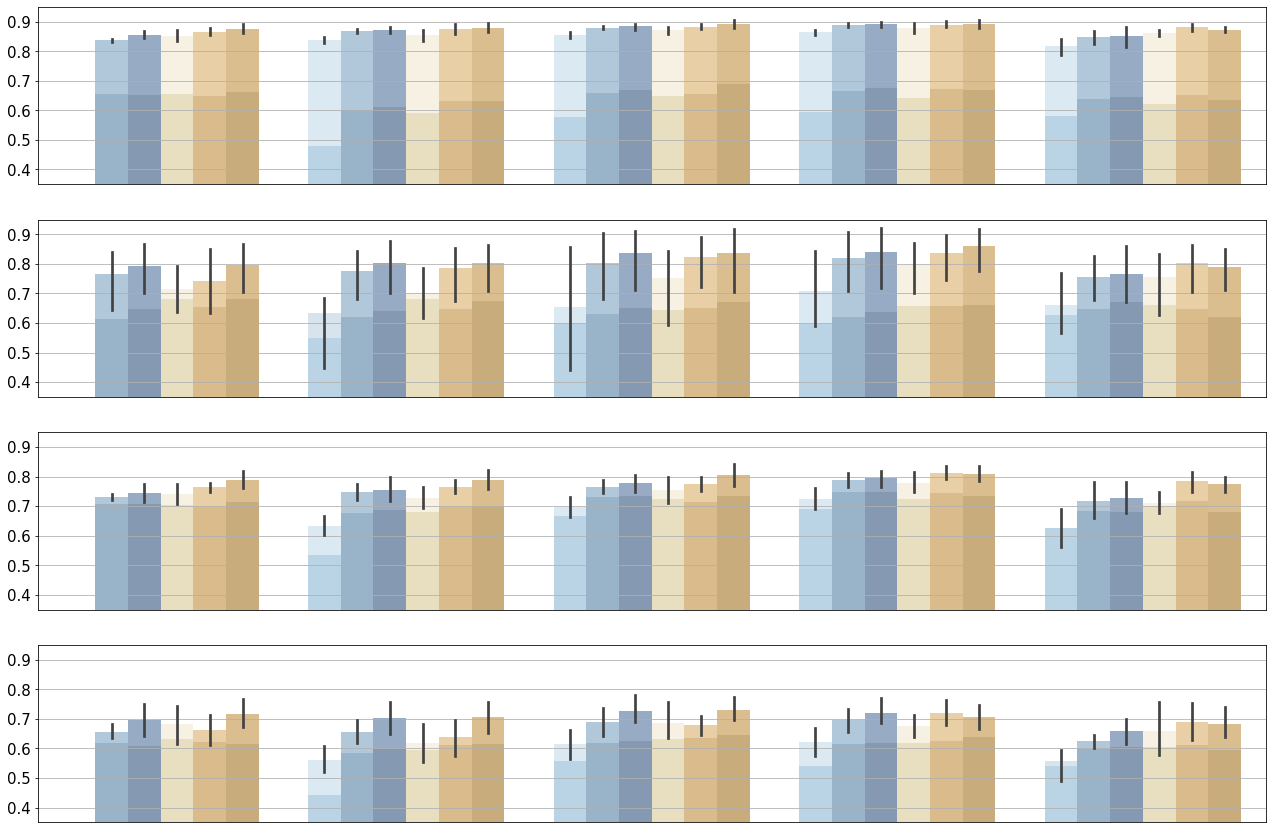

In [51]:
%matplotlib inline
custom_palette = [ "#D7E9F7","#A9C9E0", '#90AACB',"#F9F3DF","#F4D19B","#E6C183"]
darkened_palette = [darken_color(c, amount=0.5) for c in custom_palette]

fig, ax = plt.subplots(figsize=(22,15))
ax1=plt.subplot(411)

sns.barplot(
    data=data[(data.Group==0) & (data.Data=='RS')],
    x="Input", y="c_index", hue="Model",
    ci=95, palette=custom_palette
)
ax1.set_xlabel('') 
ax1.set_ylabel('') 
ax1.set_ylim([0.35,0.95])
ax1.get_legend().remove()
ax1.get_xaxis().set_visible(False)
plt.yticks(fontsize=15,rotation=0) 
plt.yticks([i/10 for i in range(4, 10)]) 
#plt.legend(ncol=4)
plt.grid(True, axis='y')

sns.barplot(
    data=data[(data.Group==0) & (data.Data=='ADNI')],
    x="Input", y="c_index", hue="Model",
    ci=0, palette=darkened_palette,alpha=0.2
)
ax1.set_xlabel('') 
ax1.set_ylabel('') 
ax1.set_ylim([0.35,0.95])
ax1.get_legend().remove()
ax1.get_xaxis().set_visible(False)
plt.yticks(fontsize=15,rotation=0) 
plt.yticks([i/10 for i in range(4, 10)]) 
#plt.legend(ncol=4)
plt.grid(True, axis='y')



ax1=plt.subplot(412)

sns.barplot(
    data=data[(data.Group==60) & (data.Data=='RS')],
    x="Input", y="c_index", hue="Model",
    ci=95, palette=custom_palette
)
ax1.set_xlabel('') 
ax1.set_ylabel('') 
ax1.set_ylim([0.35,0.95])
ax1.get_legend().remove()
ax1.get_xaxis().set_visible(False)
plt.yticks(fontsize=15,rotation=0) 
plt.yticks([i/10 for i in range(4, 10)]) 
#plt.legend(ncol=4)
plt.grid(True, axis='y')

sns.barplot(
    data=data[(data.Group==60) & (data.Data=='ADNI')],
    x="Input", y="c_index", hue="Model",
    ci=0, palette=darkened_palette,alpha=0.2
)
ax1.set_xlabel('') 
ax1.set_ylabel('') 
ax1.set_ylim([0.35,0.95])
ax1.get_legend().remove()
ax1.get_xaxis().set_visible(False)
plt.yticks(fontsize=15,rotation=0) 
plt.yticks([i/10 for i in range(4, 10)]) 
#plt.legend(ncol=4)
plt.grid(True, axis='y')


ax1=plt.subplot(413)

sns.barplot(
    data=data[(data.Group==70) & (data.Data=='RS')],
    x="Input", y="c_index", hue="Model",
    ci=95, palette=custom_palette
)
ax1.set_xlabel('') 
ax1.set_ylabel('') 
ax1.set_ylim([0.35,0.95])
ax1.get_legend().remove()
ax1.get_xaxis().set_visible(False)
plt.yticks(fontsize=15,rotation=0) 
plt.yticks([i/10 for i in range(4, 10)]) 
#plt.legend(ncol=4)
plt.grid(True, axis='y')

sns.barplot(
    data=data[(data.Group==70) & (data.Data=='ADNI')],
    x="Input", y="c_index", hue="Model",
    ci=0, palette=darkened_palette,alpha=0.2
)
ax1.set_xlabel('') 
ax1.set_ylabel('') 
ax1.set_ylim([0.35,0.95])
ax1.get_legend().remove()
ax1.get_xaxis().set_visible(False)
plt.yticks(fontsize=15,rotation=0) 
plt.yticks([i/10 for i in range(4, 10)]) 
#plt.legend(ncol=4)
plt.grid(True, axis='y')



ax1=plt.subplot(414)

sns.barplot(
    data=data[(data.Group==80) & (data.Data=='RS')],
    x="Input", y="c_index", hue="Model",
    ci=95, palette=custom_palette
)
ax1.set_xlabel('') 
ax1.set_ylabel('') 
ax1.set_ylim([0.35,0.95])
ax1.get_legend().remove()
ax1.get_xaxis().set_visible(False)
plt.yticks(fontsize=15,rotation=0) 
plt.yticks([i/10 for i in range(4, 10)]) 
#plt.legend(ncol=4)
plt.grid(True, axis='y')

sns.barplot(
    data=data[(data.Group==80) & (data.Data=='ADNI')],
    x="Input", y="c_index", hue="Model",
    ci=0, palette=darkened_palette,alpha=0.2
)
ax1.set_xlabel('') 
ax1.set_ylabel('') 
ax1.set_ylim([0.35,0.95])
ax1.get_legend().remove()
ax1.get_xaxis().set_visible(False)
plt.yticks(fontsize=15,rotation=0) 
plt.yticks([i/10 for i in range(4, 10)]) 
#plt.legend(ncol=4)
plt.grid(True, axis='y')

In [ ]:
# %matplotlib inline
# custom_palette = [ "#D7E9F7","#A9C9E0", '#90AACB',"#F9F3DF","#F4D19B"]
# darkened_palette = [darken_color(c, amount=0.5) for c in custom_palette]

# fig, ax = plt.subplots(figsize=(22,15))
# ax1=plt.subplot(411)

# sns.pointplot(
#     data=data[(data.Group==0) & (data.Data=='RS')],
#     x="Input", y="c_index", hue="Model",
#     ci=95, palette=custom_palette,errcolor='.26',alpha=1,dodge=0.3,
#     markers="o", linestyles=""
# )


# sns.pointplot(
#     data=data[(data.Group==0) & (data.Data=='ADNI')],
#     x="Input", y="c_index", hue="Model",
#     ci=95, palette=darkened_palette,errcolor='.26',alpha=0.2,dodge=0.3,
#     markers="o", linestyles=""
# )

    
# ax1.set_xlabel('') 
# ax1.set_ylabel('') 
# ax1.set_ylim([0.35,0.95])
# ax1.get_legend().remove()
# ax1.get_xaxis().set_visible(False)
# plt.yticks(fontsize=15,rotation=0) 
# plt.yticks([i/10 for i in range(4, 10)]) 
# #plt.legend(ncol=4)
# plt.grid(True, axis='y')




# ax1=plt.subplot(412)

# sns.pointplot(
#     data=data[(data.Group==60) & (data.Data=='RS')],
#     x="Input", y="c_index", hue="Model",
#     ci=95, palette=custom_palette,errcolor='.26',alpha=1,dodge=0.3,
#     markers="o", linestyles=""
# )


# sns.pointplot(
#     data=data[(data.Group==60) & (data.Data=='ADNI')],
#     x="Input", y="c_index", hue="Model",
#     ci=95, palette=darkened_palette,errcolor='.26',alpha=0.2,dodge=0.3,
#     markers="o", linestyles=""
# )

    
# ax1.set_xlabel('') 
# ax1.set_ylabel('') 
# ax1.set_ylim([0.35,0.95])
# ax1.get_legend().remove()
# ax1.get_xaxis().set_visible(False)
# plt.yticks(fontsize=15,rotation=0) 
# plt.yticks([i/10 for i in range(4, 10)]) 
# #plt.legend(ncol=4)
# plt.grid(True, axis='y')



# ax1=plt.subplot(413)

# sns.pointplot(
#     data=data[(data.Group==70) & (data.Data=='RS')],
#     x="Input", y="c_index", hue="Model",
#     ci=95, palette=custom_palette,errcolor='.26',alpha=1,dodge=0.3,
#     markers="o", linestyles=""
# )


# sns.pointplot(
#     data=data[(data.Group==70) & (data.Data=='ADNI')],
#     x="Input", y="c_index", hue="Model",
#     ci=95, palette=darkened_palette,errcolor='.26',alpha=0.2,dodge=0.3,
#     markers="o", linestyles=""
# )

    
# ax1.set_xlabel('') 
# ax1.set_ylabel('') 
# ax1.set_ylim([0.35,0.95])
# ax1.get_legend().remove()
# ax1.get_xaxis().set_visible(False)
# plt.yticks(fontsize=15,rotation=0) 
# plt.yticks([i/10 for i in range(4, 10)]) 
# #plt.legend(ncol=4)
# plt.grid(True, axis='y')


# ax1=plt.subplot(414)

# sns.pointplot(
#     data=data[(data.Group==80) & (data.Data=='RS')],
#     x="Input", y="c_index", hue="Model",
#     ci=95, palette=custom_palette,errcolor='.26',alpha=1,dodge=0.3,
#     markers="o", linestyles=""
# )


# sns.pointplot(
#     data=data[(data.Group==80) & (data.Data=='ADNI')],
#     x="Input", y="c_index", hue="Model",
#     ci=95, palette=darkened_palette,errcolor='.26',alpha=0.2,dodge=0.3,
#     markers="o", linestyles=""
# )

    
# ax1.set_xlabel('') 
# ax1.set_ylabel('') 
# ax1.set_ylim([0.35,0.95])
# ax1.get_legend().remove()
# ax1.get_xaxis().set_visible(False)
# plt.yticks(fontsize=15,rotation=0) 
# plt.yticks([i/10 for i in range(4, 10)]) 
# #plt.legend(ncol=4)
# plt.grid(True, axis='y')

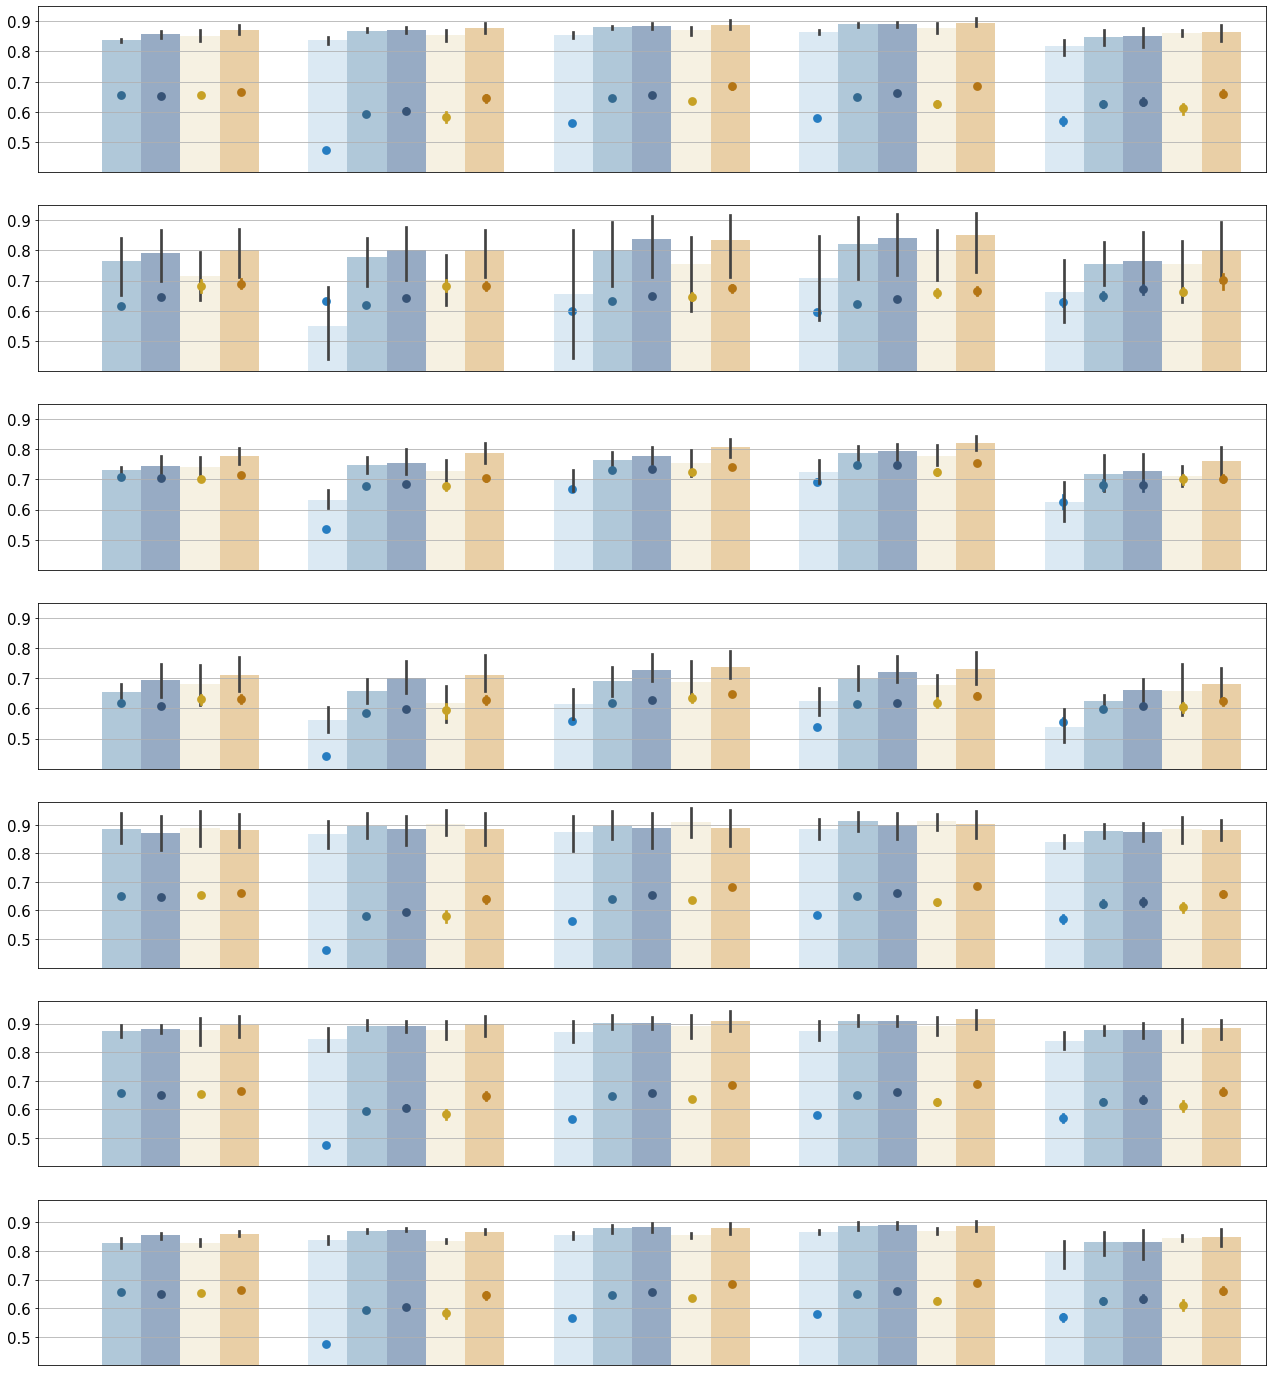

In [9]:
###Image feature linear
%matplotlib inline
custom_palette = [ "#D7E9F7","#A9C9E0", '#90AACB',"#F9F3DF","#F4D19B"]


darkened_palette = [darken_color(c, amount=0.5) for c in custom_palette]

fig, ax = plt.subplots(figsize=(22,25))
ax1=plt.subplot(711)

sns.barplot(
    data=data[(data.Group==0) & (data.Data=='RS')],
    x="Input", y="c_index", hue="Model",
    ci=95, palette=custom_palette
)

sns.pointplot(
    data=data[(data.Group==0) & (data.Data=='ADNI')],
    x="Input", y="c_index", hue="Model",
    ci=95, palette=darkened_palette,errcolor='.26',alpha=0.2,dodge=0.65,
    markers="o", linestyles=""
)
ax1.set_xlabel('') 
ax1.set_ylabel('') 
ax1.set_ylim([0.4,0.95])
ax1.get_legend().remove()
ax1.get_xaxis().set_visible(False)
plt.yticks(fontsize=15,rotation=0) 
plt.yticks([i/10 for i in range(5, 10)]) 
#plt.legend(ncol=4)
plt.grid(True, axis='y')



ax1=plt.subplot(712)

sns.barplot(
    data=data[(data.Group==60) & (data.Data=='RS')],
    x="Input", y="c_index", hue="Model",
    ci=95, palette=custom_palette
)


sns.pointplot(
    data=data[(data.Group==60) & (data.Data=='ADNI')],
    x="Input", y="c_index", hue="Model",
    ci=95, palette=darkened_palette,errcolor='.26',alpha=0.2,dodge=0.65,
    markers="o", linestyles=""
)



# for bar in ax.patches[len(data[(data.Group=='60') & (data.Data=='ADNI')]):]:  # Only affect g's bars
#     bar.set_width(0.1)  # Set the width for the second plot (g)

    
ax1.set_xlabel('') 
ax1.set_ylabel('') 
ax1.set_ylim([0.4,0.95])
ax1.get_legend().remove()
ax1.get_xaxis().set_visible(False)
plt.yticks(fontsize=15,rotation=0) 
plt.yticks([i/10 for i in range(5, 10)]) 
#plt.legend(ncol=4)
plt.grid(True, axis='y')



ax1=plt.subplot(713)

sns.barplot(
    data=data[(data.Group==70) & (data.Data=='RS')],
    x="Input", y="c_index", hue="Model",
    ci=95, palette=custom_palette
)

sns.pointplot(
    data=data[(data.Group==70) & (data.Data=='ADNI')],
    x="Input", y="c_index", hue="Model",
    ci=95, palette=darkened_palette,errcolor='.26',alpha=0.2,dodge=0.65,
    markers="o", linestyles=""
)
ax1.set_xlabel('') 
ax1.set_ylabel('') 
ax1.set_ylim([0.4,0.95])
ax1.get_legend().remove()
ax1.get_xaxis().set_visible(False)
plt.yticks(fontsize=15,rotation=0) 
plt.yticks([i/10 for i in range(5, 10)]) 
#plt.legend(ncol=4)
plt.grid(True, axis='y')




ax1=plt.subplot(714)

sns.barplot(
    data=data[(data.Group==80) & (data.Data=='RS')],
    x="Input", y="c_index", hue="Model",
    ci=95, palette=custom_palette
)

sns.pointplot(
    data=data[(data.Group==80) & (data.Data=='ADNI')],
    x="Input", y="c_index", hue="Model",
    ci=95, palette=darkened_palette,errcolor='.26',alpha=0.2,dodge=0.65,
    markers="o", linestyles=""
)
ax1.set_xlabel('') 
ax1.set_ylabel('') 
ax1.set_ylim([0.4,0.95])
ax1.get_legend().remove()
ax1.get_xaxis().set_visible(False)
plt.yticks(fontsize=15,rotation=0) 
plt.yticks([i/10 for i in range(5, 10)]) 
#plt.legend(ncol=4)
plt.grid(True, axis='y')




ax1=plt.subplot(715)

sns.barplot(
    data=data[(data.Group==3) & (data.Data=='RS')],
    x="Input", y="c_index", hue="Model",
    ci=95, palette=custom_palette
)


sns.pointplot(
    data=data[(data.Group==3) & (data.Data=='ADNI')],
    x="Input", y="c_index", hue="Model",
    ci=95, palette=darkened_palette,errcolor='.26',alpha=0.2,dodge=0.65,
    markers="o", linestyles=""
)

    
ax1.set_xlabel('') 
ax1.set_ylabel('') 
ax1.set_ylim([0.4,0.98])
ax1.get_legend().remove()
ax1.get_xaxis().set_visible(False)
plt.yticks(fontsize=15,rotation=0) 
plt.yticks([i/10 for i in range(5, 10)]) 
#plt.legend(ncol=4)
plt.grid(True, axis='y')



ax1=plt.subplot(716)

sns.barplot(
    data=data[(data.Group==5) & (data.Data=='RS')],
    x="Input", y="c_index", hue="Model",
    ci=95, palette=custom_palette
)

sns.pointplot(
    data=data[(data.Group==5) & (data.Data=='ADNI')],
    x="Input", y="c_index", hue="Model",
    ci=95, palette=darkened_palette,errcolor='.26',alpha=0.2,dodge=0.65,
    markers="o", linestyles=""
)
ax1.set_xlabel('') 
ax1.set_ylabel('') 
ax1.set_ylim([0.4,0.98])
ax1.get_legend().remove()
ax1.get_xaxis().set_visible(False)
plt.yticks(fontsize=15,rotation=0) 
plt.yticks([i/10 for i in range(5, 10)]) 
#plt.legend(ncol=4)
plt.grid(True, axis='y')




ax1=plt.subplot(717)

sns.barplot(
    data=data[(data.Group==10) & (data.Data=='RS')],
    x="Input", y="c_index", hue="Model",
    ci=95, palette=custom_palette
)

sns.pointplot(
    data=data[(data.Group==10) & (data.Data=='ADNI')],
    x="Input", y="c_index", hue="Model",
    ci=95, palette=darkened_palette,errcolor='.26',alpha=0.2,dodge=0.65,
    markers="o", linestyles=""
)
ax1.set_xlabel('') 
ax1.set_ylabel('') 
ax1.set_ylim([0.4,0.98])
ax1.get_legend().remove()
ax1.get_xaxis().set_visible(False)
plt.yticks(fontsize=15,rotation=0) 
plt.yticks([i/10 for i in range(5, 10)]) 
#plt.legend(ncol=4)
plt.grid(True, axis='y')

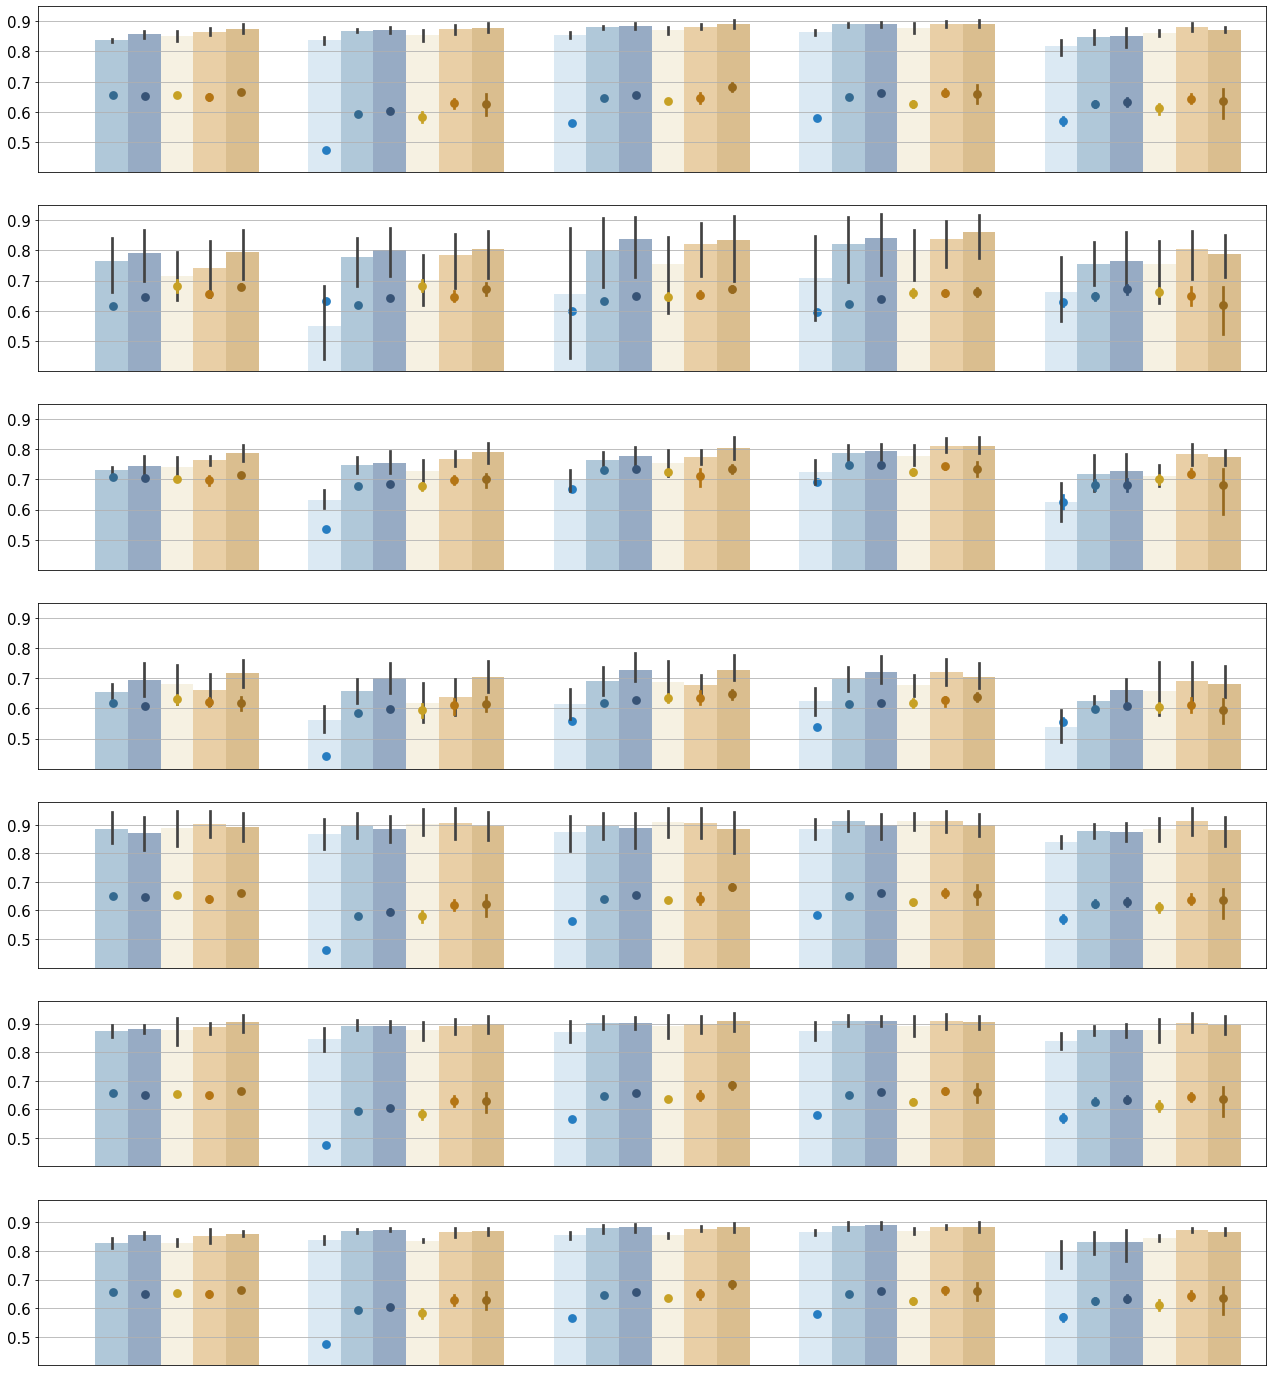

In [ ]:
###Image feature NN 
%matplotlib inline
custom_palette = [ "#D7E9F7","#A9C9E0", '#90AACB',"#F9F3DF","#F4D19B","#E6C183"]


darkened_palette = [darken_color(c, amount=0.5) for c in custom_palette]

fig, ax = plt.subplots(figsize=(22,25))
ax1=plt.subplot(711)

sns.barplot(
    data=data[(data.Group==0) & (data.Data=='RS')],
    x="Input", y="c_index", hue="Model",
    ci=95, palette=custom_palette
)

sns.pointplot(
    data=data[(data.Group==0) & (data.Data=='ADNI')],
    x="Input", y="c_index", hue="Model",
    ci=95, palette=darkened_palette,errcolor='.26',alpha=0.2,dodge=0.65,
    markers="o", linestyles=""
)
ax1.set_xlabel('') 
ax1.set_ylabel('') 
ax1.set_ylim([0.4,0.95])
ax1.get_legend().remove()
ax1.get_xaxis().set_visible(False)
plt.yticks(fontsize=15,rotation=0) 
plt.yticks([i/10 for i in range(5, 10)]) 
#plt.legend(ncol=4)
plt.grid(True, axis='y')



ax1=plt.subplot(712)

sns.barplot(
    data=data[(data.Group==60) & (data.Data=='RS')],
    x="Input", y="c_index", hue="Model",
    ci=95, palette=custom_palette
)


sns.pointplot(
    data=data[(data.Group==60) & (data.Data=='ADNI')],
    x="Input", y="c_index", hue="Model",
    ci=95, palette=darkened_palette,errcolor='.26',alpha=0.2,dodge=0.65,
    markers="o", linestyles=""
)



# for bar in ax.patches[len(data[(data.Group=='60') & (data.Data=='ADNI')]):]:  # Only affect g's bars
#     bar.set_width(0.1)  # Set the width for the second plot (g)

    
ax1.set_xlabel('') 
ax1.set_ylabel('') 
ax1.set_ylim([0.4,0.95])
ax1.get_legend().remove()
ax1.get_xaxis().set_visible(False)
plt.yticks(fontsize=15,rotation=0) 
plt.yticks([i/10 for i in range(5, 10)]) 
#plt.legend(ncol=4)
plt.grid(True, axis='y')



ax1=plt.subplot(713)

sns.barplot(
    data=data[(data.Group==70) & (data.Data=='RS')],
    x="Input", y="c_index", hue="Model",
    ci=95, palette=custom_palette
)

sns.pointplot(
    data=data[(data.Group==70) & (data.Data=='ADNI')],
    x="Input", y="c_index", hue="Model",
    ci=95, palette=darkened_palette,errcolor='.26',alpha=0.2,dodge=0.65,
    markers="o", linestyles=""
)
ax1.set_xlabel('') 
ax1.set_ylabel('') 
ax1.set_ylim([0.4,0.95])
ax1.get_legend().remove()
ax1.get_xaxis().set_visible(False)
plt.yticks(fontsize=15,rotation=0) 
plt.yticks([i/10 for i in range(5, 10)]) 
#plt.legend(ncol=4)
plt.grid(True, axis='y')




ax1=plt.subplot(714)

sns.barplot(
    data=data[(data.Group==80) & (data.Data=='RS')],
    x="Input", y="c_index", hue="Model",
    ci=95, palette=custom_palette
)

sns.pointplot(
    data=data[(data.Group==80) & (data.Data=='ADNI')],
    x="Input", y="c_index", hue="Model",
    ci=95, palette=darkened_palette,errcolor='.26',alpha=0.2,dodge=0.65,
    markers="o", linestyles=""
)
ax1.set_xlabel('') 
ax1.set_ylabel('') 
ax1.set_ylim([0.4,0.95])
ax1.get_legend().remove()
ax1.get_xaxis().set_visible(False)
plt.yticks(fontsize=15,rotation=0) 
plt.yticks([i/10 for i in range(5, 10)]) 
#plt.legend(ncol=4)
plt.grid(True, axis='y')




ax1=plt.subplot(715)

sns.barplot(
    data=data[(data.Group==3) & (data.Data=='RS')],
    x="Input", y="c_index", hue="Model",
    ci=95, palette=custom_palette
)


sns.pointplot(
    data=data[(data.Group==3) & (data.Data=='ADNI')],
    x="Input", y="c_index", hue="Model",
    ci=95, palette=darkened_palette,errcolor='.26',alpha=0.2,dodge=0.65,
    markers="o", linestyles=""
)

    
ax1.set_xlabel('') 
ax1.set_ylabel('') 
ax1.set_ylim([0.4,0.98])
ax1.get_legend().remove()
ax1.get_xaxis().set_visible(False)
plt.yticks(fontsize=15,rotation=0) 
plt.yticks([i/10 for i in range(5, 10)]) 
#plt.legend(ncol=4)
plt.grid(True, axis='y')



ax1=plt.subplot(716)

sns.barplot(
    data=data[(data.Group==5) & (data.Data=='RS')],
    x="Input", y="c_index", hue="Model",
    ci=95, palette=custom_palette
)

sns.pointplot(
    data=data[(data.Group==5) & (data.Data=='ADNI')],
    x="Input", y="c_index", hue="Model",
    ci=95, palette=darkened_palette,errcolor='.26',alpha=0.2,dodge=0.65,
    markers="o", linestyles=""
)
ax1.set_xlabel('') 
ax1.set_ylabel('') 
ax1.set_ylim([0.4,0.98])
ax1.get_legend().remove()
ax1.get_xaxis().set_visible(False)
plt.yticks(fontsize=15,rotation=0) 
plt.yticks([i/10 for i in range(5, 10)]) 
#plt.legend(ncol=4)
plt.grid(True, axis='y')




ax1=plt.subplot(717)

sns.barplot(
    data=data[(data.Group==10) & (data.Data=='RS')],
    x="Input", y="c_index", hue="Model",
    ci=95, palette=custom_palette
)

sns.pointplot(
    data=data[(data.Group==10) & (data.Data=='ADNI')],
    x="Input", y="c_index", hue="Model",
    ci=95, palette=darkened_palette,errcolor='.26',alpha=0.2,dodge=0.65,
    markers="o", linestyles=""
)
ax1.set_xlabel('') 
ax1.set_ylabel('') 
ax1.set_ylim([0.4,0.98])
ax1.get_legend().remove()
ax1.get_xaxis().set_visible(False)
plt.yticks(fontsize=15,rotation=0) 
plt.yticks([i/10 for i in range(5, 10)]) 
#plt.legend(ncol=4)
plt.grid(True, axis='y')

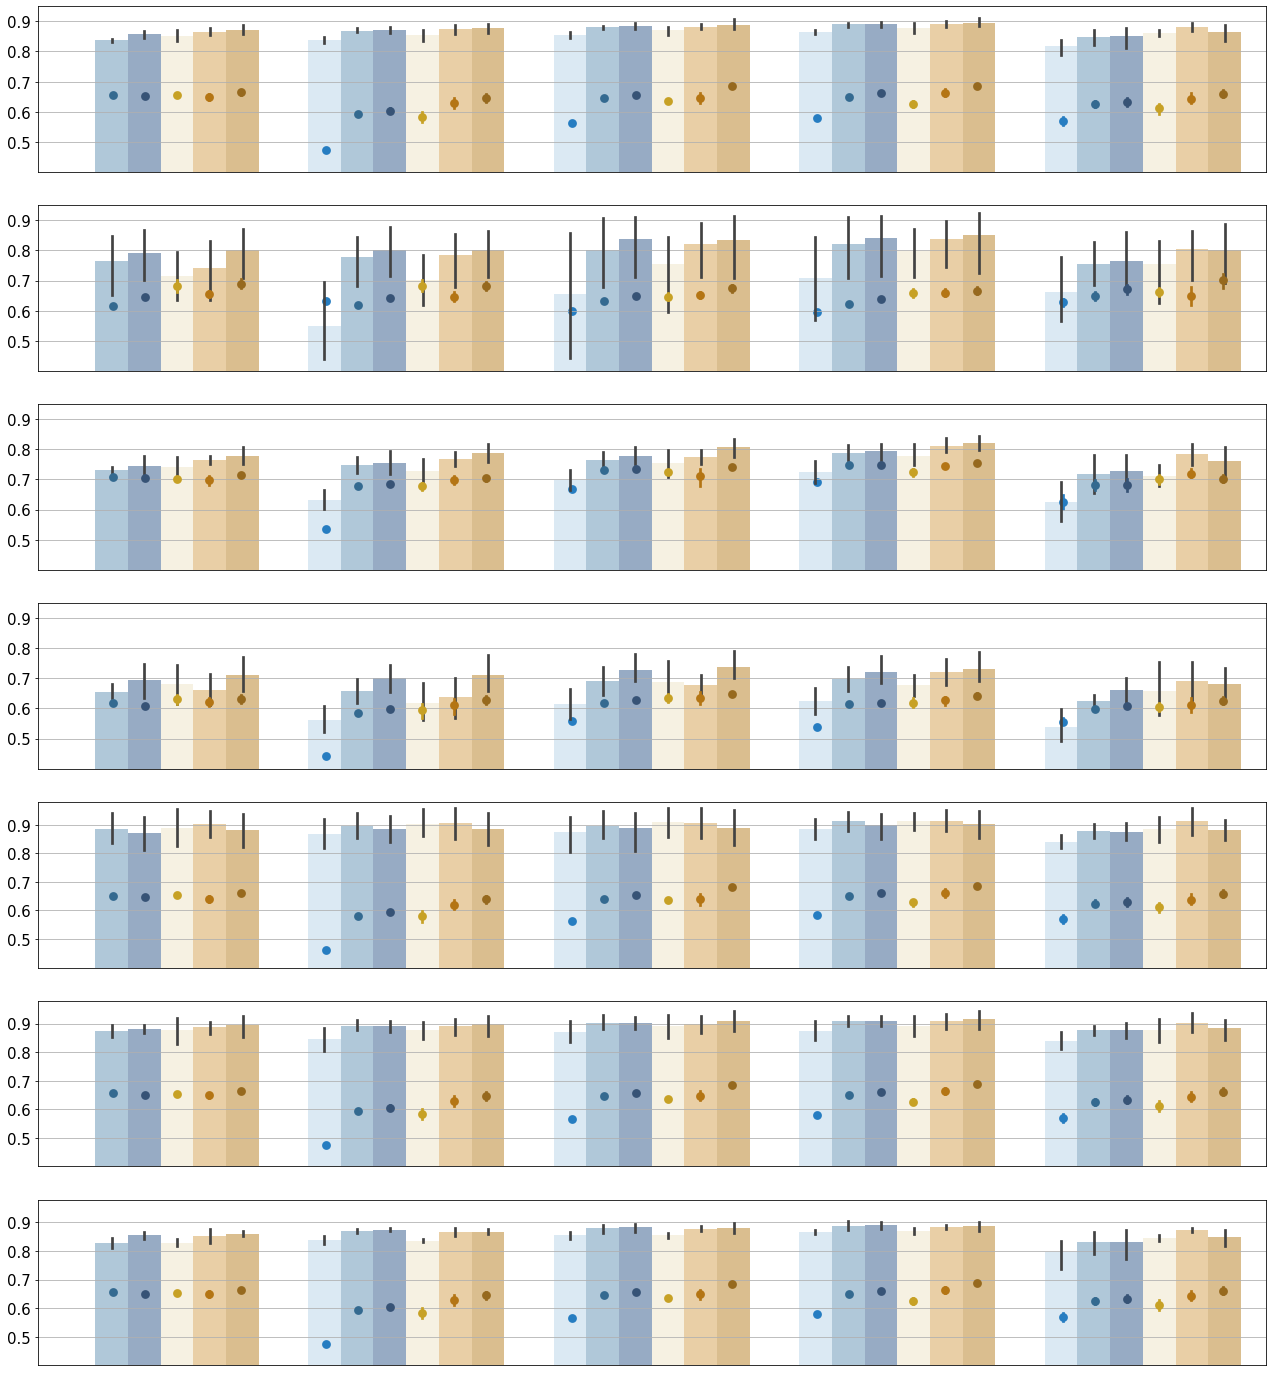

In [21]:
###Image feature linear
%matplotlib inline
custom_palette = [ "#D7E9F7","#A9C9E0", '#90AACB',"#F9F3DF","#F4D19B","#E6C183"]


darkened_palette = [darken_color(c, amount=0.5) for c in custom_palette]

fig, ax = plt.subplots(figsize=(22,25))
ax1=plt.subplot(711)

sns.barplot(
    data=data[(data.Group==0) & (data.Data=='RS')],
    x="Input", y="c_index", hue="Model",
    ci=95, palette=custom_palette
)

sns.pointplot(
    data=data[(data.Group==0) & (data.Data=='ADNI')],
    x="Input", y="c_index", hue="Model",
    ci=95, palette=darkened_palette,errcolor='.26',alpha=0.2,dodge=0.65,
    markers="o", linestyles=""
)
ax1.set_xlabel('') 
ax1.set_ylabel('') 
ax1.set_ylim([0.4,0.95])
ax1.get_legend().remove()
ax1.get_xaxis().set_visible(False)
plt.yticks(fontsize=15,rotation=0) 
plt.yticks([i/10 for i in range(5, 10)]) 
#plt.legend(ncol=4)
plt.grid(True, axis='y')



ax1=plt.subplot(712)

sns.barplot(
    data=data[(data.Group==60) & (data.Data=='RS')],
    x="Input", y="c_index", hue="Model",
    ci=95, palette=custom_palette
)


sns.pointplot(
    data=data[(data.Group==60) & (data.Data=='ADNI')],
    x="Input", y="c_index", hue="Model",
    ci=95, palette=darkened_palette,errcolor='.26',alpha=0.2,dodge=0.65,
    markers="o", linestyles=""
)



# for bar in ax.patches[len(data[(data.Group=='60') & (data.Data=='ADNI')]):]:  # Only affect g's bars
#     bar.set_width(0.1)  # Set the width for the second plot (g)

    
ax1.set_xlabel('') 
ax1.set_ylabel('') 
ax1.set_ylim([0.4,0.95])
ax1.get_legend().remove()
ax1.get_xaxis().set_visible(False)
plt.yticks(fontsize=15,rotation=0) 
plt.yticks([i/10 for i in range(5, 10)]) 
#plt.legend(ncol=4)
plt.grid(True, axis='y')



ax1=plt.subplot(713)

sns.barplot(
    data=data[(data.Group==70) & (data.Data=='RS')],
    x="Input", y="c_index", hue="Model",
    ci=95, palette=custom_palette
)

sns.pointplot(
    data=data[(data.Group==70) & (data.Data=='ADNI')],
    x="Input", y="c_index", hue="Model",
    ci=95, palette=darkened_palette,errcolor='.26',alpha=0.2,dodge=0.65,
    markers="o", linestyles=""
)
ax1.set_xlabel('') 
ax1.set_ylabel('') 
ax1.set_ylim([0.4,0.95])
ax1.get_legend().remove()
ax1.get_xaxis().set_visible(False)
plt.yticks(fontsize=15,rotation=0) 
plt.yticks([i/10 for i in range(5, 10)]) 
#plt.legend(ncol=4)
plt.grid(True, axis='y')




ax1=plt.subplot(714)

sns.barplot(
    data=data[(data.Group==80) & (data.Data=='RS')],
    x="Input", y="c_index", hue="Model",
    ci=95, palette=custom_palette
)

sns.pointplot(
    data=data[(data.Group==80) & (data.Data=='ADNI')],
    x="Input", y="c_index", hue="Model",
    ci=95, palette=darkened_palette,errcolor='.26',alpha=0.2,dodge=0.65,
    markers="o", linestyles=""
)
ax1.set_xlabel('') 
ax1.set_ylabel('') 
ax1.set_ylim([0.4,0.95])
ax1.get_legend().remove()
ax1.get_xaxis().set_visible(False)
plt.yticks(fontsize=15,rotation=0) 
plt.yticks([i/10 for i in range(5, 10)]) 
#plt.legend(ncol=4)
plt.grid(True, axis='y')




ax1=plt.subplot(715)

sns.barplot(
    data=data[(data.Group==3) & (data.Data=='RS')],
    x="Input", y="c_index", hue="Model",
    ci=95, palette=custom_palette
)


sns.pointplot(
    data=data[(data.Group==3) & (data.Data=='ADNI')],
    x="Input", y="c_index", hue="Model",
    ci=95, palette=darkened_palette,errcolor='.26',alpha=0.2,dodge=0.65,
    markers="o", linestyles=""
)

    
ax1.set_xlabel('') 
ax1.set_ylabel('') 
ax1.set_ylim([0.4,0.98])
ax1.get_legend().remove()
ax1.get_xaxis().set_visible(False)
plt.yticks(fontsize=15,rotation=0) 
plt.yticks([i/10 for i in range(5, 10)]) 
#plt.legend(ncol=4)
plt.grid(True, axis='y')



ax1=plt.subplot(716)

sns.barplot(
    data=data[(data.Group==5) & (data.Data=='RS')],
    x="Input", y="c_index", hue="Model",
    ci=95, palette=custom_palette
)

sns.pointplot(
    data=data[(data.Group==5) & (data.Data=='ADNI')],
    x="Input", y="c_index", hue="Model",
    ci=95, palette=darkened_palette,errcolor='.26',alpha=0.2,dodge=0.65,
    markers="o", linestyles=""
)
ax1.set_xlabel('') 
ax1.set_ylabel('') 
ax1.set_ylim([0.4,0.98])
ax1.get_legend().remove()
ax1.get_xaxis().set_visible(False)
plt.yticks(fontsize=15,rotation=0) 
plt.yticks([i/10 for i in range(5, 10)]) 
#plt.legend(ncol=4)
plt.grid(True, axis='y')




ax1=plt.subplot(717)

sns.barplot(
    data=data[(data.Group==10) & (data.Data=='RS')],
    x="Input", y="c_index", hue="Model",
    ci=95, palette=custom_palette
)

sns.pointplot(
    data=data[(data.Group==10) & (data.Data=='ADNI')],
    x="Input", y="c_index", hue="Model",
    ci=95, palette=darkened_palette,errcolor='.26',alpha=0.2,dodge=0.65,
    markers="o", linestyles=""
)
ax1.set_xlabel('') 
ax1.set_ylabel('') 
ax1.set_ylim([0.4,0.98])
ax1.get_legend().remove()
ax1.get_xaxis().set_visible(False)
plt.yticks(fontsize=15,rotation=0) 
plt.yticks([i/10 for i in range(5, 10)]) 
#plt.legend(ncol=4)
plt.grid(True, axis='y')

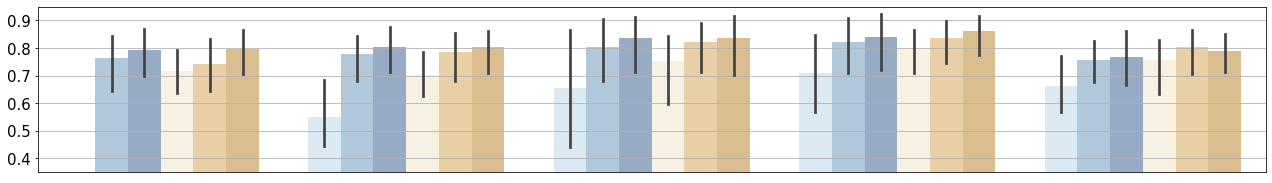

In [65]:
custom_palette = [ "#D7E9F7","#A9C9E0", '#90AACB',"#F9F3DF","#F4D19B","#E6C183"]

fig, ax = plt.subplots(figsize=(22,25))
ax1=plt.subplot(711)

sns.barplot(
    data=data[(data.Group==60) & (data.Data=='RS')],
    x="Input", y="c_index", hue="Model",
    ci=95, palette=custom_palette
)

ax1.set_xlabel('') 
ax1.set_ylabel('') 
ax1.set_ylim([0.35,0.95])
ax1.get_legend().remove()
ax1.get_xaxis().set_visible(False)
plt.yticks(fontsize=15,rotation=0) 
plt.yticks([i/10 for i in range(4, 10)]) 
#plt.legend(ncol=4)
plt.grid(True, axis='y')


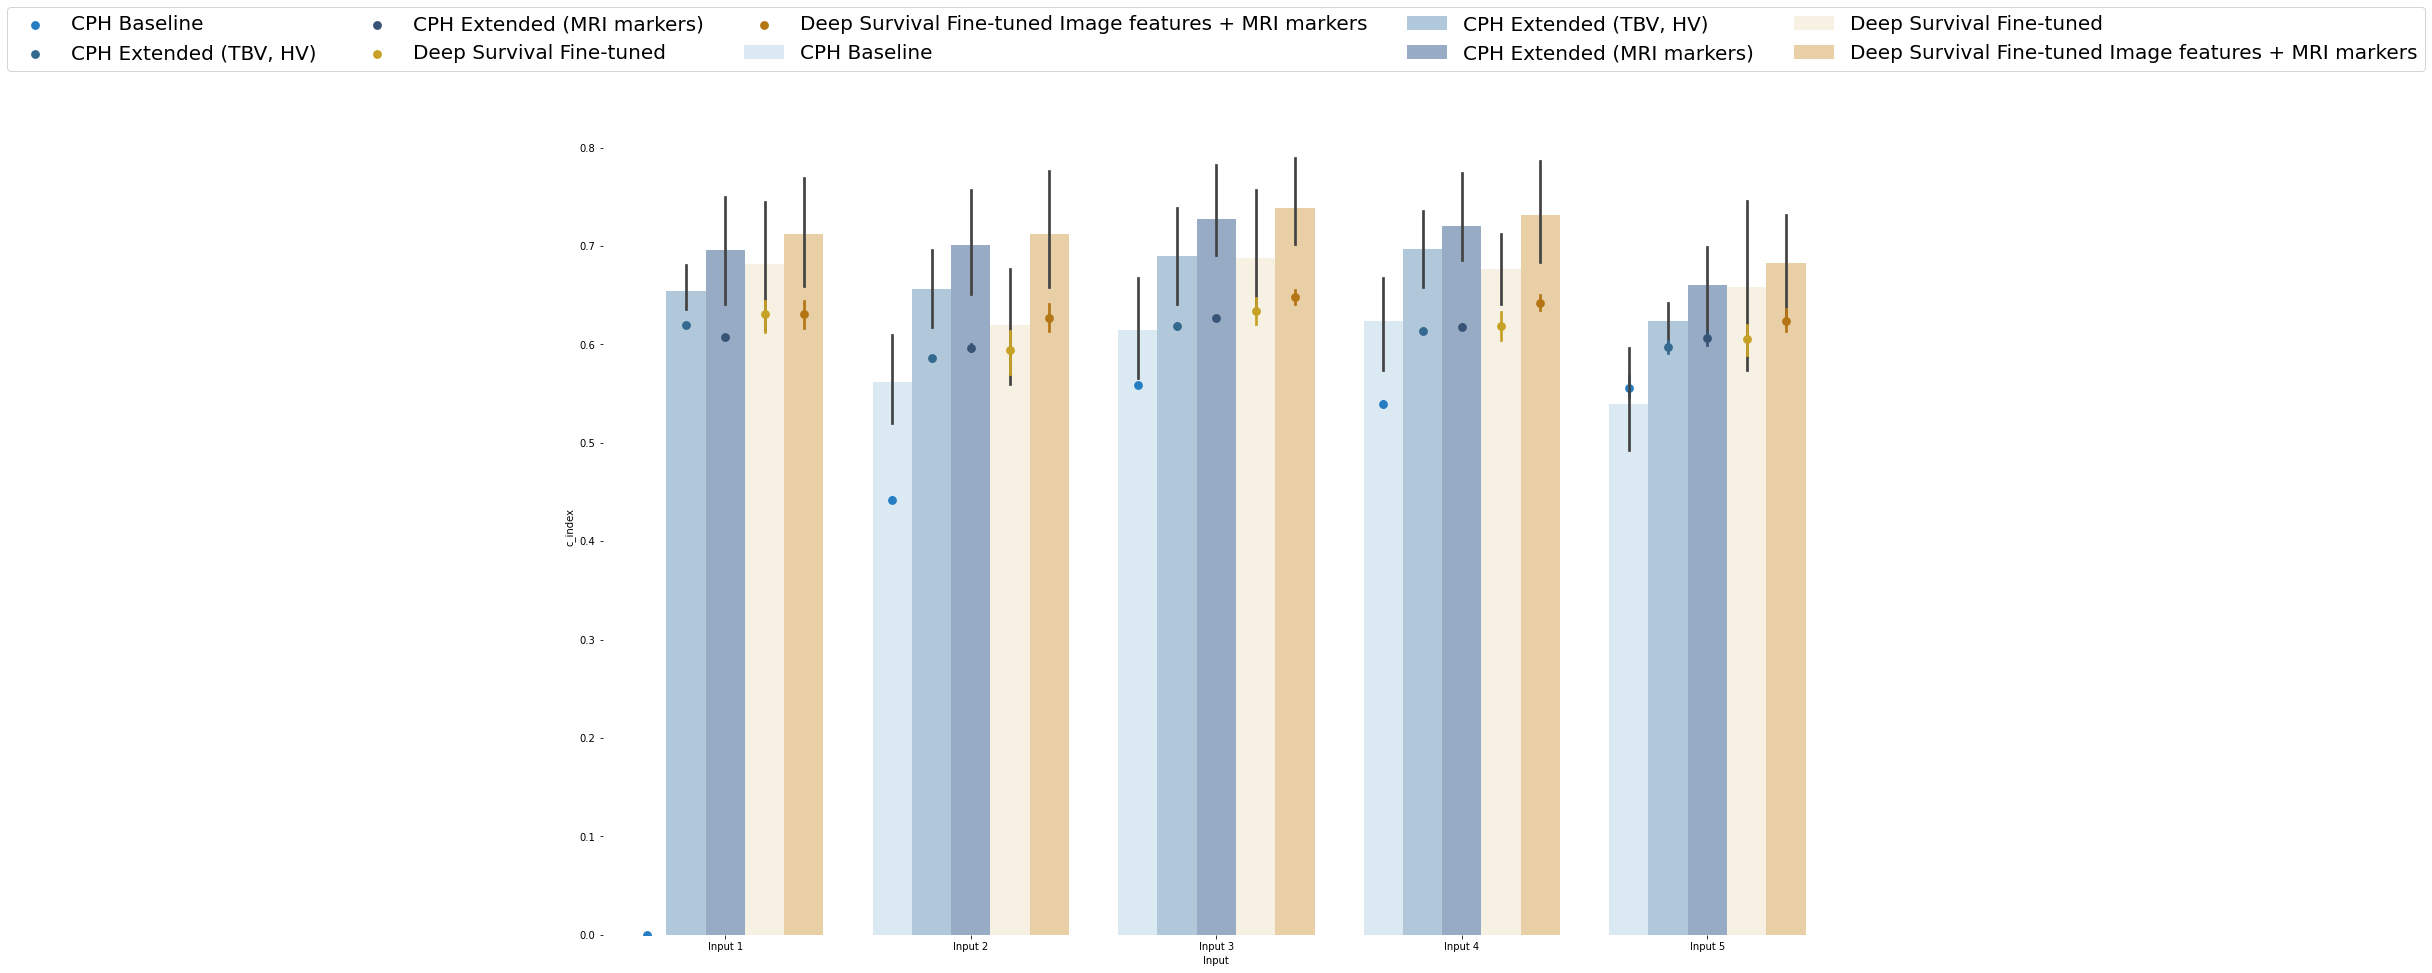

In [21]:
fig, ax = plt.subplots(figsize=(22,15))
sns.barplot(
    data=data[(data.Group==80) & (data.Data=='RS')],
    x="Input", y="c_index", hue="Model",
    ci=95, palette=custom_palette,
)


sns.pointplot(
    data=data[(data.Group==80) & (data.Data=='ADNI')],
    x="Input", y="c_index", hue="Model",
    ci=95, palette=darkened_palette,errcolor='.26',alpha=0,dodge=0.64,
    markers="o", linestyles=""
)

ax1.axis('off')
plt.legend(ncol=5,fontsize=20,loc='upper center',bbox_to_anchor=(0.5, 1.15), )
for spine in plt.gca().spines.values():
    spine.set_visible(False)


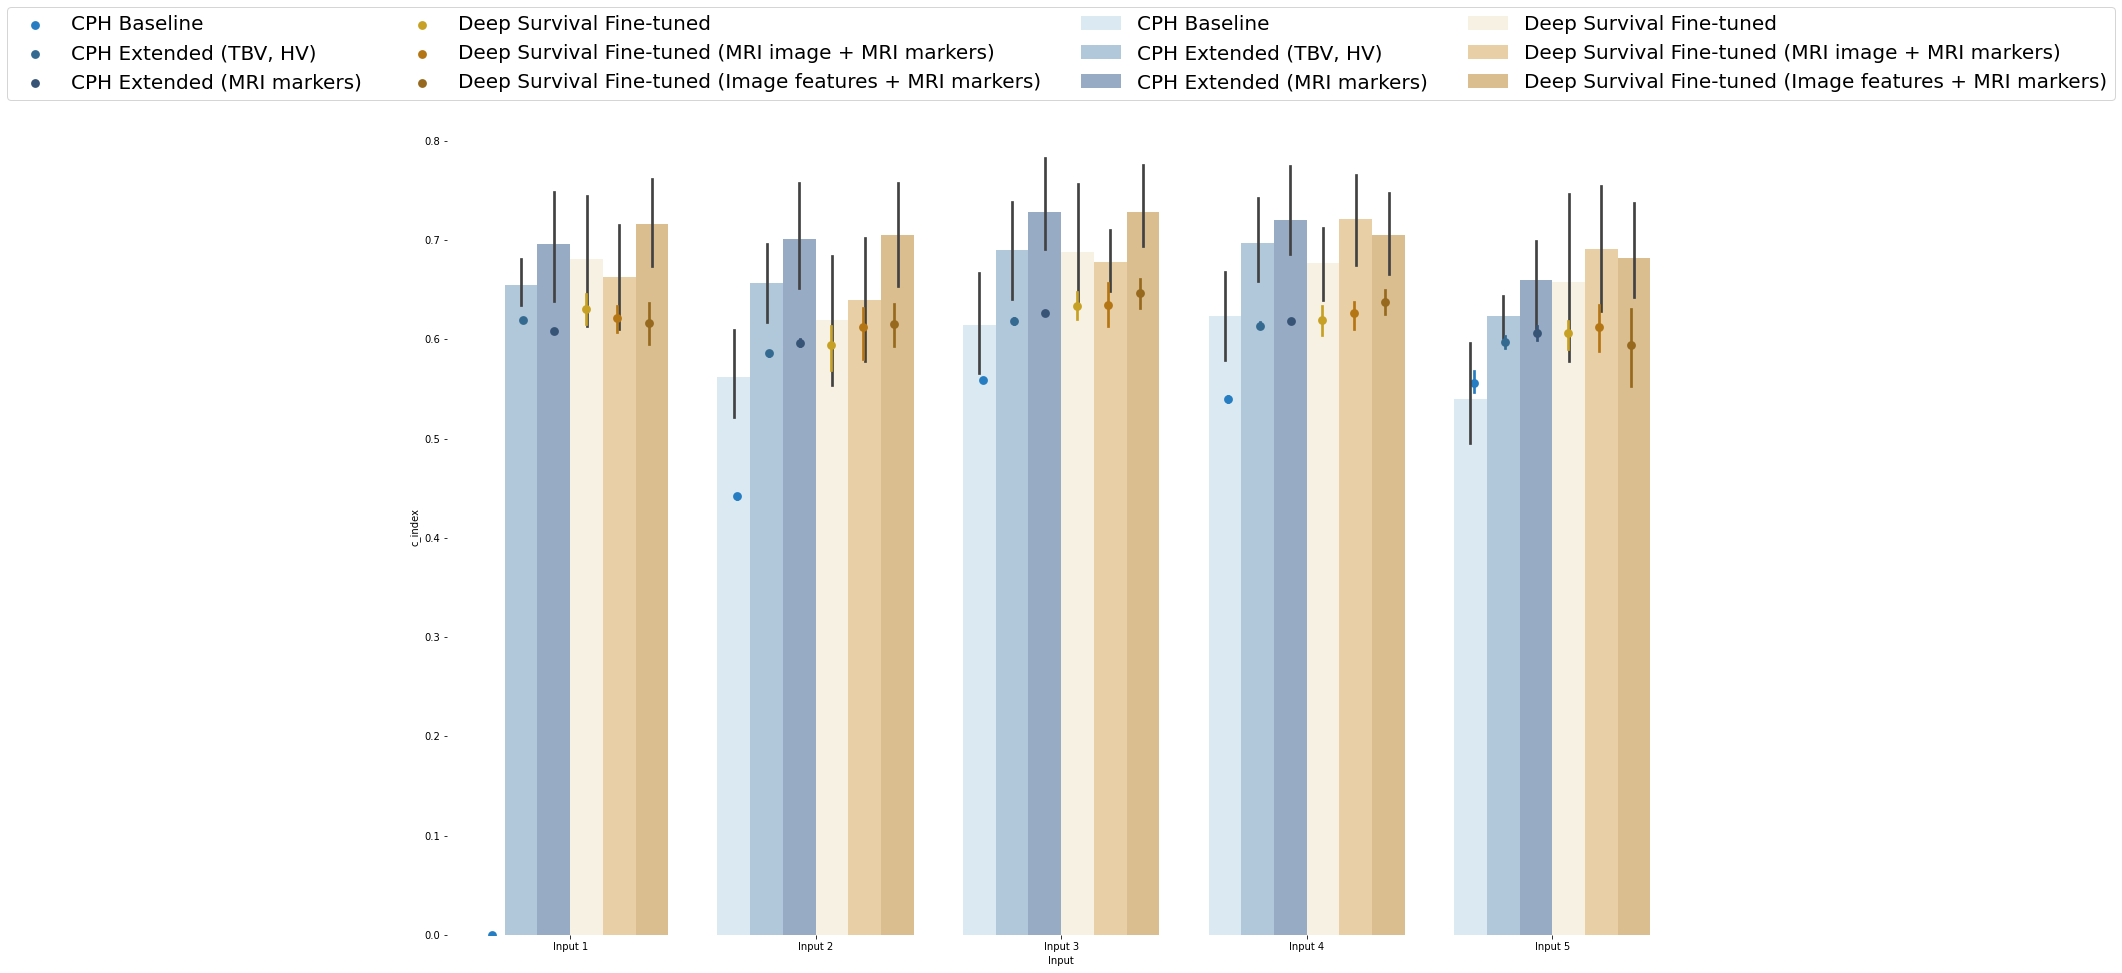

In [66]:
fig, ax = plt.subplots(figsize=(22,15))
sns.barplot(
    data=data[(data.Group==80) & (data.Data=='RS')],
    x="Input", y="c_index", hue="Model",
    ci=95, palette=custom_palette,
)


sns.pointplot(
    data=data[(data.Group==80) & (data.Data=='ADNI')],
    x="Input", y="c_index", hue="Model",
    ci=95, palette=darkened_palette,errcolor='.26',alpha=0,dodge=0.64,
    markers="o", linestyles=""
)

ax1.axis('off')
plt.legend(ncol=4,fontsize=20,loc='upper center',bbox_to_anchor=(0.5, 1.15), )
for spine in plt.gca().spines.values():
    spine.set_visible(False)


In [ ]:
np.mean(ci_test_0.T)